In [11]:
import gc
import sys
from statistics import mean
import time
import torch
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import itertools
from pathlib import Path
from scipy import special
import matplotlib.pyplot as plt
import datetime
import torch.linalg as LA
from torch.distributions.laplace import Laplace



import utils
import models
import learning_utils
from configurations import args_parser, arguments



In [12]:
%load_ext autoreload
%autoreload 2



args = arguments()
#boardio is for the the tensorboardx prensetaion and textio is for written documentation
boardio, textio, best_val_acc, path_best_model, last_model_path = utils.initializations(args)
textio.cprint(str(args) if args.__class__.__name__ == 'Namespace' else str(vars(args)))

#mnist_train_data, mnist_test_loader  = utils.data(args)





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'eval': <built-in function eval>, 'data': 'mnist', 'norm_std': 0.5, 'norm_mean': 0.5, 'train_batch_size': 20, 'test_batch_size': 1000, 'model': 'mlp', 'num_users': 30, 'num_users_per_round': 5, 'local_epochs': 1, 'local_iterations': 100, 'global_epochs': 300, 'tau_min': 0.05, 'privacy_noise': 'laplace', 'epsilon_bar': 200, 'optimizer': 'Adam', 'lr': 0.01, 'momentum': 0.5, 'lr_scheduler': False, 'seed': 0, 'alpha': 100, 'beta': 2, 'gamma': 5, 'max_seconds': 300, 'method_choosing_users': 'fastest ones', 'data_truncation': 2000, 'choosing_users_verbose': True, 'save_best_model': False, 'privacy': True, 'privacy_choosing_users': True, 'epsilon_sum_deascent_coeff': 0.04, 'delta_f': 0.003, 'device': device(type='cuda'), 'snr_verbose': True, 'max_iterations_alsa': 500, 'ALSA_simulation': False, 'ALSA_verbose': False, 'beta_max_reduction': 30, 'accel_ucb_coeff': 1, 'max_time_alsa': 600, 'pre_ALSA_rounds': 

In [13]:
# data
train_data, test_loader = utils.data(args)
#input in the CNNs is the number of channels and in linear models is the size of the flatten pictures
input, output, train_data, val_loader = utils.data_split(train_data, len(test_loader.dataset), args)

# model
if args.model == 'mlp':
    global_model = models.FC2Layer(input, output)
elif args.model == 'cnn2':
    global_model = models.CNN2Layer(input, output, args.data)
elif args.model == 'cnn3':
    if args.data == 'cifar10':
        global_model = models.CNN3LayerCifar()
    else:
        global_model = models.CNN3LayerMnist()
elif args.model == 'cnn5':
    if args.data == 'mnist' or args.data == 'fashion mnist':
        raise ValueError('CNN5 is not supported for MNIST type datasets')
    global_model = models.CNN5Layer(input, output)
elif args.model == 'linear':
    global_model = models.Linear(input, output)



textio.cprint(str(summary(global_model)).encode('utf-8', errors='ignore').decode('utf-8', errors='ignore'))
global_model = global_model.to(args.device)
print(f"global model's device: {next(global_model.parameters()).device}")

train_criterion = torch.nn.CrossEntropyLoss(reduction='mean')
test_criterion = torch.nn.CrossEntropyLoss(reduction='sum')

local_models = utils.federated_setup(global_model, train_data, args, i_i_d=True)
utils.update_data_equility_partititon(local_models, args)





Layer (type:depth-idx)                   Param #
FC2Layer                                 --
├─Linear: 1-1                            25,120
├─Linear: 1-2                            528
├─Linear: 1-3                            170
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
global model's device: cuda:0


In [14]:
# for i in range(100):
#     local_models[0].update_privacy_violation_and_reward()
#     print(f"iteration {i}, next_privacy_term is {local_models[0].next_privacy_term}")

  0%|          | 0/300 [00:00<?, ?it/s]

iteration: 1
user 0, emp_avg: 0.3373759580732146, h: 0, ucb: inf, num_of_obs(calculated after picking at this round): 1, privacy reward: 0.9607894391523232, g: 0.027777777777777776, curr_delay = 0.14820261729838322
user 1, emp_avg: 0.5555070386919256, h: 0, ucb: inf, num_of_obs(calculated after picking at this round): 1, privacy reward: 0.9607894391523232, g: 0.027777777777777776, curr_delay = 0.09000786041836117
user 2, emp_avg: 0.38778658637038005, h: 0, ucb: inf, num_of_obs(calculated after picking at this round): 1, privacy reward: 0.9607894391523232, g: 0.027777777777777776, curr_delay = 0.12893689920528698
user 3, emp_avg: 0.24747003959362626, h: 0, ucb: inf, num_of_obs(calculated after picking at this round): 1, privacy reward: 0.9607894391523232, g: 0.027777777777777776, curr_delay = 0.20204465996007293
user 4, emp_avg: 0.2585610875252123, h: 0, ucb: inf, num_of_obs(calculated after picking at this round): 1, privacy reward: 0.9607894391523232, g: 0.027777777777777776, curr_del

  0%|          | 1/300 [00:02<11:07,  2.23s/it]

iteration: 2
user 0, emp_avg: 0.6686879790366073, h: 2.039333980337618, ucb: 2.3767099384108326, num_of_obs(calculated after picking at this round): 2, privacy reward: 0.9231163463866358, g: -0.11111111111111113, curr_delay = 0.05
user 1, emp_avg: 0.4905114718856594, h: 2.039333980337618, ucb: 2.5948410190295434, num_of_obs(calculated after picking at this round): 2, privacy reward: 0.9231163463866358, g: -0.11111111111111113, curr_delay = 0.11750442087627948
user 2, emp_avg: 0.5390439423748701, h: 2.039333980337618, ucb: 2.427120566707998, num_of_obs(calculated after picking at this round): 2, privacy reward: 0.9231163463866358, g: -0.11111111111111113, curr_delay = 0.07243213958511512
user 3, emp_avg: 0.41841061807801616, h: 2.039333980337618, ucb: 2.2868040199312443, num_of_obs(calculated after picking at this round): 2, privacy reward: 0.9231163463866358, g: -0.11111111111111113, curr_delay = 0.08483905741032212
user 4, emp_avg: 0.3366979131826684, h: 2.039333980337618, ucb: 2.2978

  1%|          | 2/300 [00:04<11:30,  2.32s/it]

iteration: 3
user 0, emp_avg: 0.6937998188697541, h: 1.815443985917585, ucb: 2.484131964954192, num_of_obs(calculated after picking at this round): 3, privacy reward: 0.8869204367171574, g: -0.25, curr_delay = 0.0672021785580439
user 1, emp_avg: 0.4437915975067998, h: 1.815443985917585, ucb: 2.3059554578032446, num_of_obs(calculated after picking at this round): 3, privacy reward: 0.8869204367171574, g: -0.25, curr_delay = 0.14271367534814877
user 2, emp_avg: 0.5005434868965412, h: 1.815443985917585, ucb: 2.354487928292455, num_of_obs(calculated after picking at this round): 3, privacy reward: 0.8869204367171574, g: -0.25, curr_delay = 0.11805188625734969
user 3, emp_avg: 0.4524001960802626, h: 1.815443985917585, ucb: 2.233854603995601, num_of_obs(calculated after picking at this round): 3, privacy reward: 0.8869204367171574, g: -0.25, curr_delay = 0.09608375082464143
user 4, emp_avg: 0.3608613424964205, h: 1.815443985917585, ucb: 2.152141899100253, num_of_obs(calculated after picking 

  1%|          | 3/300 [00:06<10:58,  2.22s/it]

iteration: 4
user 0, emp_avg: 0.6833570916567451, h: 1.6651092223153954, ucb: 2.358909041185149, num_of_obs(calculated after picking at this round): 4, privacy reward: 0.8521437889662112, g: -0.34027777777777785, curr_delay = 0.07668371636871335
user 1, emp_avg: 0.41922696330026527, h: 1.6651092223153954, ucb: 2.1089008198221952, num_of_obs(calculated after picking at this round): 4, privacy reward: 0.8521437889662112, g: -0.34027777777777785, curr_delay = 0.1447039536578803
user 2, emp_avg: 0.5546394186850763, h: 1.6651092223153954, ucb: 2.1656527092119364, num_of_obs(calculated after picking at this round): 4, privacy reward: 0.8521437889662112, g: -0.34027777777777785, curr_delay = 0.06974208681170997
user 3, emp_avg: 0.4576115479702007, h: 1.6651092223153954, ucb: 2.1175094183956578, num_of_obs(calculated after picking at this round): 4, privacy reward: 0.8521437889662112, g: -0.34027777777777785, curr_delay = 0.10565338508254508
user 4, emp_avg: 0.48881432038190864, h: 1.665109222

  1%|▏         | 4/300 [00:08<10:44,  2.18s/it]

iteration: 5
user 0, emp_avg: 0.746685673325396, h: 1.5537557300461198, ucb: 2.2371128217028646, num_of_obs(calculated after picking at this round): 5, privacy reward: 0.8187307530779817, g: -0.4011111111111112, curr_delay = 0.05
user 1, emp_avg: 0.4327706381350523, h: 1.5537557300461198, ucb: 1.972982693346385, num_of_obs(calculated after picking at this round): 5, privacy reward: 0.8187307530779817, g: -0.4011111111111112, curr_delay = 0.10268092977201804
user 2, emp_avg: 0.5248659994428433, h: 1.5537557300461198, ucb: 2.108395148731196, num_of_obs(calculated after picking at this round): 5, privacy reward: 0.8187307530779817, g: -0.4011111111111112, curr_delay = 0.1232218099429753
user 3, emp_avg: 0.5551546444727183, h: 1.5537557300461198, ucb: 2.0113672780163205, num_of_obs(calculated after picking at this round): 5, privacy reward: 0.8187307530779817, g: -0.4011111111111112, curr_delay = 0.05289174897967791
user 4, emp_avg: 0.43789255552851125, h: 1.5537557300461198, ucb: 2.042570

  2%|▏         | 5/300 [00:10<10:38,  2.17s/it]

iteration: 6
user 0, emp_avg: 0.7889047277711634, h: 1.4663258038627247, ucb: 2.213011477188121, num_of_obs(calculated after picking at this round): 6, privacy reward: 0.7866278610665532, g: -0.44444444444444453, curr_delay = 0.05
user 1, emp_avg: 0.4759219389226996, h: 1.4663258038627247, ucb: 1.899096441997777, num_of_obs(calculated after picking at this round): 6, privacy reward: 0.7866278610665532, g: -0.44444444444444453, curr_delay = 0.07228792586507231
user 2, emp_avg: 0.5553560292814207, h: 1.4663258038627247, ucb: 1.991191803305568, num_of_obs(calculated after picking at this round): 6, privacy reward: 0.7866278610665532, g: -0.44444444444444453, curr_delay = 0.07064080749870834
user 3, emp_avg: 0.5126371835605, h: 1.4663258038627247, ucb: 2.021480448335443, num_of_obs(calculated after picking at this round): 6, privacy reward: 0.7866278610665532, g: -0.44444444444444453, curr_delay = 0.1666389607179229
user 4, emp_avg: 0.41295007997647476, h: 1.4663258038627247, ucb: 1.904218

  2%|▏         | 6/300 [00:13<10:32,  2.15s/it]

iteration: 7
user 0, emp_avg: 0.781637768951898, h: 1.3949588341794583, ucb: 2.1838635619506217, num_of_obs(calculated after picking at this round): 7, privacy reward: 0.7557837414557252, g: -0.4767573696145125, curr_delay = 0.06774737128484581
user 1, emp_avg: 0.4882728464511597, h: 1.3949588341794583, ucb: 1.870880773102158, num_of_obs(calculated after picking at this round): 7, privacy reward: 0.7557837414557252, g: -0.4767573696145125, curr_delay = 0.0889081259801087
user 2, emp_avg: 0.618876596526932, h: 1.3949588341794583, ucb: 1.950314863460879, num_of_obs(calculated after picking at this round): 7, privacy reward: 0.7557837414557252, g: -0.4767573696145125, curr_delay = 0.05
user 3, emp_avg: 0.5822604430518572, h: 1.3949588341794583, ucb: 1.9075960177399582, num_of_obs(calculated after picking at this round): 7, privacy reward: 0.7557837414557252, g: -0.4767573696145125, curr_delay = 0.05
user 4, emp_avg: 0.44042788111212444, h: 1.3949588341794583, ucb: 1.807908914155933, num_o

  2%|▏         | 7/300 [00:15<10:31,  2.15s/it]

iteration: 8
user 0, emp_avg: 0.7760922213548817, h: 1.335057476027531, ucb: 2.116695244979429, num_of_obs(calculated after picking at this round): 8, privacy reward: 0.7261490370736907, g: -0.5017361111111112, curr_delay = 0.067817448455199
user 1, emp_avg: 0.4747620052466134, h: 1.335057476027531, ucb: 1.8233303224786908, num_of_obs(calculated after picking at this round): 8, privacy reward: 0.7261490370736907, g: -0.5017361111111112, curr_delay = 0.13151453403638605
user 2, emp_avg: 0.5861219673092921, h: 1.335057476027531, ucb: 1.9539340725544632, num_of_obs(calculated after picking at this round): 8, privacy reward: 0.7261490370736907, g: -0.5017361111111112, curr_delay = 0.14011899243922057
user 3, emp_avg: 0.5979626140319553, h: 1.335057476027531, ucb: 1.9173179190793883, num_of_obs(calculated after picking at this round): 8, privacy reward: 0.7261490370736907, g: -0.5017361111111112, curr_delay = 0.0706336591296024
user 4, emp_avg: 0.4590035427732003, h: 1.335057476027531, ucb:

  3%|▎         | 8/300 [00:17<10:30,  2.16s/it]

iteration: 9
user 0, emp_avg: 0.8009708634265614, h: 1.2837127533066595, ucb: 2.059804974661541, num_of_obs(calculated after picking at this round): 9, privacy reward: 0.6976763260710308, g: -0.5216049382716049, curr_delay = 0.05
user 1, emp_avg: 0.5331217824414342, h: 1.2837127533066595, ucb: 1.7584747585532727, num_of_obs(calculated after picking at this round): 9, privacy reward: 0.6976763260710308, g: -0.5216049382716049, curr_delay = 0.05
user 2, emp_avg: 0.6321084153860375, h: 1.2837127533066595, ucb: 1.8698347206159516, num_of_obs(calculated after picking at this round): 9, privacy reward: 0.6976763260710308, g: -0.5216049382716049, curr_delay = 0.05
user 3, emp_avg: 0.5611458279005244, h: 1.2837127533066595, ucb: 1.8816753673386146, num_of_obs(calculated after picking at this round): 9, privacy reward: 0.6976763260710308, g: -0.5216049382716049, curr_delay = 0.1875387697615895
user 4, emp_avg: 0.48255696116851277, h: 1.2837127533066595, ucb: 1.74271629607986, num_of_obs(calcula

  3%|▎         | 9/300 [00:19<10:29,  2.16s/it]

iteration: 10
user 0, emp_avg: 0.8208737770839054, h: 1.2389740629499462, ucb: 2.0399449263765077, num_of_obs(calculated after picking at this round): 10, privacy reward: 0.670320046035639, g: -0.5377777777777779, curr_delay = 0.05
user 1, emp_avg: 0.5798096041972907, h: 1.2389740629499462, ucb: 1.7720958453913802, num_of_obs(calculated after picking at this round): 10, privacy reward: 0.670320046035639, g: -0.5377777777777779, curr_delay = 0.05
user 2, emp_avg: 0.6109587328989112, h: 1.2389740629499462, ucb: 1.8710824783359836, num_of_obs(calculated after picking at this round): 10, privacy reward: 0.670320046035639, g: -0.5377777777777779, curr_delay = 0.11887451779159552
user 3, emp_avg: 0.605031245110472, h: 1.2389740629499462, ucb: 1.8001198908504705, num_of_obs(calculated after picking at this round): 10, privacy reward: 0.670320046035639, g: -0.5377777777777779, curr_delay = 0.05
user 4, emp_avg: 0.49025284214643977, h: 1.2389740629499462, ucb: 1.721531024118459, num_of_obs(calc

  3%|▎         | 10/300 [00:21<10:31,  2.18s/it]

iteration: 11
user 0, emp_avg: 0.8371579791671867, h: 1.1994737027876112, ucb: 2.020347479871517, num_of_obs(calculated after picking at this round): 11, privacy reward: 0.6440364210831411, g: -0.5511937557392103, curr_delay = 0.05
user 1, emp_avg: 0.5779748787656805, h: 1.1994737027876112, ucb: 1.779283306984902, num_of_obs(calculated after picking at this round): 11, privacy reward: 0.6440364210831411, g: -0.5511937557392103, curr_delay = 0.0893451248929631
user 2, emp_avg: 0.6388815173425884, h: 1.1994737027876112, ucb: 1.8104324356865225, num_of_obs(calculated after picking at this round): 11, privacy reward: 0.6440364210831411, g: -0.5511937557392103, curr_delay = 0.05445974312155637
user 3, emp_avg: 0.6409374955549745, h: 1.1994737027876112, ucb: 1.8045049478980832, num_of_obs(calculated after picking at this round): 11, privacy reward: 0.6440364210831411, g: -0.5511937557392103, curr_delay = 0.05
user 4, emp_avg: 0.4917886070232086, h: 1.1994737027876112, ucb: 1.689726544934051,

  4%|▎         | 11/300 [00:23<10:28,  2.18s/it]

iteration: 12
user 0, emp_avg: 0.8185719328826707, h: 1.1642180324823574, ucb: 2.001376011649544, num_of_obs(calculated after picking at this round): 12, privacy reward: 0.6187833918061405, g: -0.5625, curr_delay = 0.08141659352652089
user 1, emp_avg: 0.5866342773654952, h: 1.1642180324823574, ucb: 1.742192911248038, num_of_obs(calculated after picking at this round): 12, privacy reward: 0.6187833918061405, g: -0.5625, curr_delay = 0.0733258611191584
user 2, emp_avg: 0.6294440528091396, h: 1.1642180324823574, ucb: 1.8030995498249458, num_of_obs(calculated after picking at this round): 12, privacy reward: 0.6187833918061405, g: -0.5625, curr_delay = 0.09512359488698909
user 3, emp_avg: 0.6590151967170556, h: 1.1642180324823574, ucb: 1.805155528037332, num_of_obs(calculated after picking at this round): 12, privacy reward: 0.6187833918061405, g: -0.5625, curr_delay = 0.05828389531595183
user 4, emp_avg: 0.5017043044599464, h: 1.1642180324823574, ucb: 1.656006639505566, num_of_obs(calcula

  4%|▍         | 12/300 [00:26<10:30,  2.19s/it]

iteration: 13
user 0, emp_avg: 0.8325279380455423, h: 1.1324639856219572, ucb: 1.951035918504628, num_of_obs(calculated after picking at this round): 13, privacy reward: 0.5945205479701939, g: -0.57215647600263, curr_delay = 0.05
user 1, emp_avg: 0.6154412953904136, h: 1.1324639856219572, ucb: 1.7190982629874525, num_of_obs(calculated after picking at this round): 13, privacy reward: 0.5945205479701939, g: -0.57215647600263, curr_delay = 0.05202234192297294
user 2, emp_avg: 0.6579483564392058, h: 1.1324639856219572, ucb: 1.7619080384310968, num_of_obs(calculated after picking at this round): 13, privacy reward: 0.5945205479701939, g: -0.57215647600263, curr_delay = 0.05
user 3, emp_avg: 0.6852447969695897, h: 1.1324639856219572, ucb: 1.7914791823390126, num_of_obs(calculated after picking at this round): 13, privacy reward: 0.5945205479701939, g: -0.57215647600263, curr_delay = 0.05
user 4, emp_avg: 0.4984391908606023, h: 1.1324639856219572, ucb: 1.6341682900819037, num_of_obs(calculat

  4%|▍         | 13/300 [00:28<10:28,  2.19s/it]

iteration: 14
user 0, emp_avg: 0.8444902281851464, h: 1.1036423604693808, ucb: 1.9361702985149232, num_of_obs(calculated after picking at this round): 14, privacy reward: 0.5712090638488144, g: -0.580498866213152, curr_delay = 0.05
user 1, emp_avg: 0.6429097742910983, h: 1.1036423604693808, ucb: 1.7190836558597944, num_of_obs(calculated after picking at this round): 14, privacy reward: 0.5712090638488144, g: -0.580498866213152, curr_delay = 0.05
user 2, emp_avg: 0.6455793411112684, h: 1.1036423604693808, ucb: 1.7615907169085867, num_of_obs(calculated after picking at this round): 14, privacy reward: 0.5712090638488144, g: -0.580498866213152, curr_delay = 0.10313911277628873
user 3, emp_avg: 0.7077273114717618, h: 1.1036423604693808, ucb: 1.7888871574389706, num_of_obs(calculated after picking at this round): 14, privacy reward: 0.5712090638488144, g: -0.580498866213152, curr_delay = 0.05
user 4, emp_avg: 0.49764656315585315, h: 1.1036423604693808, ucb: 1.602081551329983, num_of_obs(cal

  5%|▍         | 14/300 [00:30<10:31,  2.21s/it]

iteration: 15
user 0, emp_avg: 0.8227494783770087, h: 1.077308193289886, ucb: 1.9217984214750325, num_of_obs(calculated after picking at this round): 15, privacy reward: 0.5488116360940261, g: -0.5877777777777778, curr_delay = 0.09645452810887685
user 1, emp_avg: 0.643651092450178, h: 1.077308193289886, ucb: 1.7202179675809843, num_of_obs(calculated after picking at this round): 15, privacy reward: 0.5488116360940261, g: -0.5877777777777778, curr_delay = 0.07644914553787054
user 2, emp_avg: 0.6268769416338114, h: 1.077308193289886, ucb: 1.7228875344011545, num_of_obs(calculated after picking at this round): 15, privacy reward: 0.5488116360940261, g: -0.5877777777777778, curr_delay = 0.13697003422716506
user 3, emp_avg: 0.7272121573736444, h: 1.077308193289886, ucb: 1.7850355047616477, num_of_obs(calculated after picking at this round): 15, privacy reward: 0.5488116360940261, g: -0.5877777777777778, curr_delay = 0.05
user 4, emp_avg: 0.4922208274789918, h: 1.077308193289886, ucb: 1.5749

  5%|▌         | 15/300 [00:32<10:35,  2.23s/it]

iteration: 16
user 0, emp_avg: 0.8338276359784457, h: 1.0531075390936637, ucb: 1.8758570174706723, num_of_obs(calculated after picking at this round): 16, privacy reward: 0.5272924240430481, g: -0.5941840277777778, curr_delay = 0.05
user 1, emp_avg: 0.665922899172042, h: 1.0531075390936637, ucb: 1.6967586315438417, num_of_obs(calculated after picking at this round): 16, privacy reward: 0.5272924240430481, g: -0.5941840277777778, curr_delay = 0.05
user 2, emp_avg: 0.6489026162872986, h: 1.0531075390936637, ucb: 1.679984480727475, num_of_obs(calculated after picking at this round): 16, privacy reward: 0.5272924240430481, g: -0.5941840277777778, curr_delay = 0.05105751676177924
user 3, emp_avg: 0.7237514585570956, h: 1.0531075390936637, ucb: 1.7803196964673083, num_of_obs(calculated after picking at this round): 16, privacy reward: 0.5272924240430481, g: -0.5941840277777778, curr_delay = 0.07442237339363138
user 4, emp_avg: 0.491853413987914, h: 1.0531075390936637, ucb: 1.5453283665726556

  5%|▌         | 16/300 [00:35<10:35,  2.24s/it]

iteration: 17
user 0, emp_avg: 0.8436024809208901, h: 1.030754579917587, ucb: 1.8645822158960326, num_of_obs(calculated after picking at this round): 17, privacy reward: 0.5066169923655891, g: -0.5998654363706267, curr_delay = 0.05
user 1, emp_avg: 0.6523172244618298, h: 1.030754579917587, ucb: 1.696677479089629, num_of_obs(calculated after picking at this round): 17, privacy reward: 0.5066169923655891, g: -0.5998654363706267, curr_delay = 0.11504132434770936
user 2, emp_avg: 0.6392087096125862, h: 1.030754579917587, ucb: 1.6796571962048856, num_of_obs(calculated after picking at this round): 17, privacy reward: 0.5066169923655891, g: -0.5998654363706267, curr_delay = 0.10328312198652301
user 3, emp_avg: 0.7400013727596193, h: 1.030754579917587, ucb: 1.7545060384746827, num_of_obs(calculated after picking at this round): 17, privacy reward: 0.5066169923655891, g: -0.5998654363706267, curr_delay = 0.05
user 4, emp_avg: 0.47978418493317937, h: 1.030754579917587, ucb: 1.522607993905501, n

  6%|▌         | 17/300 [00:37<10:39,  2.26s/it]

iteration: 18
user 0, emp_avg: 0.8146806196699222, h: 1.0100154497180895, ucb: 1.8536179306389795, num_of_obs(calculated after picking at this round): 18, privacy reward: 0.48675225595997107, g: -0.6049382716049383, curr_delay = 0.15479445880152917
user 1, emp_avg: 0.6376207304736773, h: 1.0100154497180895, ucb: 1.6623326741799194, num_of_obs(calculated after picking at this round): 18, privacy reward: 0.48675225595997107, g: -0.6049382716049383, curr_delay = 0.12893897855798253
user 2, emp_avg: 0.6428186745040306, h: 1.0100154497180895, ucb: 1.6492241593306758, num_of_obs(calculated after picking at this round): 18, privacy reward: 0.48675225595997107, g: -0.6049382716049383, curr_delay = 0.07100375820938247
user 3, emp_avg: 0.7544457409396405, h: 1.0100154497180895, ucb: 1.7500168224777088, num_of_obs(calculated after picking at this round): 18, privacy reward: 0.48675225595997107, g: -0.6049382716049383, curr_delay = 0.05
user 4, emp_avg: 0.4713178967843608, h: 1.0100154497180895, u

  6%|▌         | 18/300 [00:39<10:37,  2.26s/it]

iteration: 19
user 0, emp_avg: 0.8244342712662421, h: 0.9906965527961359, ucb: 1.8053771724660581, num_of_obs(calculated after picking at this round): 19, privacy reward: 0.4676664270099087, g: -0.6094952293013235, curr_delay = 0.05
user 1, emp_avg: 0.6241314039027719, h: 0.9906965527961359, ucb: 1.6283172832698132, num_of_obs(calculated after picking at this round): 19, privacy reward: 0.4676664270099087, g: -0.6094952293013235, curr_delay = 0.13112225351912138
user 2, emp_avg: 0.6380920725588797, h: 0.9906965527961359, ucb: 1.6335152273001665, num_of_obs(calculated after picking at this round): 19, privacy reward: 0.4676664270099087, g: -0.6094952293013235, curr_delay = 0.09041374890384303
user 3, emp_avg: 0.7336932093847562, h: 0.9906965527961359, ucb: 1.7451422937357763, num_of_obs(calculated after picking at this round): 19, privacy reward: 0.4676664270099087, g: -0.6094952293013235, curr_delay = 0.13883195182418565
user 4, emp_avg: 0.46884759794444936, h: 0.9906965527961359, ucb:

  6%|▋         | 19/300 [00:41<10:31,  2.25s/it]

iteration: 20
user 0, emp_avg: 0.8094376199424328, h: 0.9726359637420458, ucb: 1.7970702350082879, num_of_obs(calculated after picking at this round): 20, privacy reward: 0.449328964117221, g: -0.6136111111111111, curr_delay = 0.09532865840959742
user 1, emp_avg: 0.6283732557320783, h: 0.9726359637420458, ucb: 1.5967673676448175, num_of_obs(calculated after picking at this round): 20, privacy reward: 0.449328964117221, g: -0.6136111111111111, curr_delay = 0.07052500103604104
user 2, emp_avg: 0.6209547200972145, h: 0.9726359637420458, ucb: 1.6107280363009253, num_of_obs(calculated after picking at this round): 20, privacy reward: 0.449328964117221, g: -0.6136111111111111, curr_delay = 0.1692935246952918
user 3, emp_avg: 0.7229568006231746, h: 0.9726359637420458, ucb: 1.706329173126802, num_of_obs(calculated after picking at this round): 20, privacy reward: 0.449328964117221, g: -0.6136111111111111, curr_delay = 0.096345604635181
user 4, emp_avg: 0.4662212969029196, h: 0.9726359637420458

  7%|▋         | 20/300 [00:44<10:31,  2.26s/it]

iteration: 21
user 0, emp_avg: 0.7863379016732972, h: 0.9556969871863293, ucb: 1.7651346071287621, num_of_obs(calculated after picking at this round): 21, privacy reward: 0.4317105234290791, g: -0.6173469387755102, curr_delay = 0.15415753485281272
user 1, emp_avg: 0.646069767363884, h: 0.9556969871863293, ucb: 1.5840702429184077, num_of_obs(calculated after picking at this round): 21, privacy reward: 0.4317105234290791, g: -0.6173469387755102, curr_delay = 0.05
user 2, emp_avg: 0.6390044953306805, h: 0.9556969871863293, ucb: 1.5766517072835438, num_of_obs(calculated after picking at this round): 21, privacy reward: 0.4317105234290791, g: -0.6173469387755102, curr_delay = 0.05
user 3, emp_avg: 0.7057250231538186, h: 0.9556969871863293, ucb: 1.678653787809504, num_of_obs(calculated after picking at this round): 21, privacy reward: 0.4317105234290791, g: -0.6173469387755102, curr_delay = 0.1384698354079006
user 4, emp_avg: 0.4916393303837329, h: 0.9556969871863293, ucb: 1.4219182840892488

  7%|▋         | 21/300 [00:46<10:29,  2.26s/it]

iteration: 22
user 0, emp_avg: 0.7650545645764215, h: 0.9397632609725731, ucb: 1.7261011626458704, num_of_obs(calculated after picking at this round): 22, privacy reward: 0.41478291168158077, g: -0.6207529843893481, curr_delay = 0.15718105928246465
user 1, emp_avg: 0.6621575052109802, h: 0.9397632609725731, ucb: 1.5858330283364572, num_of_obs(calculated after picking at this round): 22, privacy reward: 0.41478291168158077, g: -0.6207529843893481, curr_delay = 0.05
user 2, emp_avg: 0.6554133819065586, h: 0.9397632609725731, ucb: 1.5787677563032536, num_of_obs(calculated after picking at this round): 22, privacy reward: 0.41478291168158077, g: -0.6207529843893481, curr_delay = 0.05
user 3, emp_avg: 0.6858559208995568, h: 0.9397632609725731, ucb: 1.6454882841263916, num_of_obs(calculated after picking at this round): 22, privacy reward: 0.41478291168158077, g: -0.6207529843893481, curr_delay = 0.18614710132401924
user 4, emp_avg: 0.48235180718063897, h: 0.9397632609725731, ucb: 1.43140259

  7%|▋         | 22/300 [00:48<10:25,  2.25s/it]

iteration: 23
user 0, emp_avg: 0.7459648923823576, h: 0.9247349815825588, ucb: 1.6897895461589805, num_of_obs(calculated after picking at this round): 23, privacy reward: 0.3985190410845135, g: -0.6238710354967445, curr_delay = 0.1533779480213285
user 1, emp_avg: 0.652222089607778, h: 0.9247349815825588, ucb: 1.586892486793539, num_of_obs(calculated after picking at this round): 23, privacy reward: 0.3985190410845135, g: -0.6238710354967445, curr_delay = 0.11530223291376927
user 2, emp_avg: 0.6703954087801864, h: 0.9247349815825588, ucb: 1.5801483634891174, num_of_obs(calculated after picking at this round): 23, privacy reward: 0.3985190410845135, g: -0.6238710354967445, curr_delay = 0.05
user 3, emp_avg: 0.6677551008620002, h: 0.9247349815825588, ucb: 1.6105909024821157, num_of_obs(calculated after picking at this round): 23, privacy reward: 0.3985190410845135, g: -0.6238710354967445, curr_delay = 0.1855032476549517
user 4, emp_avg: 0.4864829603145806, h: 0.9247349815825588, ucb: 1.40

  8%|▊         | 23/300 [00:51<10:26,  2.26s/it]

iteration: 24
user 0, emp_avg: 0.7356907991314564, h: 0.9105259584220176, ucb: 1.6564908508043752, num_of_obs(calculated after picking at this round): 24, privacy reward: 0.3828928859751114, g: -0.6267361111111113, curr_delay = 0.10012281978981977
user 1, emp_avg: 0.6427974235417662, h: 0.9105259584220176, ucb: 1.5627480480297957, num_of_obs(calculated after picking at this round): 24, privacy reward: 0.3828928859751114, g: -0.6267361111111113, curr_delay = 0.1173625983886874
user 2, emp_avg: 0.6712975315944704, h: 0.9105259584220176, ucb: 1.580921367202204, num_of_obs(calculated after picking at this round): 24, privacy reward: 0.3828928859751114, g: -0.6267361111111113, curr_delay = 0.07224949534545831
user 3, emp_avg: 0.6571918294662848, h: 0.9105259584220176, ucb: 1.5782810592840177, num_of_obs(calculated after picking at this round): 24, privacy reward: 0.3828928859751114, g: -0.6267361111111113, curr_delay = 0.12070396851730403
user 4, emp_avg: 0.48047146797876916, h: 0.910525958

  8%|▊         | 24/300 [00:53<10:25,  2.27s/it]

iteration: 25
user 0, emp_avg: 0.7316370267044138, h: 0.8970612889970507, ucb: 1.6327520881285071, num_of_obs(calculated after picking at this round): 25, privacy reward: 0.36787944117144167, g: -0.6293777777777778, curr_delay = 0.07882127655778148
user 1, emp_avg: 0.6570855266000956, h: 0.8970612889970507, ucb: 1.539858712538817, num_of_obs(calculated after picking at this round): 25, privacy reward: 0.36787944117144167, g: -0.6293777777777778, curr_delay = 0.05
user 2, emp_avg: 0.6655178016438252, h: 0.8970612889970507, ucb: 1.568358820591521, num_of_obs(calculated after picking at this round): 25, privacy reward: 0.36787944117144167, g: -0.6293777777777778, curr_delay = 0.09491190871030282
user 3, emp_avg: 0.6436984821712, h: 0.8970612889970507, ucb: 1.5542531184633357, num_of_obs(calculated after picking at this round): 25, privacy reward: 0.36787944117144167, g: -0.6293777777777778, curr_delay = 0.15631929483435153
user 4, emp_avg: 0.4918938036703587, h: 0.8970612889970507, ucb: 1

  8%|▊         | 25/300 [00:55<10:24,  2.27s/it]

iteration: 26
user 0, emp_avg: 0.7401144327934609, h: 0.8842755052160812, ucb: 1.615912531920495, num_of_obs(calculated after picking at this round): 26, privacy reward: 0.3534546819587794, g: -0.6318211702827088, curr_delay = 0.052518272983616464
user 1, emp_avg: 0.6702745448077843, h: 0.8842755052160812, ucb: 1.5413610318161768, num_of_obs(calculated after picking at this round): 26, privacy reward: 0.3534546819587794, g: -0.6318211702827088, curr_delay = 0.05
user 2, emp_avg: 0.6510716148201708, h: 0.8842755052160812, ucb: 1.5497933068599066, num_of_obs(calculated after picking at this round): 26, privacy reward: 0.3534546819587794, g: -0.6318211702827088, curr_delay = 0.17246318642396713
user 3, emp_avg: 0.6344978680315314, h: 0.8842755052160812, ucb: 1.527973987387281, num_of_obs(calculated after picking at this round): 26, privacy reward: 0.3534546819587794, g: -0.6318211702827088, curr_delay = 0.12361473785062178
user 4, emp_avg: 0.48895078138333126, h: 0.8842755052160812, ucb: 

  9%|▊         | 26/300 [00:57<10:23,  2.27s/it]

iteration: 27
user 0, emp_avg: 0.7497398241714808, h: 0.8721110814045946, ucb: 1.6122255141980555, num_of_obs(calculated after picking at this round): 27, privacy reward: 0.33959552564493845, g: -0.6340877914951989, curr_delay = 0.05
user 1, emp_avg: 0.6645482093306818, h: 0.8721110814045946, ucb: 1.5423856262123787, num_of_obs(calculated after picking at this round): 27, privacy reward: 0.33959552564493845, g: -0.6340877914951989, curr_delay = 0.09696245956459087
user 2, emp_avg: 0.6639948883453497, h: 0.8721110814045946, ucb: 1.5231826962247654, num_of_obs(calculated after picking at this round): 27, privacy reward: 0.33959552564493845, g: -0.6340877914951989, curr_delay = 0.05
user 3, emp_avg: 0.6312165402850157, h: 0.8721110814045946, ucb: 1.506608949436126, num_of_obs(calculated after picking at this round): 27, privacy reward: 0.33959552564493845, g: -0.6340877914951989, curr_delay = 0.09159152791371757
user 4, emp_avg: 0.4979916823598323, h: 0.8721110814045946, ucb: 1.3610618627

  9%|▉         | 27/300 [01:00<10:25,  2.29s/it]

iteration: 28
user 0, emp_avg: 0.7419964715925221, h: 0.8605172230409135, ucb: 1.6102570472123943, num_of_obs(calculated after picking at this round): 28, privacy reward: 0.3262797946230388, g: -0.6361961451247167, curr_delay = 0.09382166474732499
user 1, emp_avg: 0.6588829734911792, h: 0.8605172230409135, ucb: 1.5250654323715953, num_of_obs(calculated after picking at this round): 28, privacy reward: 0.3262797946230388, g: -0.6361961451247167, curr_delay = 0.09882954083074705
user 2, emp_avg: 0.6659431073713236, h: 0.8605172230409135, ucb: 1.5245121113862632, num_of_obs(calculated after picking at this round): 28, privacy reward: 0.3262797946230388, g: -0.6361961451247167, curr_delay = 0.06958506222110027
user 3, emp_avg: 0.6249363786400746, h: 0.8605172230409135, ucb: 1.491733763325929, num_of_obs(calculated after picking at this round): 28, privacy reward: 0.3262797946230388, g: -0.6361961451247167, curr_delay = 0.10980033563308228
user 4, emp_avg: 0.5159205508469812, h: 0.860517223

  9%|▉         | 28/300 [01:02<10:24,  2.30s/it]

iteration: 29
user 0, emp_avg: 0.7508931449858834, h: 0.8494488755304574, ucb: 1.5914453471229795, num_of_obs(calculated after picking at this round): 29, privacy reward: 0.3134861808826046, g: -0.6381622407187212, curr_delay = 0.05
user 1, emp_avg: 0.6549096982896365, h: 0.8494488755304574, ucb: 1.5083318490216366, num_of_obs(calculated after picking at this round): 29, privacy reward: 0.3134861808826046, g: -0.6381622407187212, curr_delay = 0.09196958506322686
user 2, emp_avg: 0.6624980191153781, h: 0.8494488755304574, ucb: 1.515391982901781, num_of_obs(calculated after picking at this round): 29, privacy reward: 0.3134861808826046, g: -0.6381622407187212, curr_delay = 0.08833367476862647
user 3, emp_avg: 0.6175479626909153, h: 0.8494488755304574, ucb: 1.474385254170532, num_of_obs(calculated after picking at this round): 29, privacy reward: 0.3134861808826046, g: -0.6381622407187212, curr_delay = 0.12175157184460533
user 4, emp_avg: 0.5059973144849457, h: 0.8494488755304574, ucb: 1.

 10%|▉         | 29/300 [01:04<10:23,  2.30s/it]

iteration: 30
user 0, emp_avg: 0.7414071609348009, h: 0.8388659070429949, ucb: 1.5897590520288785, num_of_obs(calculated after picking at this round): 30, privacy reward: 0.3011942119122014, g: -0.6400000000000001, curr_delay = 0.10722397434952069
user 1, emp_avg: 0.6664127083466486, h: 0.8388659070429949, ucb: 1.4937756053326314, num_of_obs(calculated after picking at this round): 30, privacy reward: 0.3011942119122014, g: -0.6400000000000001, curr_delay = 0.05
user 2, emp_avg: 0.6526831115852213, h: 0.8388659070429949, ucb: 1.501363926158373, num_of_obs(calculated after picking at this round): 30, privacy reward: 0.3011942119122014, g: -0.6400000000000001, curr_delay = 0.13585081440479266
user 3, emp_avg: 0.6302963639345515, h: 0.8388659070429949, ucb: 1.4564138697339102, num_of_obs(calculated after picking at this round): 30, privacy reward: 0.3011942119122014, g: -0.6400000000000001, curr_delay = 0.05
user 4, emp_avg: 0.5107980538727463, h: 0.8388659070429949, ucb: 1.34486322152794

 10%|█         | 30/300 [01:07<10:23,  2.31s/it]

iteration: 31
user 0, emp_avg: 0.7459934077047323, h: 0.828732430219205, ucb: 1.570139591154006, num_of_obs(calculated after picking at this round): 31, privacy reward: 0.2893842179390499, g: -0.6417215863105562, curr_delay = 0.05658791973376844
user 1, emp_avg: 0.65527675565449, h: 0.828732430219205, ucb: 1.4951451385658534, num_of_obs(calculated after picking at this round): 31, privacy reward: 0.2893842179390499, g: -0.6417215863105562, curr_delay = 0.15566713608246835
user 2, emp_avg: 0.6638868821792464, h: 0.828732430219205, ucb: 1.4814155418044264, num_of_obs(calculated after picking at this round): 31, privacy reward: 0.2893842179390499, g: -0.6417215863105562, curr_delay = 0.05
user 3, emp_avg: 0.6422222876785982, h: 0.828732430219205, ucb: 1.4590287941537565, num_of_obs(calculated after picking at this round): 31, privacy reward: 0.2893842179390499, g: -0.6417215863105562, curr_delay = 0.05
user 4, emp_avg: 0.511284809384116, h: 0.828732430219205, ucb: 1.3395304840919513, num_

 10%|█         | 31/300 [01:09<10:21,  2.31s/it]

iteration: 32
user 0, emp_avg: 0.7539311137139595, h: 0.8190162355474216, ucb: 1.565009643252154, num_of_obs(calculated after picking at this round): 32, privacy reward: 0.2780373004531934, g: -0.6433376736111112, curr_delay = 0.05
user 1, emp_avg: 0.6471675814158617, h: 0.8190162355474216, ucb: 1.4742929912019116, num_of_obs(calculated after picking at this round): 32, privacy reward: 0.2780373004531934, g: -0.6433376736111112, curr_delay = 0.12633179610532536
user 2, emp_avg: 0.674390417111145, h: 0.8190162355474216, ucb: 1.482903117726668, num_of_obs(calculated after picking at this round): 32, privacy reward: 0.2780373004531934, g: -0.6433376736111112, curr_delay = 0.05
user 3, emp_avg: 0.653402841188642, h: 0.8190162355474216, ucb: 1.4612385232260199, num_of_obs(calculated after picking at this round): 32, privacy reward: 0.2780373004531934, g: -0.6433376736111112, curr_delay = 0.05
user 4, emp_avg: 0.5153112565028585, h: 0.8190162355474216, ucb: 1.3303010449315376, num_of_obs(cal

 11%|█         | 32/300 [01:11<10:21,  2.32s/it]

iteration: 33
user 0, emp_avg: 0.7613877466317183, h: 0.8096883152021925, ucb: 1.563619428916152, num_of_obs(calculated after picking at this round): 33, privacy reward: 0.26713530196584967, g: -0.6448576675849405, curr_delay = 0.05
user 1, emp_avg: 0.6366577306379414, h: 0.8096883152021925, ucb: 1.4568558966180543, num_of_obs(calculated after picking at this round): 33, privacy reward: 0.26713530196584967, g: -0.6448576675849405, curr_delay = 0.1664766026908493
user 2, emp_avg: 0.665840584936544, h: 0.8096883152021925, ucb: 1.4840787323133375, num_of_obs(calculated after picking at this round): 33, privacy reward: 0.26713530196584967, g: -0.6448576675849405, curr_delay = 0.12747104034628806
user 3, emp_avg: 0.6496569048489218, h: 0.8096883152021925, ucb: 1.4630911563908344, num_of_obs(calculated after picking at this round): 33, privacy reward: 0.26713530196584967, g: -0.6448576675849405, curr_delay = 0.09437756206925955
user 4, emp_avg: 0.5299987941845901, h: 0.8096883152021925, ucb:

 11%|█         | 33/300 [01:14<10:21,  2.33s/it]

iteration: 34
user 0, emp_avg: 0.7533807519270529, h: 0.800722460669813, ucb: 1.5621102073015312, num_of_obs(calculated after picking at this round): 34, privacy reward: 0.25666077695355527, g: -0.6462898885044214, curr_delay = 0.10221814882007736
user 1, emp_avg: 0.6473442679721196, h: 0.800722460669813, ucb: 1.4373801913077544, num_of_obs(calculated after picking at this round): 34, privacy reward: 0.25666077695355527, g: -0.6462898885044214, curr_delay = 0.05
user 2, emp_avg: 0.6756688030266456, h: 0.800722460669813, ucb: 1.466563045606357, num_of_obs(calculated after picking at this round): 34, privacy reward: 0.25666077695355527, g: -0.6462898885044214, curr_delay = 0.05
user 3, emp_avg: 0.6403925454283382, h: 0.800722460669813, ucb: 1.4503793655187347, num_of_obs(calculated after picking at this round): 34, privacy reward: 0.25666077695355527, g: -0.6462898885044214, curr_delay = 0.1494014896176151
user 4, emp_avg: 0.5271048080812999, h: 0.800722460669813, ucb: 1.330721254854403,

 11%|█▏        | 34/300 [01:16<10:21,  2.34s/it]

iteration: 35
user 0, emp_avg: 0.7453272191022782, h: 0.7920949209483984, ucb: 1.5454756728754513, num_of_obs(calculated after picking at this round): 35, privacy reward: 0.2465969639416059, g: -0.6476417233560091, curr_delay = 0.10604294118904095
user 1, emp_avg: 0.6454723102206978, h: 0.7920949209483984, ucb: 1.439439188920518, num_of_obs(calculated after picking at this round): 35, privacy reward: 0.2465969639416059, g: -0.6476417233560091, curr_delay = 0.08593638264715106
user 2, emp_avg: 0.6679933648818844, h: 0.7920949209483984, ucb: 1.467763723975044, num_of_obs(calculated after picking at this round): 35, privacy reward: 0.2465969639416059, g: -0.6476417233560091, curr_delay = 0.12284153059513458
user 3, emp_avg: 0.6469625128586916, h: 0.7920949209483984, ucb: 1.4324874663767366, num_of_obs(calculated after picking at this round): 35, privacy reward: 0.2465969639416059, g: -0.6476417233560091, curr_delay = 0.05744872033499267
user 4, emp_avg: 0.540616099278977, h: 0.79209492094

 12%|█▏        | 35/300 [01:18<10:20,  2.34s/it]

iteration: 36
user 0, emp_avg: 0.7393865778317558, h: 0.7837841107771717, ucb: 1.5291113298794499, num_of_obs(calculated after picking at this round): 36, privacy reward: 0.23692775868212124, g: -0.6489197530864198, curr_delay = 0.09407972591408136
user 1, emp_avg: 0.6553203016034562, h: 0.7837841107771717, ucb: 1.4292564209978695, num_of_obs(calculated after picking at this round): 36, privacy reward: 0.23692775868212124, g: -0.6489197530864198, curr_delay = 0.05
user 2, emp_avg: 0.6772157714129432, h: 0.7837841107771717, ucb: 1.451777475659056, num_of_obs(calculated after picking at this round): 36, privacy reward: 0.23692775868212124, g: -0.6489197530864198, curr_delay = 0.05
user 3, emp_avg: 0.6496521347176415, h: 0.7837841107771717, ucb: 1.4307466236358632, num_of_obs(calculated after picking at this round): 36, privacy reward: 0.23692775868212124, g: -0.6489197530864198, curr_delay = 0.06722337482413285
user 4, emp_avg: 0.539367542896084, h: 0.7837841107771717, ucb: 1.32440021005

 12%|█▏        | 36/300 [01:21<10:18,  2.34s/it]

iteration: 37
user 0, emp_avg: 0.7464301838363029, h: 0.7757703604207696, ucb: 1.5151569382525254, num_of_obs(calculated after picking at this round): 37, privacy reward: 0.22763768838381226, g: -0.6501298595893192, curr_delay = 0.05
user 1, emp_avg: 0.6646359691276872, h: 0.7757703604207696, ucb: 1.4310906620242259, num_of_obs(calculated after picking at this round): 37, privacy reward: 0.22763768838381226, g: -0.6501298595893192, curr_delay = 0.05
user 2, emp_avg: 0.6859396694828636, h: 0.7757703604207696, ucb: 1.452986131833713, num_of_obs(calculated after picking at this round): 37, privacy reward: 0.22763768838381226, g: -0.6501298595893192, curr_delay = 0.05
user 3, emp_avg: 0.659120995941489, h: 0.7757703604207696, ucb: 1.4254224951384111, num_of_obs(calculated after picking at this round): 37, privacy reward: 0.22763768838381226, g: -0.6501298595893192, curr_delay = 0.05
user 4, emp_avg: 0.5350851442948124, h: 0.7757703604207696, ucb: 1.3151379033168538, num_of_obs(calculated a

 12%|█▏        | 37/300 [01:23<10:22,  2.37s/it]

iteration: 38
user 0, emp_avg: 0.7531030737353476, h: 0.7680357001548735, ucb: 1.5144658839911764, num_of_obs(calculated after picking at this round): 38, privacy reward: 0.21871188695221422, g: -0.6512773160972608, curr_delay = 0.05
user 1, emp_avg: 0.6734613383611691, h: 0.7680357001548735, ucb: 1.4326716692825607, num_of_obs(calculated after picking at this round): 38, privacy reward: 0.21871188695221422, g: -0.6512773160972608, curr_delay = 0.05
user 2, emp_avg: 0.6838166885520186, h: 0.7680357001548735, ucb: 1.453975369637737, num_of_obs(calculated after picking at this round): 38, privacy reward: 0.21871188695221422, g: -0.6512773160972608, curr_delay = 0.08260825396304873
user 3, emp_avg: 0.6665916922334739, h: 0.7680357001548735, ucb: 1.4271566960963624, num_of_obs(calculated after picking at this round): 38, privacy reward: 0.21871188695221422, g: -0.6512773160972608, curr_delay = 0.05302185018043434
user 4, emp_avg: 0.528431469994675, h: 0.7680357001548735, ucb: 1.30312084444

 13%|█▎        | 38/300 [01:26<10:24,  2.38s/it]

iteration: 39
user 0, emp_avg: 0.75943376415239, h: 0.7605636738764681, ucb: 1.5136667476118157, num_of_obs(calculated after picking at this round): 39, privacy reward: 0.21013607120076416, g: -0.6523668639053255, curr_delay = 0.05
user 1, emp_avg: 0.6715741686316794, h: 0.7605636738764681, ucb: 1.4340250122376372, num_of_obs(calculated after picking at this round): 39, privacy reward: 0.21013607120076416, g: -0.6523668639053255, curr_delay = 0.08335254346745916
user 2, emp_avg: 0.6827119292688119, h: 0.7605636738764681, ucb: 1.4443803624284866, num_of_obs(calculated after picking at this round): 39, privacy reward: 0.21013607120076416, g: -0.6523668639053255, curr_delay = 0.07803585908862523
user 3, emp_avg: 0.6751406232018464, h: 0.7605636738764681, ucb: 1.4271553661099419, num_of_obs(calculated after picking at this round): 39, privacy reward: 0.21013607120076416, g: -0.6523668639053255, curr_delay = 0.05
user 4, emp_avg: 0.5250437422981319, h: 0.7605636738764681, ucb: 1.28899514387

 13%|█▎        | 39/300 [01:28<10:24,  2.39s/it]

iteration: 40
user 0, emp_avg: 0.764756258633935, h: 0.7533391772751028, ucb: 1.5127729414274929, num_of_obs(calculated after picking at this round): 40, privacy reward: 0.2018965179946548, g: -0.6534027777777778, curr_delay = 0.0514226834388876
user 1, emp_avg: 0.6662960533730831, h: 0.7533391772751028, ucb: 1.4249133459067822, num_of_obs(calculated after picking at this round): 40, privacy reward: 0.2018965179946548, g: -0.6534027777777778, curr_delay = 0.10858952756068338
user 2, emp_avg: 0.6759597725263424, h: 0.7533391772751028, ucb: 1.4360511065439145, num_of_obs(calculated after picking at this round): 40, privacy reward: 0.2018965179946548, g: -0.6534027777777778, curr_delay = 0.1211752076981866
user 3, emp_avg: 0.6645700843155768, h: 0.7533391772751028, ucb: 1.4284798004769492, num_of_obs(calculated after picking at this round): 40, privacy reward: 0.2018965179946548, g: -0.6534027777777778, curr_delay = 0.1981617974640345
user 4, emp_avg: 0.519410467736612, h: 0.7533391772751

 13%|█▎        | 40/300 [01:30<10:24,  2.40s/it]

iteration: 41
user 0, emp_avg: 0.7704939108623756, h: 0.7463483168103524, ucb: 1.5111045754442873, num_of_obs(calculated after picking at this round): 41, privacy reward: 0.19398004229089127, g: -0.6543889219379999, curr_delay = 0.05
user 1, emp_avg: 0.6710597554887122, h: 0.7463483168103524, ucb: 1.4126443701834355, num_of_obs(calculated after picking at this round): 41, privacy reward: 0.19398004229089127, g: -0.6543889219379999, curr_delay = 0.058031041121203684
user 2, emp_avg: 0.6685075115116477, h: 0.7463483168103524, ucb: 1.4223080893366948, num_of_obs(calculated after picking at this round): 41, privacy reward: 0.19398004229089127, g: -0.6543889219379999, curr_delay = 0.13498297979435567
user 3, emp_avg: 0.6582949169477174, h: 0.7463483168103524, ucb: 1.4109184011259293, num_of_obs(calculated after picking at this round): 41, privacy reward: 0.19398004229089127, g: -0.6543889219379999, curr_delay = 0.1227631865361299
user 4, emp_avg: 0.5159801882388828, h: 0.7463483168103524, u

 14%|█▎        | 41/300 [01:33<10:24,  2.41s/it]

iteration: 42
user 0, emp_avg: 0.7759583415561286, h: 0.739578286390295, ucb: 1.5100721972526707, num_of_obs(calculated after picking at this round): 42, privacy reward: 0.1863739760394093, g: -0.655328798185941, curr_delay = 0.05
user 1, emp_avg: 0.6723896773056588, h: 0.739578286390295, ucb: 1.4106380418790072, num_of_obs(calculated after picking at this round): 42, privacy reward: 0.1863739760394093, g: -0.655328798185941, curr_delay = 0.06878369378005322
user 2, emp_avg: 0.6764001898089894, h: 0.739578286390295, ucb: 1.4080857979019425, num_of_obs(calculated after picking at this round): 42, privacy reward: 0.1863739760394093, g: -0.655328798185941, curr_delay = 0.05
user 3, emp_avg: 0.6540685298657906, h: 0.739578286390295, ucb: 1.3978732033380123, num_of_obs(calculated after picking at this round): 42, privacy reward: 0.1863739760394093, g: -0.655328798185941, curr_delay = 0.10399622995216193
user 4, emp_avg: 0.5162140868598206, h: 0.739578286390295, ucb: 1.255558474629178, num_o

 14%|█▍        | 42/300 [01:35<10:22,  2.41s/it]

iteration: 43
user 0, emp_avg: 0.7689335770453846, h: 0.733017259170572, ucb: 1.5089756007267008, num_of_obs(calculated after picking at this round): 43, privacy reward: 0.17906614791149256, g: -0.6562255874046031, curr_delay = 0.1055089454046296
user 1, emp_avg: 0.6702954330078528, h: 0.733017259170572, ucb: 1.405406936476231, num_of_obs(calculated after picking at this round): 43, privacy reward: 0.17906614791149256, g: -0.6562255874046031, curr_delay = 0.08586091075956512
user 2, emp_avg: 0.6704153919895418, h: 0.733017259170572, ucb: 1.4094174489795614, num_of_obs(calculated after picking at this round): 43, privacy reward: 0.17906614791149256, g: -0.6562255874046031, curr_delay = 0.11931639810544883
user 3, emp_avg: 0.656296256328592, h: 0.733017259170572, ucb: 1.3870857890363626, num_of_obs(calculated after picking at this round): 43, privacy reward: 0.17906614791149256, g: -0.6562255874046031, curr_delay = 0.06667904516320286
user 4, emp_avg: 0.5262409696506553, h: 0.73301725917

 14%|█▍        | 43/300 [01:38<10:21,  2.42s/it]

iteration: 44
user 0, emp_avg: 0.7741850866579895, h: 0.726654292319762, ucb: 1.4955878693651465, num_of_obs(calculated after picking at this round): 44, privacy reward: 0.17204486382304973, g: -0.6570821854912765, curr_delay = 0.05
user 1, emp_avg: 0.6714950020759697, h: 0.726654292319762, ucb: 1.3969497253276146, num_of_obs(calculated after picking at this round): 44, privacy reward: 0.17204486382304973, g: -0.6570821854912765, curr_delay = 0.06914897930692798
user 2, emp_avg: 0.6666620187556839, h: 0.726654292319762, ucb: 1.3970696843093038, num_of_obs(calculated after picking at this round): 44, privacy reward: 0.17204486382304973, g: -0.6570821854912765, curr_delay = 0.09895758677775411
user 3, emp_avg: 0.646979235714348, h: 0.726654292319762, ucb: 1.382950548648354, num_of_obs(calculated after picking at this round): 44, privacy reward: 0.17204486382304973, g: -0.6570821854912765, curr_delay = 0.20296544753454263
user 4, emp_avg: 0.5258898638436611, h: 0.726654292319762, ucb: 1.2

 15%|█▍        | 44/300 [01:40<10:19,  2.42s/it]

iteration: 45
user 0, emp_avg: 0.7792031958433674, h: 0.7204792429446767, ucb: 1.4946643296026663, num_of_obs(calculated after picking at this round): 45, privacy reward: 0.16529888822158578, g: -0.6579012345679013, curr_delay = 0.05
user 1, emp_avg: 0.6776562286731255, h: 0.7204792429446767, ucb: 1.3919742450206463, num_of_obs(calculated after picking at this round): 45, privacy reward: 0.16529888822158578, g: -0.6579012345679013, curr_delay = 0.052700911215030684
user 2, emp_avg: 0.6714021677583922, h: 0.7204792429446767, ucb: 1.3871412617003607, num_of_obs(calculated after picking at this round): 45, privacy reward: 0.16529888822158578, g: -0.6579012345679013, curr_delay = 0.056820201267695304
user 3, emp_avg: 0.6423421791383077, h: 0.7204792429446767, ucb: 1.3674584786590247, num_of_obs(calculated after picking at this round): 45, privacy reward: 0.16529888822158578, g: -0.6579012345679013, curr_delay = 0.11407407368867312
user 4, emp_avg: 0.5364256446471353, h: 0.7204792429446767,

 15%|█▌        | 45/300 [01:43<10:21,  2.44s/it]

iteration: 46
user 0, emp_avg: 0.7794727226543836, h: 0.7144826936545625, ucb: 1.49368588949793, num_of_obs(calculated after picking at this round): 46, privacy reward: 0.15881742610691996, g: -0.658685150178534, curr_delay = 0.06316309971001659
user 1, emp_avg: 0.6768911883745242, h: 0.7144826936545625, ucb: 1.392138922327688, num_of_obs(calculated after picking at this round): 46, privacy reward: 0.15881742610691996, g: -0.658685150178534, curr_delay = 0.07782532689826879
user 2, emp_avg: 0.6686716335304662, h: 0.7144826936545625, ucb: 1.3858848614129546, num_of_obs(calculated after picking at this round): 46, privacy reward: 0.15881742610691996, g: -0.658685150178534, curr_delay = 0.0916090518100138
user 3, emp_avg: 0.6464537328900414, h: 0.7144826936545625, ucb: 1.3568248727928702, num_of_obs(calculated after picking at this round): 46, privacy reward: 0.15881742610691996, g: -0.658685150178534, curr_delay = 0.06013419655173187
user 4, emp_avg: 0.5371014280311691, h: 0.714482693654

 15%|█▌        | 46/300 [01:45<10:18,  2.44s/it]

iteration: 47
user 0, emp_avg: 0.7841647923851415, h: 0.7086558864783685, ucb: 1.4881286091327521, num_of_obs(calculated after picking at this round): 47, privacy reward: 0.15259010575688325, g: -0.6594361450631256, curr_delay = 0.05
user 1, emp_avg: 0.6837658439410237, h: 0.7086558864783685, ucb: 1.3855470748528926, num_of_obs(calculated after picking at this round): 47, privacy reward: 0.15259010575688325, g: -0.6594361450631256, curr_delay = 0.05
user 2, emp_avg: 0.6745711694837017, h: 0.7086558864783685, ucb: 1.3773275200088348, num_of_obs(calculated after picking at this round): 47, privacy reward: 0.15259010575688325, g: -0.6594361450631256, curr_delay = 0.05285692619916413
user 3, emp_avg: 0.642300533185501, h: 0.7086558864783685, ucb: 1.35510961936841, num_of_obs(calculated after picking at this round): 47, privacy reward: 0.15259010575688325, g: -0.6594361450631256, curr_delay = 0.11080250231307129
user 4, emp_avg: 0.54695033381774, h: 0.7086558864783685, ucb: 1.24575731450953

 16%|█▌        | 47/300 [01:47<10:18,  2.44s/it]

iteration: 48
user 0, emp_avg: 0.7783435484365991, h: 0.7029906640439276, ucb: 1.4871554564290692, num_of_obs(calculated after picking at this round): 48, privacy reward: 0.14660696213034952, g: -0.66015625, curr_delay = 0.09905990508549967
user 1, emp_avg: 0.6767183192127589, h: 0.7029906640439276, ucb: 1.3867565079849513, num_of_obs(calculated after picking at this round): 48, privacy reward: 0.14660696213034952, g: -0.66015625, curr_delay = 0.14472422722456846
user 2, emp_avg: 0.6813509367861247, h: 0.7029906640439276, ucb: 1.3775618335276292, num_of_obs(calculated after picking at this round): 48, privacy reward: 0.14660696213034952, g: -0.66015625, curr_delay = 0.05
user 3, emp_avg: 0.6382772739329198, h: 0.7029906640439276, ucb: 1.3452911972294286, num_of_obs(calculated after picking at this round): 48, privacy reward: 0.14660696213034952, g: -0.66015625, curr_delay = 0.11131293653890506
user 4, emp_avg: 0.5433381459775974, h: 0.7029906640439276, ucb: 1.2499409978616676, num_of_o

 16%|█▌        | 48/300 [01:50<10:18,  2.46s/it]

iteration: 49
user 0, emp_avg: 0.7828671494889134, h: 0.6974794170897292, ucb: 1.4758229655263282, num_of_obs(calculated after picking at this round): 49, privacy reward: 0.1408584209210444, g: -0.660847332130131, curr_delay = 0.05
user 1, emp_avg: 0.6832603787609726, h: 0.6974794170897292, ucb: 1.374197736302488, num_of_obs(calculated after picking at this round): 49, privacy reward: 0.1408584209210444, g: -0.660847332130131, curr_delay = 0.05013640928356013
user 2, emp_avg: 0.6813561783104063, h: 0.6974794170897292, ucb: 1.3788303538758537, num_of_obs(calculated after picking at this round): 49, privacy reward: 0.1408584209210444, g: -0.660847332130131, curr_delay = 0.07335597112065223
user 3, emp_avg: 0.6388366413863804, h: 0.6974794170897292, ucb: 1.3357566910226488, num_of_obs(calculated after picking at this round): 49, privacy reward: 0.1408584209210444, g: -0.660847332130131, curr_delay = 0.07511045602991359
user 4, emp_avg: 0.5443183999592403, h: 0.6974794170897292, ucb: 1.240

 16%|█▋        | 49/300 [01:52<10:19,  2.47s/it]

iteration: 50
user 0, emp_avg: 0.7872098064991352, h: 0.6921150375150557, ucb: 1.474982187003969, num_of_obs(calculated after picking at this round): 50, privacy reward: 0.13533528323661215, g: -0.6615111111111112, curr_delay = 0.05
user 1, emp_avg: 0.6774311437043546, h: 0.6921150375150557, ucb: 1.3753754162760283, num_of_obs(calculated after picking at this round): 50, privacy reward: 0.13533528323661215, g: -0.6615111111111112, curr_delay = 0.127616578239156
user 2, emp_avg: 0.6751928035252505, h: 0.6921150375150557, ucb: 1.3734712158254618, num_of_obs(calculated after picking at this round): 50, privacy reward: 0.13533528323661215, g: -0.6615111111111112, curr_delay = 0.13398092960184108
user 3, emp_avg: 0.6460599085586529, h: 0.6921150375150557, ucb: 1.3309516789014362, num_of_obs(calculated after picking at this round): 50, privacy reward: 0.13533528323661215, g: -0.6615111111111112, curr_delay = 0.05
user 4, emp_avg: 0.5534320319600554, h: 0.6921150375150557, ucb: 1.236433437474

 17%|█▋        | 50/300 [01:55<10:19,  2.48s/it]

iteration: 51
user 0, emp_avg: 0.783167175419222, h: 0.6868908762874341, ucb: 1.4741006827865692, num_of_obs(calculated after picking at this round): 51, privacy reward: 0.13002871087842538, g: -0.6621491733948481, curr_delay = 0.08605324382263793
user 1, emp_avg: 0.6837560232395634, h: 0.6868908762874341, ucb: 1.3643220199917887, num_of_obs(calculated after picking at this round): 51, privacy reward: 0.13002871087842538, g: -0.6621491733948481, curr_delay = 0.05
user 2, emp_avg: 0.6732099690968201, h: 0.6868908762874341, ucb: 1.3620836798126845, num_of_obs(calculated after picking at this round): 51, privacy reward: 0.13002871087842538, g: -0.6621491733948481, curr_delay = 0.087097658166039
user 3, emp_avg: 0.6466346007810925, h: 0.6868908762874341, ucb: 1.332950784846087, num_of_obs(calculated after picking at this round): 51, privacy reward: 0.13002871087842538, g: -0.6621491733948481, curr_delay = 0.07403357914274525
user 4, emp_avg: 0.5498654172988882, h: 0.6868908762874341, ucb: 

 17%|█▋        | 51/300 [01:57<10:17,  2.48s/it]

iteration: 52
user 0, emp_avg: 0.7782557749536727, h: 0.681800705621555, ucb: 1.464967881040777, num_of_obs(calculated after picking at this round): 52, privacy reward: 0.12493021219858191, g: -0.6627629848783695, curr_delay = 0.0947374571828003
user 1, emp_avg: 0.6898376381772641, h: 0.681800705621555, ucb: 1.3655567288611183, num_of_obs(calculated after picking at this round): 52, privacy reward: 0.12493021219858191, g: -0.6627629848783695, curr_delay = 0.05
user 2, emp_avg: 0.679494392768035, h: 0.681800705621555, ucb: 1.355010674718375, num_of_obs(calculated after picking at this round): 52, privacy reward: 0.12493021219858191, g: -0.6627629848783695, curr_delay = 0.05
user 3, emp_avg: 0.6534300892276099, h: 0.681800705621555, ucb: 1.3284353064026475, num_of_obs(calculated after picking at this round): 52, privacy reward: 0.12493021219858191, g: -0.6627629848783695, curr_delay = 0.05
user 4, emp_avg: 0.546658122323906, h: 0.681800705621555, ucb: 1.2316661229204433, num_of_obs(calcu

 17%|█▋        | 52/300 [02:00<10:15,  2.48s/it]

iteration: 53
user 0, emp_avg: 0.7824396282564337, h: 0.6768386849241554, ucb: 1.4550944598778282, num_of_obs(calculated after picking at this round): 53, privacy reward: 0.12003162851145621, g: -0.663353902139947, curr_delay = 0.05
user 1, emp_avg: 0.6956897582116554, h: 0.6768386849241554, ucb: 1.3666763231014194, num_of_obs(calculated after picking at this round): 53, privacy reward: 0.12003162851145621, g: -0.663353902139947, curr_delay = 0.05
user 2, emp_avg: 0.6854723773359653, h: 0.6768386849241554, ucb: 1.3563330776921905, num_of_obs(calculated after picking at this round): 53, privacy reward: 0.12003162851145621, g: -0.663353902139947, curr_delay = 0.05018429807747461
user 3, emp_avg: 0.6518987310132695, h: 0.6768386849241554, ucb: 1.3302687741517654, num_of_obs(calculated after picking at this round): 53, privacy reward: 0.12003162851145621, g: -0.663353902139947, curr_delay = 0.08737163518652269
user 4, emp_avg: 0.5552117426574172, h: 0.6768386849241554, ucb: 1.2234968072480

 18%|█▊        | 53/300 [02:02<10:14,  2.49s/it]

iteration: 54
user 0, emp_avg: 0.7812843977324767, h: 0.6719993300674115, ucb: 1.4544389583238453, num_of_obs(calculated after picking at this round): 54, privacy reward: 0.11532512103806203, g: -0.6639231824417011, curr_delay = 0.06943892983969144
user 1, emp_avg: 0.6924321693615352, h: 0.6719993300674115, ucb: 1.3676890882790669, num_of_obs(calculated after picking at this round): 54, privacy reward: 0.11532512103806203, g: -0.6639231824417011, curr_delay = 0.09619455119171029
user 2, emp_avg: 0.6837463881969481, h: 0.6719993300674115, ucb: 1.3574717074033769, num_of_obs(calculated after picking at this round): 54, privacy reward: 0.11532512103806203, g: -0.6639231824417011, curr_delay = 0.08442110435223309
user 3, emp_avg: 0.6522624644314899, h: 0.6719993300674115, ucb: 1.323898061080681, num_of_obs(calculated after picking at this round): 54, privacy reward: 0.11532512103806203, g: -0.6639231824417011, curr_delay = 0.07445569141507642
user 4, emp_avg: 0.553759316652704, h: 0.671999

 18%|█▊        | 54/300 [02:05<10:11,  2.49s/it]

iteration: 55
user 0, emp_avg: 0.7784496403810145, h: 0.667277485611202, ucb: 1.4485618833436789, num_of_obs(calculated after picking at this round): 55, privacy reward: 0.11080315836233334, g: -0.6644719926538109, curr_delay = 0.07995231728200652
user 1, emp_avg: 0.6980243117367799, h: 0.667277485611202, ucb: 1.3597096549727372, num_of_obs(calculated after picking at this round): 55, privacy reward: 0.11080315836233334, g: -0.6644719926538109, curr_delay = 0.05
user 2, emp_avg: 0.6764277590140141, h: 0.667277485611202, ucb: 1.3510238738081501, num_of_obs(calculated after picking at this round): 55, privacy reward: 0.11080315836233334, g: -0.6644719926538109, curr_delay = 0.17779561541253475
user 3, emp_avg: 0.6487049932119907, h: 0.667277485611202, ucb: 1.3195399500426919, num_of_obs(calculated after picking at this round): 55, privacy reward: 0.11080315836233334, g: -0.6644719926538109, curr_delay = 0.10950466613439633
user 4, emp_avg: 0.5571830506115957, h: 0.667277485611202, ucb: 1

 18%|█▊        | 55/300 [02:07<10:10,  2.49s/it]

iteration: 56
user 0, emp_avg: 0.782405896802782, h: 0.6626682996438907, ucb: 1.4411179400249052, num_of_obs(calculated after picking at this round): 56, privacy reward: 0.1064585043792523, g: -0.6650014172335601, curr_delay = 0.05
user 1, emp_avg: 0.6949891472074178, h: 0.6626682996438907, ucb: 1.3606926113806708, num_of_obs(calculated after picking at this round): 56, privacy reward: 0.1064585043792523, g: -0.6650014172335601, curr_delay = 0.09468708886745943
user 2, emp_avg: 0.6763826498773863, h: 0.6626682996438907, ucb: 1.3390960586579048, num_of_obs(calculated after picking at this round): 56, privacy reward: 0.1064585043792523, g: -0.6650014172335601, curr_delay = 0.07419480304828169
user 3, emp_avg: 0.6549781183332052, h: 0.6626682996438907, ucb: 1.3113732928558814, num_of_obs(calculated after picking at this round): 56, privacy reward: 0.1064585043792523, g: -0.6650014172335601, curr_delay = 0.05
user 4, emp_avg: 0.5516268024662055, h: 0.6626682996438907, ucb: 1.21985135025548

 19%|█▊        | 56/300 [02:10<10:09,  2.50s/it]

iteration: 57
user 0, emp_avg: 0.7847827491196717, h: 0.6581672009534087, ucb: 1.4405730977561908, num_of_obs(calculated after picking at this round): 57, privacy reward: 0.10228420671553695, g: -0.6655124653739611, curr_delay = 0.05447296713837638
user 1, emp_avg: 0.6900453665808667, h: 0.6581672009534087, ucb: 1.3531563481608266, num_of_obs(calculated after picking at this round): 57, privacy reward: 0.10228420671553695, g: -0.6655124653739611, curr_delay = 0.12100863558579
user 2, emp_avg: 0.6820601472479585, h: 0.6581672009534087, ucb: 1.3345498508307951, num_of_obs(calculated after picking at this round): 57, privacy reward: 0.10228420671553695, g: -0.6655124653739611, curr_delay = 0.05
user 3, emp_avg: 0.6487456305558521, h: 0.6581672009534087, ucb: 1.313145319286614, num_of_obs(calculated after picking at this round): 57, privacy reward: 0.10228420671553695, g: -0.6655124653739611, curr_delay = 0.1668188527122899
user 4, emp_avg: 0.549622464904735, h: 0.6581672009534087, ucb: 1.

 19%|█▉        | 57/300 [02:12<10:09,  2.51s/it]

iteration: 58
user 0, emp_avg: 0.7807837245231648, h: 0.6537698782765449, ucb: 1.4385526273962166, num_of_obs(calculated after picking at this round): 58, privacy reward: 0.09827358560436095, g: -0.6660060774210596, curr_delay = 0.09044219172377255
user 1, emp_avg: 0.6953894119846449, h: 0.6537698782765449, ucb: 1.3438152448574114, num_of_obs(calculated after picking at this round): 58, privacy reward: 0.09827358560436095, g: -0.6660060774210596, curr_delay = 0.05
user 2, emp_avg: 0.6764337119545761, h: 0.6537698782765449, ucb: 1.3358300255245035, num_of_obs(calculated after picking at this round): 58, privacy reward: 0.09827358560436095, g: -0.6660060774210596, curr_delay = 0.14055726448413505
user 3, emp_avg: 0.644485115471656, h: 0.6537698782765449, ucb: 1.302515508832397, num_of_obs(calculated after picking at this round): 58, privacy reward: 0.09827358560436095, g: -0.6660060774210596, curr_delay = 0.12449090822673943
user 4, emp_avg: 0.5453679545344854, h: 0.6537698782765449, ucb

 19%|█▉        | 58/300 [02:15<10:08,  2.51s/it]

iteration: 59
user 0, emp_avg: 0.7844992546159926, h: 0.6494722614054232, ucb: 1.430255985928588, num_of_obs(calculated after picking at this round): 59, privacy reward: 0.09442022319630183, g: -0.6664831306457277, curr_delay = 0.05
user 1, emp_avg: 0.7005523033069391, h: 0.6494722614054232, ucb: 1.344861673390068, num_of_obs(calculated after picking at this round): 59, privacy reward: 0.09442022319630183, g: -0.6664831306457277, curr_delay = 0.05
user 2, emp_avg: 0.6693103101705218, h: 0.6494722614054232, ucb: 1.3259059733599994, num_of_obs(calculated after picking at this round): 59, privacy reward: 0.09442022319630183, g: -0.6664831306457277, curr_delay = 0.19519583488419712
user 3, emp_avg: 0.650510791480611, h: 0.6494722614054232, ucb: 1.2939573768770791, num_of_obs(calculated after picking at this round): 59, privacy reward: 0.09442022319630183, g: -0.6664831306457277, curr_delay = 0.05
user 4, emp_avg: 0.5452170775146014, h: 0.6494722614054232, ucb: 1.1948402159399087, num_of_ob

 20%|█▉        | 59/300 [02:17<10:06,  2.52s/it]

iteration: 60
user 0, emp_avg: 0.7785562488390624, h: 0.6452705039569249, ucb: 1.4297697585729174, num_of_obs(calculated after picking at this round): 60, privacy reward: 0.0907179532894119, g: -0.6669444444444445, curr_delay = 0.11684456813013477
user 1, emp_avg: 0.7000044203854608, h: 0.6452705039569249, ucb: 1.3458228072638638, num_of_obs(calculated after picking at this round): 60, privacy reward: 0.0907179532894119, g: -0.6669444444444445, curr_delay = 0.07488624838574279
user 2, emp_avg: 0.6657900537341777, h: 0.6452705039569249, ucb: 1.3145808141274467, num_of_obs(calculated after picking at this round): 60, privacy reward: 0.0907179532894119, g: -0.6669444444444445, curr_delay = 0.1091476839876647
user 3, emp_avg: 0.6515690235784886, h: 0.6452705039569249, ucb: 1.2957812954375358, num_of_obs(calculated after picking at this round): 60, privacy reward: 0.0907179532894119, g: -0.6669444444444445, curr_delay = 0.07002754853685625
user 4, emp_avg: 0.5431623091986815, h: 0.645270503

 20%|██        | 60/300 [02:20<10:06,  2.53s/it]

iteration: 61
user 0, emp_avg: 0.7821864742679302, h: 0.6411609676339719, ucb: 1.4197172164730343, num_of_obs(calculated after picking at this round): 61, privacy reward: 0.08716085146198072, g: -0.6673907850338917, curr_delay = 0.05
user 1, emp_avg: 0.693889547011667, h: 0.6411609676339719, ucb: 1.3411653880194327, num_of_obs(calculated after picking at this round): 61, privacy reward: 0.08716085146198072, g: -0.6673907850338917, curr_delay = 0.15290653398090942
user 2, emp_avg: 0.6659383894384724, h: 0.6411609676339719, ucb: 1.3069510213681497, num_of_obs(calculated after picking at this round): 61, privacy reward: 0.08716085146198072, g: -0.6673907850338917, curr_delay = 0.07409179774357152
user 3, emp_avg: 0.6555268957919518, h: 0.6411609676339719, ucb: 1.2927299912124606, num_of_obs(calculated after picking at this round): 61, privacy reward: 0.08716085146198072, g: -0.6673907850338917, curr_delay = 0.05599108980015749
user 4, emp_avg: 0.5404062038565821, h: 0.6411609676339719, uc

 20%|██        | 61/300 [02:23<10:07,  2.54s/it]

iteration: 62
user 0, emp_avg: 0.7856995956507055, h: 0.6371402078276529, ucb: 1.419326682095583, num_of_obs(calculated after picking at this round): 62, privacy reward: 0.08374322559219538, g: -0.6678228696959186, curr_delay = 0.05
user 1, emp_avg: 0.6988268123824466, h: 0.6371402078276529, ucb: 1.33102975483932, num_of_obs(calculated after picking at this round): 62, privacy reward: 0.08374322559219538, g: -0.6678228696959186, curr_delay = 0.05
user 2, emp_avg: 0.6713264799314003, h: 0.6371402078276529, ucb: 1.3030785972661252, num_of_obs(calculated after picking at this round): 62, privacy reward: 0.08374322559219538, g: -0.6678228696959186, curr_delay = 0.05
user 3, emp_avg: 0.6514216036546294, h: 0.6371402078276529, ucb: 1.2926671036196047, num_of_obs(calculated after picking at this round): 62, privacy reward: 0.08374322559219538, g: -0.6678228696959186, curr_delay = 0.12468865763450664
user 4, emp_avg: 0.5404537214893032, h: 0.6371402078276529, ucb: 1.1775464116842351, num_of_ob

 21%|██        | 62/300 [02:25<10:04,  2.54s/it]

iteration: 63
user 0, emp_avg: 0.7881142647386175, h: 0.6332049604266047, ucb: 1.4189045560773101, num_of_obs(calculated after picking at this round): 63, privacy reward: 0.08045960674953179, g: -0.668241370622323, curr_delay = 0.053314922016578045
user 1, emp_avg: 0.6941405610342339, h: 0.6332049604266047, ucb: 1.3320317728090512, num_of_obs(calculated after picking at this round): 63, privacy reward: 0.08045960674953179, g: -0.668241370622323, curr_delay = 0.12388719029881315
user 2, emp_avg: 0.6765435199324891, h: 0.6332049604266047, ucb: 1.304531440358005, num_of_obs(calculated after picking at this round): 63, privacy reward: 0.08045960674953179, g: -0.668241370622323, curr_delay = 0.05
user 3, emp_avg: 0.655925574867348, h: 0.6332049604266047, ucb: 1.284626564081234, num_of_obs(calculated after picking at this round): 63, privacy reward: 0.08045960674953179, g: -0.668241370622323, curr_delay = 0.053466112356758765
user 4, emp_avg: 0.5417028523927712, h: 0.6332049604266047, ucb: 1

 21%|██        | 63/300 [02:28<10:04,  2.55s/it]

iteration: 64
user 0, emp_avg: 0.7878716607475806, h: 0.6293521297152426, ucb: 1.41746639445386, num_of_obs(calculated after picking at this round): 64, privacy reward: 0.07730474044329905, g: -0.6686469184027778, curr_delay = 0.0647175794658537
user 1, emp_avg: 0.6948019586185559, h: 0.6293521297152426, ucb: 1.3234926907494766, num_of_obs(calculated after picking at this round): 64, privacy reward: 0.07730474044329905, g: -0.6686469184027778, curr_delay = 0.06789142743547107
user 2, emp_avg: 0.6778717335866223, h: 0.6293521297152426, ucb: 1.3058956496477316, num_of_obs(calculated after picking at this round): 64, privacy reward: 0.07730474044329905, g: -0.6686469184027778, curr_delay = 0.06565564038050463
user 3, emp_avg: 0.6546650242934102, h: 0.6293521297152426, ucb: 1.2852777045825907, num_of_obs(calculated after picking at this round): 64, privacy reward: 0.07730474044329905, g: -0.6686469184027778, curr_delay = 0.08691867989521763
user 4, emp_avg: 0.5414941706731212, h: 0.6293521

 21%|██▏       | 64/300 [02:30<10:03,  2.56s/it]

iteration: 65
user 0, emp_avg: 0.7911351736591563, h: 0.6255787772556834, ucb: 1.413450438003264, num_of_obs(calculated after picking at this round): 65, privacy reward: 0.07427357821433322, g: -0.6690401051939515, curr_delay = 0.05
user 1, emp_avg: 0.6994973131013473, h: 0.6255787772556834, ucb: 1.3203807358742394, num_of_obs(calculated after picking at this round): 65, privacy reward: 0.07427357821433322, g: -0.6690401051939515, curr_delay = 0.05
user 2, emp_avg: 0.6756501828881514, h: 0.6255787772556834, ucb: 1.3034505108423058, num_of_obs(calculated after picking at this round): 65, privacy reward: 0.07427357821433322, g: -0.6690401051939515, curr_delay = 0.093725817886197
user 3, emp_avg: 0.6599778700735116, h: 0.6255787772556834, ucb: 1.2802438015490938, num_of_obs(calculated after picking at this round): 65, privacy reward: 0.07427357821433322, g: -0.6690401051939515, curr_delay = 0.05
user 4, emp_avg: 0.5485481065089194, h: 0.6255787772556834, ucb: 1.1670729479288047, num_of_ob

 22%|██▏       | 65/300 [02:33<10:05,  2.57s/it]

iteration: 66
user 0, emp_avg: 0.7942997922400782, h: 0.6218821116597898, ucb: 1.4130172853189462, num_of_obs(calculated after picking at this round): 66, privacy reward: 0.07136126955638533, g: -0.6694214876033059, curr_delay = 0.05
user 1, emp_avg: 0.7010948867369834, h: 0.6218821116597898, ucb: 1.3213794247611372, num_of_obs(calculated after picking at this round): 66, privacy reward: 0.07136126955638533, g: -0.6694214876033059, curr_delay = 0.06211664919180921
user 2, emp_avg: 0.6693416566284613, h: 0.6218821116597898, ucb: 1.297532294547941, num_of_obs(calculated after picking at this round): 66, privacy reward: 0.07136126955638533, g: -0.6694214876033059, curr_delay = 0.1928361748649105
user 3, emp_avg: 0.6638114190771476, h: 0.6218821116597898, ucb: 1.2818599817333014, num_of_obs(calculated after picking at this round): 66, privacy reward: 0.07136126955638533, g: -0.6694214876033059, curr_delay = 0.054764986207188324
user 4, emp_avg: 0.5453846386953564, h: 0.6218821116597898, uc

 22%|██▏       | 66/300 [02:36<10:05,  2.59s/it]

iteration: 67
user 0, emp_avg: 0.79010966110381, h: 0.6182594791679275, ucb: 1.4125592714080057, num_of_obs(calculated after picking at this round): 67, privacy reward: 0.06856315415427716, g: -0.6697915893170961, curr_delay = 0.0973594167102316
user 1, emp_avg: 0.7055561570841925, h: 0.6182594791679275, ucb: 1.319354365904911, num_of_obs(calculated after picking at this round): 67, privacy reward: 0.06856315415427716, g: -0.6697915893170961, curr_delay = 0.05
user 2, emp_avg: 0.6656404763956768, h: 0.6182594791679275, ucb: 1.2876011357963888, num_of_obs(calculated after picking at this round): 67, privacy reward: 0.06856315415427716, g: -0.6697915893170961, curr_delay = 0.11866264887013
user 3, emp_avg: 0.6688291590909216, h: 0.6182594791679275, ucb: 1.282070898245075, num_of_obs(calculated after picking at this round): 67, privacy reward: 0.06856315415427716, g: -0.6697915893170961, curr_delay = 0.05
user 4, emp_avg: 0.5521699425954256, h: 0.6182594791679275, ucb: 1.1636441178632837,

 22%|██▏       | 67/300 [02:38<10:05,  2.60s/it]

iteration: 68
user 0, emp_avg: 0.7866317529834593, h: 0.614708354959945, ucb: 1.404818016063755, num_of_obs(calculated after picking at this round): 68, privacy reward: 0.06587475442640223, g: -0.6701509034986545, curr_delay = 0.09031597621796905
user 1, emp_avg: 0.7098862135976604, h: 0.614708354959945, ucb: 1.3202645120441376, num_of_obs(calculated after picking at this round): 68, privacy reward: 0.06587475442640223, g: -0.6701509034986545, curr_delay = 0.05
user 2, emp_avg: 0.6630219785194393, h: 0.614708354959945, ucb: 1.2803488313556217, num_of_obs(calculated after picking at this round): 68, privacy reward: 0.06587475442640223, g: -0.6701509034986545, curr_delay = 0.10254672309029576
user 3, emp_avg: 0.6721708787771353, h: 0.614708354959945, ucb: 1.2835375140508667, num_of_obs(calculated after picking at this round): 68, privacy reward: 0.06587475442640223, g: -0.6701509034986545, curr_delay = 0.05579945511313918
user 4, emp_avg: 0.5480682902266034, h: 0.614708354959945, ucb: 1.

 23%|██▎       | 68/300 [02:41<10:02,  2.60s/it]

iteration: 69
user 0, emp_avg: 0.7816199608905448, h: 0.611226335131743, ucb: 1.3978580881152023, num_of_obs(calculated after picking at this round): 69, privacy reward: 0.06329176835964001, g: -0.6704998949800464, curr_delay = 0.11342546996580047
user 1, emp_avg: 0.7140907612266797, h: 0.611226335131743, ucb: 1.3211125487294033, num_of_obs(calculated after picking at this round): 69, privacy reward: 0.06329176835964001, g: -0.6704998949800464, curr_delay = 0.05
user 2, emp_avg: 0.6679057179611866, h: 0.611226335131743, ucb: 1.2742483136511824, num_of_obs(calculated after picking at this round): 69, privacy reward: 0.06329176835964001, g: -0.6704998949800464, curr_delay = 0.05
user 3, emp_avg: 0.6769220254615247, h: 0.611226335131743, ucb: 1.2833972139088783, num_of_obs(calculated after picking at this round): 69, privacy reward: 0.06329176835964001, g: -0.6704998949800464, curr_delay = 0.05
user 4, emp_avg: 0.54942099598841, h: 0.611226335131743, ucb: 1.1592946253583465, num_of_obs(ca

 23%|██▎       | 69/300 [02:43<10:02,  2.61s/it]

iteration: 70
user 0, emp_avg: 0.7847396757349655, h: 0.6078111292777201, ucb: 1.389431090168265, num_of_obs(calculated after picking at this round): 70, privacy reward: 0.060810062625217265, g: -0.6708390022675739, curr_delay = 0.05
user 1, emp_avg: 0.7176880014944498, h: 0.6078111292777201, ucb: 1.3219018905043998, num_of_obs(calculated after picking at this round): 70, privacy reward: 0.060810062625217265, g: -0.6708390022675739, curr_delay = 0.051765322780415735
user 2, emp_avg: 0.666496320720027, h: 0.6078111292777201, ucb: 1.2757168472389067, num_of_obs(calculated after picking at this round): 70, privacy reward: 0.060810062625217265, g: -0.6708390022675739, curr_delay = 0.08783519276361822
user 3, emp_avg: 0.6732578428984797, h: 0.6078111292777201, ucb: 1.2847331547392447, num_of_obs(calculated after picking at this round): 70, privacy reward: 0.060810062625217265, g: -0.6708390022675739, curr_delay = 0.11892607488644394
user 4, emp_avg: 0.547652045961835, h: 0.6078111292777201,

 23%|██▎       | 70/300 [02:46<10:02,  2.62s/it]

iteration: 71
user 0, emp_avg: 0.7877715112879942, h: 0.604460553625508, ucb: 1.3892002293604735, num_of_obs(calculated after picking at this round): 71, privacy reward: 0.05842566596450016, g: -0.6711686393793119, curr_delay = 0.05
user 1, emp_avg: 0.7216642268255138, h: 0.604460553625508, ucb: 1.3221485551199579, num_of_obs(calculated after picking at this round): 71, privacy reward: 0.05842566596450016, g: -0.6711686393793119, curr_delay = 0.05
user 2, emp_avg: 0.661860054072583, h: 0.604460553625508, ucb: 1.270956874345535, num_of_obs(calculated after picking at this round): 71, privacy reward: 0.05842566596450016, g: -0.6711686393793119, curr_delay = 0.1482265924051236
user 3, emp_avg: 0.6764577897373288, h: 0.604460553625508, ucb: 1.2777183965239876, num_of_obs(calculated after picking at this round): 71, privacy reward: 0.05842566596450016, g: -0.6711686393793119, curr_delay = 0.055527540772503124
user 4, emp_avg: 0.5503893604350087, h: 0.604460553625508, ucb: 1.1521125995873431

 24%|██▎       | 71/300 [02:49<10:01,  2.63s/it]

iteration: 72
user 0, emp_avg: 0.7907191291867721, h: 0.6011725246748157, ucb: 1.38894403596281, num_of_obs(calculated after picking at this round): 72, privacy reward: 0.0561347628341331, g: -0.6714891975308643, curr_delay = 0.05
user 1, emp_avg: 0.7255300014529372, h: 0.6011725246748157, ucb: 1.3228367515003296, num_of_obs(calculated after picking at this round): 72, privacy reward: 0.0561347628341331, g: -0.6714891975308643, curr_delay = 0.05
user 2, emp_avg: 0.665045955371887, h: 0.6011725246748157, ucb: 1.2630325787473988, num_of_obs(calculated after picking at this round): 72, privacy reward: 0.0561347628341331, g: -0.6714891975308643, curr_delay = 0.05610129979797568
user 3, emp_avg: 0.6775816853450131, h: 0.6011725246748157, ucb: 1.2776303144121446, num_of_obs(calculated after picking at this round): 72, privacy reward: 0.0561347628341331, g: -0.6714891975308643, curr_delay = 0.06601720929960263
user 4, emp_avg: 0.5480454415379918, h: 0.6011725246748157, ucb: 1.1515618851098246

 24%|██▍       | 72/300 [02:51<10:01,  2.64s/it]

iteration: 73
user 0, emp_avg: 0.787103024942029, h: 0.5979450532970115, ucb: 1.3886641824837835, num_of_obs(calculated after picking at this round): 73, privacy reward: 0.053933687300355304, g: -0.6718010466837638, curr_delay = 0.0949228574553668
user 1, emp_avg: 0.7253496858088389, h: 0.5979450532970115, ucb: 1.3234750547499488, num_of_obs(calculated after picking at this round): 73, privacy reward: 0.053933687300355304, g: -0.6718010466837638, curr_delay = 0.07018854445431347
user 2, emp_avg: 0.6613462622841, h: 0.5979450532970115, ucb: 1.2629910086688985, num_of_obs(calculated after picking at this round): 73, privacy reward: 0.053933687300355304, g: -0.6718010466837638, curr_delay = 0.1265924187057152
user 3, emp_avg: 0.674701078229017, h: 0.5979450532970115, ucb: 1.2755267386420246, num_of_obs(calculated after picking at this round): 73, privacy reward: 0.053933687300355304, g: -0.6718010466837638, curr_delay = 0.10699824919006311
user 4, emp_avg: 0.547441415104953, h: 0.59794505

 24%|██▍       | 73/300 [02:54<10:02,  2.66s/it]

iteration: 74
user 0, emp_avg: 0.7863961278319906, h: 0.5947762392563312, ucb: 1.3818792641983602, num_of_obs(calculated after picking at this round): 74, privacy reward: 0.05181891717272524, g: -0.672104536969402, curr_delay = 0.06804640841491115
user 1, emp_avg: 0.7267218909613121, h: 0.5947762392563312, ucb: 1.32012592506517, num_of_obs(calculated after picking at this round): 74, privacy reward: 0.05181891717272524, g: -0.672104536969402, curr_delay = 0.060467325320930035
user 2, emp_avg: 0.6636222843197884, h: 0.5947762392563312, ucb: 1.2561225015404311, num_of_obs(calculated after picking at this round): 74, privacy reward: 0.05181891717272524, g: -0.672104536969402, curr_delay = 0.060257524298327494
user 3, emp_avg: 0.6744027934120379, h: 0.5947762392563312, ucb: 1.2694773174853482, num_of_obs(calculated after picking at this round): 74, privacy reward: 0.05181891717272524, g: -0.672104536969402, curr_delay = 0.07661332315530169
user 4, emp_avg: 0.5535570716575887, h: 0.59477623

 25%|██▍       | 74/300 [02:57<10:03,  2.67s/it]

iteration: 75
user 0, emp_avg: 0.7849171672042083, h: 0.5916642661173999, ucb: 1.3780603939493905, num_of_obs(calculated after picking at this round): 75, privacy reward: 0.049787068367863285, g: -0.6724000000000001, curr_delay = 0.0740220852658148
user 1, emp_avg: 0.730365599081828, h: 0.5916642661173999, ucb: 1.318386157078712, num_of_obs(calculated after picking at this round): 75, privacy reward: 0.049787068367863285, g: -0.6724000000000001, curr_delay = 0.05
user 2, emp_avg: 0.6602348172272829, h: 0.5916642661173999, ucb: 1.2552865504371882, num_of_obs(calculated after picking at this round): 75, privacy reward: 0.049787068367863285, g: -0.6724000000000001, curr_delay = 0.12208156320368184
user 3, emp_avg: 0.674009902995345, h: 0.5916642661173999, ucb: 1.2660670595294379, num_of_obs(calculated after picking at this round): 75, privacy reward: 0.049787068367863285, g: -0.6724000000000001, curr_delay = 0.07752707099195257
user 4, emp_avg: 0.5526819784167433, h: 0.5916642661173999, u

 25%|██▌       | 75/300 [02:59<10:03,  2.68s/it]

iteration: 76
user 0, emp_avg: 0.7823574104937322, h: 0.588607396507134, ucb: 1.3735245637113422, num_of_obs(calculated after picking at this round): 76, privacy reward: 0.047834889494197785, g: -0.6726877500769467, curr_delay = 0.08469183881404782
user 1, emp_avg: 0.7271950113340724, h: 0.588607396507134, ucb: 1.318972995588962, num_of_obs(calculated after picking at this round): 76, privacy reward: 0.047834889494197785, g: -0.6726877500769467, curr_delay = 0.1021657232531464
user 2, emp_avg: 0.6647054117374502, h: 0.588607396507134, ucb: 1.248842213734417, num_of_obs(calculated after picking at this round): 76, privacy reward: 0.047834889494197785, g: -0.6726877500769467, curr_delay = 0.05
user 3, emp_avg: 0.673400673151324, h: 0.588607396507134, ucb: 1.262617299502479, num_of_obs(calculated after picking at this round): 76, privacy reward: 0.047834889494197785, g: -0.6726877500769467, curr_delay = 0.07965481619180143
user 4, emp_avg: 0.5499782767709486, h: 0.588607396507134, ucb: 1.

 25%|██▌       | 76/300 [03:02<10:02,  2.69s/it]

iteration: 77
user 0, emp_avg: 0.7851839376301772, h: 0.5856039677021055, ucb: 1.3679613781958377, num_of_obs(calculated after picking at this round): 77, privacy reward: 0.045959256649043545, g: -0.6729680853057477, curr_delay = 0.05
user 1, emp_avg: 0.7250172744766936, h: 0.5856039677021055, ucb: 1.3127989790361778, num_of_obs(calculated after picking at this round): 77, privacy reward: 0.045959256649043545, g: -0.6729680853057477, curr_delay = 0.08936402376975318
user 2, emp_avg: 0.6690598869096912, h: 0.5856039677021055, ucb: 1.250309379439556, num_of_obs(calculated after picking at this round): 77, privacy reward: 0.045959256649043545, g: -0.6729680853057477, curr_delay = 0.05
user 3, emp_avg: 0.6776422228506574, h: 0.5856039677021055, ucb: 1.2590046408534294, num_of_obs(calculated after picking at this round): 77, privacy reward: 0.045959256649043545, g: -0.6729680853057477, curr_delay = 0.05
user 4, emp_avg: 0.5492061610620659, h: 0.5856039677021055, ucb: 1.1355822444730541, num

 26%|██▌       | 77/300 [03:05<09:59,  2.69s/it]

iteration: 78
user 0, emp_avg: 0.7879379897118417, h: 0.5826523875151557, ucb: 1.367836325145333, num_of_obs(calculated after picking at this round): 78, privacy reward: 0.044157168419692305, g: -0.6732412886259042, curr_delay = 0.05
user 1, emp_avg: 0.7285426940346847, h: 0.5826523875151557, ucb: 1.3076696619918493, num_of_obs(calculated after picking at this round): 78, privacy reward: 0.044157168419692305, g: -0.6732412886259042, curr_delay = 0.05
user 2, emp_avg: 0.6733027088723875, h: 0.5826523875151557, ucb: 1.2517122744248468, num_of_obs(calculated after picking at this round): 78, privacy reward: 0.044157168419692305, g: -0.6732412886259042, curr_delay = 0.05
user 3, emp_avg: 0.6726726027203382, h: 0.5826523875151557, ucb: 1.260294610365813, num_of_obs(calculated after picking at this round): 78, privacy reward: 0.044157168419692305, g: -0.6732412886259042, curr_delay = 0.172406746610378
user 4, emp_avg: 0.5480888843610671, h: 0.5826523875151557, ucb: 1.1318585485772217, num_of

 26%|██▌       | 78/300 [03:08<10:07,  2.74s/it]

iteration: 79
user 0, emp_avg: 0.7851265974639421, h: 0.5797511304574523, ucb: 1.367689120169294, num_of_obs(calculated after picking at this round): 79, privacy reward: 0.04242574108051078, g: -0.6735076287631969, curr_delay = 0.08836451389263347
user 1, emp_avg: 0.7300723207939251, h: 0.5797511304574523, ucb: 1.3082938244921372, num_of_obs(calculated after picking at this round): 79, privacy reward: 0.04242574108051078, g: -0.6735076287631969, curr_delay = 0.05886624497424228
user 2, emp_avg: 0.6749343500964949, h: 0.5797511304574523, ucb: 1.2530538393298398, num_of_obs(calculated after picking at this round): 79, privacy reward: 0.04242574108051078, g: -0.6735076287631969, curr_delay = 0.062328412562140056
user 3, emp_avg: 0.6768159874960301, h: 0.5797511304574523, ucb: 1.2524237331777905, num_of_obs(calculated after picking at this round): 79, privacy reward: 0.04242574108051078, g: -0.6735076287631969, curr_delay = 0.05
user 4, emp_avg: 0.5485614851800265, h: 0.5797511304574523, u

 26%|██▋       | 79/300 [03:11<10:15,  2.79s/it]

iteration: 80
user 0, emp_avg: 0.7878125149956429, h: 0.5768987341543595, ucb: 1.3620253316183017, num_of_obs(calculated after picking at this round): 80, privacy reward: 0.0407622039783655, g: -0.6737673611111112, curr_delay = 0.05
user 1, emp_avg: 0.7264824757563677, h: 0.5768987341543595, ucb: 1.3069710549482847, num_of_obs(calculated after picking at this round): 80, privacy reward: 0.0407622039783655, g: -0.6737673611111112, curr_delay = 0.11289619621461683
user 2, emp_avg: 0.6710578806679921, h: 0.5768987341543595, ucb: 1.2518330842508545, num_of_obs(calculated after picking at this round): 80, privacy reward: 0.0407622039783655, g: -0.6737673611111112, curr_delay = 0.13705509333287869
user 3, emp_avg: 0.672182421292108, h: 0.5768987341543595, ucb: 1.2537147216503897, num_of_obs(calculated after picking at this round): 80, privacy reward: 0.0407622039783655, g: -0.6737673611111112, curr_delay = 0.16332893577870888
user 4, emp_avg: 0.5460865077718557, h: 0.5768987341543595, ucb: 1

 27%|██▋       | 80/300 [03:13<10:18,  2.81s/it]

iteration: 81
user 0, emp_avg: 0.7904321135759436, h: 0.5740937959954218, ucb: 1.3619063109910647, num_of_obs(calculated after picking at this round): 81, privacy reward: 0.03916389509898632, g: -0.6740207285474775, curr_delay = 0.05
user 1, emp_avg: 0.729859235314931, h: 0.5740937959954218, ucb: 1.3005762717517895, num_of_obs(calculated after picking at this round): 81, privacy reward: 0.03916389509898632, g: -0.6740207285474775, curr_delay = 0.05
user 2, emp_avg: 0.667989707245799, h: 0.5740937959954218, ucb: 1.2451516766634139, num_of_obs(calculated after picking at this round): 81, privacy reward: 0.03916389509898632, g: -0.6740207285474775, curr_delay = 0.11833315908225432
user 3, emp_avg: 0.6696092914848709, h: 0.5740937959954218, ucb: 1.2462762172875297, num_of_obs(calculated after picking at this round): 81, privacy reward: 0.03916389509898632, g: -0.6740207285474775, curr_delay = 0.10781464087361446
user 4, emp_avg: 0.5516903780462772, h: 0.5740937959954218, ucb: 1.12018030376

 27%|██▋       | 81/300 [03:16<10:16,  2.82s/it]

iteration: 82
user 0, emp_avg: 0.7886327905800626, h: 0.5713349700005246, ucb: 1.3617670835764681, num_of_obs(calculated after picking at this round): 82, privacy reward: 0.03762825680717552, g: -0.6742679621918171, curr_delay = 0.07777408963718846
user 1, emp_avg: 0.7264654051393706, h: 0.5713349700005246, ucb: 1.3011942053154555, num_of_obs(calculated after picking at this round): 82, privacy reward: 0.03762825680717552, g: -0.6742679621918171, curr_delay = 0.11072599112439332
user 2, emp_avg: 0.6671947082786358, h: 0.5713349700005246, ucb: 1.2393246772463236, num_of_obs(calculated after picking at this round): 82, privacy reward: 0.03762825680717552, g: -0.6742679621918171, curr_delay = 0.0829462794590815
user 3, emp_avg: 0.6689947345731403, h: 0.5713349700005246, ucb: 1.2409442614853954, num_of_obs(calculated after picking at this round): 82, privacy reward: 0.03762825680717552, g: -0.6742679621918171, curr_delay = 0.08074731644953294
user 4, emp_avg: 0.5551902375094232, h: 0.57133

 27%|██▋       | 82/300 [03:19<10:12,  2.81s/it]

iteration: 83
user 0, emp_avg: 0.7911793834646402, h: 0.5686209638858585, ucb: 1.3572537544659211, num_of_obs(calculated after picking at this round): 83, privacy reward: 0.03615283175404571, g: -0.674509282108353, curr_delay = 0.05
user 1, emp_avg: 0.7231885195726369, h: 0.5686209638858585, ucb: 1.295086369025229, num_of_obs(calculated after picking at this round): 83, privacy reward: 0.03615283175404571, g: -0.674509282108353, curr_delay = 0.11001489746700138
user 2, emp_avg: 0.6684894950566939, h: 0.5686209638858585, ucb: 1.2358156721644944, num_of_obs(calculated after picking at this round): 83, privacy reward: 0.03615283175404571, g: -0.674509282108353, curr_delay = 0.06454427776141458
user 3, emp_avg: 0.668625547386713, h: 0.5686209638858585, ucb: 1.2376156984589988, num_of_obs(calculated after picking at this round): 83, privacy reward: 0.03615283175404571, g: -0.674509282108353, curr_delay = 0.07832666692281537
user 4, emp_avg: 0.5517289222382663, h: 0.5686209638858585, ucb: 1.

 28%|██▊       | 83/300 [03:22<10:09,  2.81s/it]

iteration: 84
user 0, emp_avg: 0.7880777767766987, h: 0.5659505363147369, ucb: 1.3571299197793771, num_of_obs(calculated after picking at this round): 84, privacy reward: 0.034735258944737835, g: -0.6747448979591838, curr_delay = 0.09422505534295952
user 1, emp_avg: 0.7213018531419669, h: 0.5659505363147369, ucb: 1.2891390558873739, num_of_obs(calculated after picking at this round): 84, privacy reward: 0.034735258944737835, g: -0.6747448979591838, curr_delay = 0.08854125006405511
user 2, emp_avg: 0.6673650063834967, h: 0.5659505363147369, ucb: 1.2344400313714308, num_of_obs(calculated after picking at this round): 84, privacy reward: 0.034735258944737835, g: -0.6747448979591838, curr_delay = 0.0871030902593618
user 3, emp_avg: 0.6642514966503411, h: 0.5659505363147369, ucb: 1.2345760837014499, num_of_obs(calculated after picking at this round): 84, privacy reward: 0.034735258944737835, g: -0.6747448979591838, curr_delay = 0.16599974303828866
user 4, emp_avg: 0.5483612789417214, h: 0.5

 28%|██▊       | 84/300 [03:25<10:06,  2.81s/it]

iteration: 85
user 0, emp_avg: 0.7843308932168499, h: 0.5633224943195959, ucb: 1.3514002710962947, num_of_obs(calculated after picking at this round): 85, privacy reward: 0.0333732699603253, g: -0.674975009611688, curr_delay = 0.10647525557397641
user 1, emp_avg: 0.7187510513634472, h: 0.5633224943195959, ucb: 1.2846243474615628, num_of_obs(calculated after picking at this round): 85, privacy reward: 0.0333732699603253, g: -0.674975009611688, curr_delay = 0.09911122956989622
user 2, emp_avg: 0.6712783592495732, h: 0.5633224943195959, ucb: 1.2306875007030926, num_of_obs(calculated after picking at this round): 85, privacy reward: 0.0333732699603253, g: -0.674975009611688, curr_delay = 0.05
user 3, emp_avg: 0.6625523690764135, h: 0.5633224943195959, ucb: 1.227573990969937, num_of_obs(calculated after picking at this round): 85, privacy reward: 0.0333732699603253, g: -0.674975009611688, curr_delay = 0.09618609571167534
user 4, emp_avg: 0.548201616194986, h: 0.5633224943195959, ucb: 1.1116

 28%|██▊       | 85/300 [03:28<10:05,  2.81s/it]

iteration: 86
user 0, emp_avg: 0.7841971091122079, h: 0.5607356908826647, ucb: 1.3450665840995146, num_of_obs(calculated after picking at this round): 86, privacy reward: 0.03206468532786, g: -0.675199807703864, curr_delay = 0.06469766146927844
user 1, emp_avg: 0.715356211795926, h: 0.5607356908826647, ucb: 1.279486742246112, num_of_obs(calculated after picking at this round): 86, privacy reward: 0.03206468532786, g: -0.675199807703864, curr_delay = 0.11715230436612589
user 2, emp_avg: 0.6751007039094619, h: 0.5607356908826647, ucb: 1.2320140501322379, num_of_obs(calculated after picking at this round): 86, privacy reward: 0.03206468532786, g: -0.675199807703864, curr_delay = 0.05
user 3, emp_avg: 0.6642965701783484, h: 0.5607356908826647, ucb: 1.2232880599590783, num_of_obs(calculated after picking at this round): 86, privacy reward: 0.03206468532786, g: -0.675199807703864, curr_delay = 0.061534397326490756
user 4, emp_avg: 0.546949820617689, h: 0.5607356908826647, ucb: 1.108937307077

 29%|██▊       | 86/300 [03:30<10:00,  2.80s/it]

iteration: 87
user 0, emp_avg: 0.7866776021109181, h: 0.55818902266384, ucb: 1.3423861317760477, num_of_obs(calculated after picking at this round): 87, privacy reward: 0.03080741103275031, g: -0.6754194741709606, curr_delay = 0.05
user 1, emp_avg: 0.7186279794764326, h: 0.55818902266384, ucb: 1.273545234459766, num_of_obs(calculated after picking at this round): 87, privacy reward: 0.03080741103275031, g: -0.6754194741709606, curr_delay = 0.05
user 2, emp_avg: 0.671996423014346, h: 0.55818902266384, ucb: 1.2332897265733018, num_of_obs(calculated after picking at this round): 87, privacy reward: 0.03080741103275031, g: -0.6754194741709606, curr_delay = 0.12344817434483979
user 3, emp_avg: 0.6621953836760552, h: 0.55818902266384, ucb: 1.2224855928421885, num_of_obs(calculated after picking at this round): 87, privacy reward: 0.03080741103275031, g: -0.6754194741709606, curr_delay = 0.10384359529230641
user 4, emp_avg: 0.5518344901247386, h: 0.55818902266384, ucb: 1.105138843281529, num_

 29%|██▉       | 87/300 [03:33<09:55,  2.80s/it]

iteration: 88
user 0, emp_avg: 0.7852397391079712, h: 0.5556814278652464, ucb: 1.3423590299761645, num_of_obs(calculated after picking at this round): 88, privacy reward: 0.029599435167891208, g: -0.6756341827364556, curr_delay = 0.0757408602257912
user 1, emp_avg: 0.7155768539169204, h: 0.5556814278652464, ucb: 1.2743094073416792, num_of_obs(calculated after picking at this round): 88, privacy reward: 0.029599435167891208, g: -0.6756341827364556, curr_delay = 0.11107928560248981
user 2, emp_avg: 0.671438956575368, h: 0.5556814278652464, ucb: 1.2276778508795925, num_of_obs(calculated after picking at this round): 88, privacy reward: 0.029599435167891208, g: -0.6756341827364556, curr_delay = 0.08026463231496805
user 3, emp_avg: 0.6590401162701678, h: 0.5556814278652464, ucb: 1.2178768115413017, num_of_obs(calculated after picking at this round): 88, privacy reward: 0.029599435167891208, g: -0.6756341827364556, curr_delay = 0.13002824017154985
user 4, emp_avg: 0.5510315039743408, h: 0.55

 29%|██▉       | 88/300 [03:36<09:52,  2.79s/it]

iteration: 89
user 0, emp_avg: 0.7876527757472074, h: 0.5532118842228293, ucb: 1.3384516233308004, num_of_obs(calculated after picking at this round): 89, privacy reward: 0.028438824714183686, g: -0.6758440993701693, curr_delay = 0.05
user 1, emp_avg: 0.7187726196032471, h: 0.5532118842228293, ucb: 1.2687887381397496, num_of_obs(calculated after picking at this round): 89, privacy reward: 0.028438824714183686, g: -0.6758440993701693, curr_delay = 0.05
user 2, emp_avg: 0.6713157298620218, h: 0.5532118842228293, ucb: 1.2246508407981973, num_of_obs(calculated after picking at this round): 89, privacy reward: 0.028438824714183686, g: -0.6758440993701693, curr_delay = 0.07570346165141938
user 3, emp_avg: 0.6572692256206036, h: 0.5532118842228293, ucb: 1.212252000492997, num_of_obs(calculated after picking at this round): 89, privacy reward: 0.028438824714183686, g: -0.6758440993701693, curr_delay = 0.0997146469022886
user 4, emp_avg: 0.5487471653470654, h: 0.5532118842228293, ucb: 1.1042433

 30%|██▉       | 89/300 [03:39<09:48,  2.79s/it]

iteration: 90
user 0, emp_avg: 0.7891427480710476, h: 0.5507794071161012, ucb: 1.3384321828633086, num_of_obs(calculated after picking at this round): 90, privacy reward: 0.027323722447291754, g: -0.6760493827160495, curr_delay = 0.054244626575638666
user 1, emp_avg: 0.7167682845963267, h: 0.5507794071161012, ucb: 1.2695520267193483, num_of_obs(calculated after picking at this round): 90, privacy reward: 0.027323722447291754, g: -0.6760493827160495, curr_delay = 0.09287078031104955
user 2, emp_avg: 0.6749677773079993, h: 0.5507794071161012, ucb: 1.222095136978123, num_of_obs(calculated after picking at this round): 90, privacy reward: 0.027323722447291754, g: -0.6760493827160495, curr_delay = 0.05
user 3, emp_avg: 0.6608876314466443, h: 0.5507794071161012, ucb: 1.2080486327367048, num_of_obs(calculated after picking at this round): 90, privacy reward: 0.027323722447291754, g: -0.6760493827160495, curr_delay = 0.05086854220862375
user 4, emp_avg: 0.5485300805631204, h: 0.550779407116101

 30%|███       | 90/300 [03:42<09:53,  2.83s/it]

iteration: 91
user 0, emp_avg: 0.7914598607296075, h: 0.5483830477878792, ucb: 1.3375257958589266, num_of_obs(calculated after picking at this round): 91, privacy reward: 0.026252343965687097, g: -0.6762501844919429, curr_delay = 0.05
user 1, emp_avg: 0.7138411624412102, h: 0.5483830477878792, ucb: 1.2651513323842059, num_of_obs(calculated after picking at this round): 91, privacy reward: 0.026252343965687097, g: -0.6762501844919429, curr_delay = 0.11101239186623407
user 2, emp_avg: 0.6728769264972563, h: 0.5483830477878792, ucb: 1.2233508250958784, num_of_obs(calculated after picking at this round): 91, privacy reward: 0.026252343965687097, g: -0.6762501844919429, curr_delay = 0.10315651646593037
user 3, emp_avg: 0.6589106061102098, h: 0.5483830477878792, ucb: 1.2092706792345234, num_of_obs(calculated after picking at this round): 91, privacy reward: 0.026252343965687097, g: -0.6762501844919429, curr_delay = 0.10395478821962269
user 4, emp_avg: 0.5472006363697718, h: 0.548383047787879

 30%|███       | 91/300 [03:44<09:52,  2.83s/it]

iteration: 92
user 0, emp_avg: 0.7862315838798628, h: 0.5460218916664951, ucb: 1.3374817523961027, num_of_obs(calculated after picking at this round): 92, privacy reward: 0.025222974835226397, g: -0.676446649863474, curr_delay = 0.16105217807423988
user 1, emp_avg: 0.7169515845885883, h: 0.5460218916664951, ucb: 1.2598630541077052, num_of_obs(calculated after picking at this round): 92, privacy reward: 0.025222974835226397, g: -0.676446649863474, curr_delay = 0.05
user 2, emp_avg: 0.6764326120788079, h: 0.5460218916664951, ucb: 1.2188988181637512, num_of_obs(calculated after picking at this round): 92, privacy reward: 0.025222974835226397, g: -0.676446649863474, curr_delay = 0.05
user 3, emp_avg: 0.6571852192178473, h: 0.5460218916664951, ucb: 1.2049324977767049, num_of_obs(calculated after picking at this round): 92, privacy reward: 0.025222974835226397, g: -0.676446649863474, curr_delay = 0.09996500984482327
user 4, emp_avg: 0.5468286651495342, h: 0.5460218916664951, ucb: 1.093222528

 31%|███       | 92/300 [03:47<09:50,  2.84s/it]

iteration: 93
user 0, emp_avg: 0.7885301689994342, h: 0.5436950567835471, ucb: 1.3299266406634098, num_of_obs(calculated after picking at this round): 93, privacy reward: 0.024233967845690207, g: -0.6766389177939647, curr_delay = 0.05
user 1, emp_avg: 0.7199951159370982, h: 0.5436950567835471, ucb: 1.2606466413721353, num_of_obs(calculated after picking at this round): 93, privacy reward: 0.024233967845690207, g: -0.6766389177939647, curr_delay = 0.05
user 2, emp_avg: 0.6784222298922229, h: 0.5436950567835471, ucb: 1.220127668862355, num_of_obs(calculated after picking at this round): 93, privacy reward: 0.024233967845690207, g: -0.6766389177939647, curr_delay = 0.058040523909892616
user 3, emp_avg: 0.6555456935755581, h: 0.5436950567835471, ucb: 1.2008802760013944, num_of_obs(calculated after picking at this round): 93, privacy reward: 0.024233967845690207, g: -0.6766389177939647, curr_delay = 0.09906692146089108
user 4, emp_avg: 0.5481307320704829, h: 0.5436950567835471, ucb: 1.09052

 31%|███       | 93/300 [03:50<09:47,  2.84s/it]

iteration: 94
user 0, emp_avg: 0.7830864454830551, h: 0.5414016922808021, ucb: 1.3299318612802362, num_of_obs(calculated after picking at this round): 94, privacy reward: 0.02328374037489611, g: -0.6768271213721645, curr_delay = 0.18062268397718745
user 1, emp_avg: 0.7229738912994694, h: 0.5414016922808021, ucb: 1.2613968082179003, num_of_obs(calculated after picking at this round): 94, privacy reward: 0.02328374037489611, g: -0.6768271213721645, curr_delay = 0.05
user 2, emp_avg: 0.6818432699997525, h: 0.5414016922808021, ucb: 1.219823922173025, num_of_obs(calculated after picking at this round): 94, privacy reward: 0.02328374037489611, g: -0.6768271213721645, curr_delay = 0.05
user 3, emp_avg: 0.6592101010907118, h: 0.5414016922808021, ucb: 1.1969473858563604, num_of_obs(calculated after picking at this round): 94, privacy reward: 0.02328374037489611, g: -0.6768271213721645, curr_delay = 0.05
user 4, emp_avg: 0.5470245691759286, h: 0.5414016922808021, ucb: 1.089532424351285, num_of_o

 31%|███▏      | 94/300 [03:53<09:46,  2.85s/it]

iteration: 95
user 0, emp_avg: 0.7853697460569177, h: 0.5391409770003441, ucb: 1.3222274224833992, num_of_obs(calculated after picking at this round): 95, privacy reward: 0.02237077185616476, g: -0.6770113881194214, curr_delay = 0.05
user 1, emp_avg: 0.7258899556015803, h: 0.5391409770003441, ucb: 1.2621148682998136, num_of_obs(calculated after picking at this round): 95, privacy reward: 0.02237077185616476, g: -0.6770113881194214, curr_delay = 0.05
user 2, emp_avg: 0.6826143840994536, h: 0.5391409770003441, ucb: 1.2209842470000967, num_of_obs(calculated after picking at this round): 95, privacy reward: 0.02237077185616476, g: -0.6770113881194214, curr_delay = 0.06621647327197216
user 3, emp_avg: 0.6619258082801327, h: 0.5391409770003441, ucb: 1.198351078091056, num_of_obs(calculated after picking at this round): 95, privacy reward: 0.02237077185616476, g: -0.6770113881194214, curr_delay = 0.054513601707655596
user 4, emp_avg: 0.5440817873726802, h: 0.5391409770003441, ucb: 1.086165546

 32%|███▏      | 95/300 [03:56<09:45,  2.85s/it]

iteration: 96
user 0, emp_avg: 0.781935754918334, h: 0.5369121181525159, ucb: 1.3222818642094336, num_of_obs(calculated after picking at this round): 96, privacy reward: 0.02149360134508893, g: -0.6771918402777779, curr_delay = 0.10971971956577495
user 1, emp_avg: 0.7221594743913317, h: 0.5369121181525159, ucb: 1.2628020737540964, num_of_obs(calculated after picking at this round): 96, privacy reward: 0.02149360134508893, g: -0.6771918402777779, curr_delay = 0.13595684381507878
user 2, emp_avg: 0.6859204842650843, h: 0.5369121181525159, ucb: 1.2195265022519695, num_of_obs(calculated after picking at this round): 96, privacy reward: 0.02149360134508893, g: -0.6771918402777779, curr_delay = 0.05
user 3, emp_avg: 0.6585876308539388, h: 0.5369121181525159, ucb: 1.1988379264326485, num_of_obs(calculated after picking at this round): 96, privacy reward: 0.02149360134508893, g: -0.6771918402777779, curr_delay = 0.14642970322572843
user 4, emp_avg: 0.5425876111890101, h: 0.5369121181525159, uc

 32%|███▏      | 96/300 [03:59<09:42,  2.85s/it]

iteration: 97
user 0, emp_avg: 0.7791039656685288, h: 0.5347143500566086, ucb: 1.3166501049749426, num_of_obs(calculated after picking at this round): 97, privacy reward: 0.020650825181711685, g: -0.6773685950803605, curr_delay = 0.09857029743384228
user 1, emp_avg: 0.7189580127020927, h: 0.5347143500566086, ucb: 1.2568738244479403, num_of_obs(calculated after picking at this round): 97, privacy reward: 0.020650825181711685, g: -0.6773685950803605, curr_delay = 0.12147194143913836
user 2, emp_avg: 0.6891584174169907, h: 0.5347143500566086, ucb: 1.220634834321693, num_of_obs(calculated after picking at this round): 97, privacy reward: 0.020650825181711685, g: -0.6773685950803605, curr_delay = 0.05
user 3, emp_avg: 0.65929200557252, h: 0.5347143500566086, ucb: 1.1933019809105474, num_of_obs(calculated after picking at this round): 97, privacy reward: 0.020650825181711685, g: -0.6773685950803605, curr_delay = 0.06878411895110494
user 4, emp_avg: 0.5405952983020376, h: 0.5347143500566086, 

 32%|███▏      | 97/300 [04:02<09:40,  2.86s/it]

iteration: 98
user 0, emp_avg: 0.7813580068351764, h: 0.5325469329496284, ucb: 1.3116508986181572, num_of_obs(calculated after picking at this round): 98, privacy reward: 0.019841094744369348, g: -0.6775417650053219, curr_delay = 0.05
user 1, emp_avg: 0.7151242579455834, h: 0.5325469329496284, ucb: 1.251504945651721, num_of_obs(calculated after picking at this round): 98, privacy reward: 0.019841094744369348, g: -0.6775417650053219, curr_delay = 0.14566640412866028
user 2, emp_avg: 0.6868653692328759, h: 0.5325469329496284, ucb: 1.221705350366619, num_of_obs(calculated after picking at this round): 98, privacy reward: 0.019841094744369348, g: -0.6775417650053219, curr_delay = 0.10765660321037922
user 3, emp_avg: 0.6583811608045981, h: 0.5325469329496284, ucb: 1.1918389385221484, num_of_obs(calculated after picking at this round): 98, privacy reward: 0.019841094744369348, g: -0.6775417650053219, curr_delay = 0.08771480196698826
user 4, emp_avg: 0.5396744020724215, h: 0.5325469329496284,

 33%|███▎      | 98/300 [04:04<09:41,  2.88s/it]

iteration: 99
user 0, emp_avg: 0.7835665118166393, h: 0.5304091518588147, ucb: 1.311767158693991, num_of_obs(calculated after picking at this round): 99, privacy reward: 0.019063114291610672, g: -0.6777114580144884, curr_delay = 0.05
user 1, emp_avg: 0.7175202713518343, h: 0.5304091518588147, ucb: 1.245533409804398, num_of_obs(calculated after picking at this round): 99, privacy reward: 0.019063114291610672, g: -0.6777114580144884, curr_delay = 0.05250283177054477
user 2, emp_avg: 0.6836680561154362, h: 0.5304091518588147, ucb: 1.2172745210916904, num_of_obs(calculated after picking at this round): 99, privacy reward: 0.019063114291610672, g: -0.6777114580144884, curr_delay = 0.1350142169110187
user 3, emp_avg: 0.6549913168239743, h: 0.5304091518588147, ucb: 1.1887903126634127, num_of_obs(calculated after picking at this round): 99, privacy reward: 0.019063114291610672, g: -0.6777114580144884, curr_delay = 0.15490109861631107
user 4, emp_avg: 0.5363740245725087, h: 0.5304091518588147, 

 33%|███▎      | 99/300 [04:07<09:40,  2.89s/it]

iteration: 100
user 0, emp_avg: 0.7846112472370129, h: 0.5283003155338994, ucb: 1.3118668273505387, num_of_obs(calculated after picking at this round): 100, privacy reward: 0.01831563888873322, g: -0.6778777777777778, curr_delay = 0.05630376668597925
user 1, emp_avg: 0.7203450686383159, h: 0.5283003155338994, ucb: 1.2458205868857337, num_of_obs(calculated after picking at this round): 100, privacy reward: 0.01831563888873322, g: -0.6778777777777778, curr_delay = 0.05
user 2, emp_avg: 0.6860414628901391, h: 0.5283003155338994, ucb: 1.2119683716493357, num_of_obs(calculated after picking at this round): 100, privacy reward: 0.01831563888873322, g: -0.6778777777777778, curr_delay = 0.05428830170300057
user 3, emp_avg: 0.6584414036557346, h: 0.5283003155338994, ucb: 1.1832916323578737, num_of_obs(calculated after picking at this round): 100, privacy reward: 0.01831563888873322, g: -0.6778777777777778, curr_delay = 0.05
user 4, emp_avg: 0.536212804807953, h: 0.5283003155338994, ucb: 1.06467

 33%|███▎      | 100/300 [04:10<09:40,  2.90s/it]

iteration: 101
user 0, emp_avg: 0.783098450075055, h: 0.5262197554353842, ucb: 1.3108310026723973, num_of_obs(calculated after picking at this round): 101, privacy reward: 0.017597472415622373, g: -0.6780408238843687, curr_delay = 0.07913662150061342
user 1, emp_avg: 0.720462387634746, h: 0.5262197554353842, ucb: 1.2465648240737002, num_of_obs(calculated after picking at this round): 101, privacy reward: 0.017597472415622373, g: -0.6780408238843687, curr_delay = 0.06828788597340231
user 2, emp_avg: 0.6829209748207007, h: 0.5262197554353842, ucb: 1.2122612183255232, num_of_obs(calculated after picking at this round): 101, privacy reward: 0.017597472415622373, g: -0.6780408238843687, curr_delay = 0.13481734228328995
user 3, emp_avg: 0.6582455245480051, h: 0.5262197554353842, ucb: 1.1846611590911187, num_of_obs(calculated after picking at this round): 101, privacy reward: 0.017597472415622373, g: -0.6780408238843687, curr_delay = 0.07828920993277319
user 4, emp_avg: 0.536895110217494, h: 

 34%|███▎      | 101/300 [04:13<09:38,  2.91s/it]

iteration: 102
user 0, emp_avg: 0.7852249358586328, h: 0.5241668247753812, ucb: 1.3072652748504363, num_of_obs(calculated after picking at this round): 102, privacy reward: 0.01690746565270429, g: -0.6782006920415226, curr_delay = 0.05
user 1, emp_avg: 0.7232029524618563, h: 0.5241668247753812, ucb: 1.2446292124101273, num_of_obs(calculated after picking at this round): 102, privacy reward: 0.01690746565270429, g: -0.6782006920415226, curr_delay = 0.05
user 2, emp_avg: 0.6860295927146154, h: 0.5241668247753812, ucb: 1.2070877995960818, num_of_obs(calculated after picking at this round): 102, privacy reward: 0.01690746565270429, g: -0.6782006920415226, curr_delay = 0.05
user 3, emp_avg: 0.6615960586210639, h: 0.5241668247753812, ucb: 1.1824123493233865, num_of_obs(calculated after picking at this round): 102, privacy reward: 0.01690746565270429, g: -0.6782006920415226, curr_delay = 0.05
user 4, emp_avg: 0.5346010328986693, h: 0.5241668247753812, ucb: 1.0610619349928752, num_of_obs(calcu

 34%|███▍      | 102/300 [04:16<09:37,  2.92s/it]

iteration: 103
user 0, emp_avg: 0.7822350595444265, h: 0.5221408976078051, ucb: 1.307365833466438, num_of_obs(calculated after picking at this round): 103, privacy reward: 0.016244514441948854, g: -0.6783574742618951, curr_delay = 0.1047630136444965
user 1, emp_avg: 0.7196802541539182, h: 0.5221408976078051, ucb: 1.2453438500696614, num_of_obs(calculated after picking at this round): 103, privacy reward: 0.016244514441948854, g: -0.6783574742618951, curr_delay = 0.1387482033196495
user 2, emp_avg: 0.6890778490960269, h: 0.5221408976078051, ucb: 1.2081704903224204, num_of_obs(calculated after picking at this round): 103, privacy reward: 0.016244514441948854, g: -0.6783574742618951, curr_delay = 0.05
user 3, emp_avg: 0.6648815337800827, h: 0.5221408976078051, ucb: 1.183736956228869, num_of_obs(calculated after picking at this round): 103, privacy reward: 0.016244514441948854, g: -0.6783574742618951, curr_delay = 0.05
user 4, emp_avg: 0.536656362906155, h: 0.5221408976078051, ucb: 1.05674

 34%|███▍      | 103/300 [04:19<09:35,  2.92s/it]

iteration: 104
user 0, emp_avg: 0.7817024130077856, h: 0.5201413679649307, ucb: 1.3023764275093572, num_of_obs(calculated after picking at this round): 104, privacy reward: 0.015607557919981918, g: -0.6785112590401053, curr_delay = 0.0687909476648014
user 1, emp_avg: 0.7178244713685166, h: 0.5201413679649307, ucb: 1.239821622118849, num_of_obs(calculated after picking at this round): 104, privacy reward: 0.015607557919981918, g: -0.6785112590401053, curr_delay = 0.09493451374549139
user 2, emp_avg: 0.6860833262733672, h: 0.5201413679649307, ucb: 1.2092192170609577, num_of_obs(calculated after picking at this round): 104, privacy reward: 0.015607557919981918, g: -0.6785112590401053, curr_delay = 0.13239860779840265
user 3, emp_avg: 0.6631017311749109, h: 0.5201413679649307, ucb: 1.1850229017450133, num_of_obs(calculated after picking at this round): 104, privacy reward: 0.015607557919981918, g: -0.6785112590401053, curr_delay = 0.10421398354036074
user 4, emp_avg: 0.5340653307533517, h:

 35%|███▍      | 104/300 [04:22<09:33,  2.92s/it]

iteration: 105
user 0, emp_avg: 0.7837814376458068, h: 0.5181676490375368, ucb: 1.2998700620453225, num_of_obs(calculated after picking at this round): 105, privacy reward: 0.014995576820476808, g: -0.6786621315192745, curr_delay = 0.05
user 1, emp_avg: 0.7205118573554831, h: 0.5181676490375368, ucb: 1.2359921204060533, num_of_obs(calculated after picking at this round): 105, privacy reward: 0.014995576820476808, g: -0.6786621315192745, curr_delay = 0.05
user 2, emp_avg: 0.6890730088802874, h: 0.5181676490375368, ucb: 1.204250975310904, num_of_obs(calculated after picking at this round): 105, privacy reward: 0.014995576820476808, g: -0.6786621315192745, curr_delay = 0.05
user 3, emp_avg: 0.6663102861161022, h: 0.5181676490375368, ucb: 1.1812693802124477, num_of_obs(calculated after picking at this round): 105, privacy reward: 0.014995576820476808, g: -0.6786621315192745, curr_delay = 0.05
user 4, emp_avg: 0.5332266786869228, h: 0.5181676490375368, ucb: 1.0522329797908885, num_of_obs(ca

 35%|███▌      | 105/300 [04:25<09:34,  2.95s/it]

iteration: 106
user 0, emp_avg: 0.7858212354038652, h: 0.5162191723960482, ucb: 1.300000610041855, num_of_obs(calculated after picking at this round): 106, privacy reward: 0.014407591843111467, g: -0.6788101736481944, curr_delay = 0.05
user 1, emp_avg: 0.7177518037514646, h: 0.5162191723960482, ucb: 1.2367310297515313, num_of_obs(calculated after picking at this round): 106, privacy reward: 0.014407591843111467, g: -0.6788101736481944, curr_delay = 0.11683712317676287
user 2, emp_avg: 0.6857041049643272, h: 0.5162191723960482, ucb: 1.2052921812763358, num_of_obs(calculated after picking at this round): 106, privacy reward: 0.014407591843111467, g: -0.6788101736481944, curr_delay = 0.15061638530187216
user 3, emp_avg: 0.6694583022848183, h: 0.5162191723960482, ucb: 1.1825294585121504, num_of_obs(calculated after picking at this round): 106, privacy reward: 0.014407591843111467, g: -0.6788101736481944, curr_delay = 0.05
user 4, emp_avg: 0.5314901594079989, h: 0.5162191723960482, ucb: 1.0

 35%|███▌      | 106/300 [04:28<09:32,  2.95s/it]

iteration: 107
user 0, emp_avg: 0.7878229061010253, h: 0.5142953872502652, ucb: 1.3001166226541305, num_of_obs(calculated after picking at this round): 107, privacy reward: 0.013842662086478552, g: -0.6789554643297329, curr_delay = 0.05
user 1, emp_avg: 0.7162316305316129, h: 0.5142953872502652, ucb: 1.2320471910017299, num_of_obs(calculated after picking at this round): 107, privacy reward: 0.013842662086478552, g: -0.6789554643297329, curr_delay = 0.09007495275451438
user 2, emp_avg: 0.6826040527719849, h: 0.5142953872502652, ucb: 1.1999994922145925, num_of_obs(calculated after picking at this round): 107, privacy reward: 0.013842662086478552, g: -0.6789554643297329, curr_delay = 0.141243528209683
user 3, emp_avg: 0.668213219109592, h: 0.5142953872502652, ucb: 1.1837536895350835, num_of_obs(calculated after picking at this round): 107, privacy reward: 0.013842662086478552, g: -0.6789554643297329, curr_delay = 0.09324280531717882
user 4, emp_avg: 0.5358687560490456, h: 0.5142953872502

 36%|███▌      | 107/300 [04:31<09:29,  2.95s/it]

iteration: 108
user 0, emp_avg: 0.7897875088223122, h: 0.5123957597454301, ucb: 1.3002186658464554, num_of_obs(calculated after picking at this round): 108, privacy reward: 0.013299883542442825, g: -0.6790980795610425, curr_delay = 0.05
user 1, emp_avg: 0.7177337536713367, h: 0.5123957597454301, ucb: 1.228627390277043, num_of_obs(calculated after picking at this round): 108, privacy reward: 0.013299883542442825, g: -0.6790980795610425, curr_delay = 0.05691772771445497
user 2, emp_avg: 0.6828145743011355, h: 0.5123957597454301, ucb: 1.1949998125174148, num_of_obs(calculated after picking at this round): 108, privacy reward: 0.013299883542442825, g: -0.6790980795610425, curr_delay = 0.07088776081050287
user 3, emp_avg: 0.6678235932927633, h: 0.5123957597454301, ucb: 1.180608978855022, num_of_obs(calculated after picking at this round): 108, privacy reward: 0.013299883542442825, g: -0.6790980795610425, curr_delay = 0.07985515796166666
user 4, emp_avg: 0.5358057834514769, h: 0.512395759745

 36%|███▌      | 108/300 [04:34<09:26,  2.95s/it]

iteration: 109
user 0, emp_avg: 0.7890323365234221, h: 0.5105197722925324, ucb: 1.3003072811148446, num_of_obs(calculated after picking at this round): 109, privacy reward: 0.012778387649534761, g: -0.6792380925660955, curr_delay = 0.07067400244550845
user 1, emp_avg: 0.720323352261508, h: 0.5105197722925324, ucb: 1.2282535259638692, num_of_obs(calculated after picking at this round): 109, privacy reward: 0.012778387649534761, g: -0.6792380925660955, curr_delay = 0.05
user 2, emp_avg: 0.6833060715824391, h: 0.5105197722925324, ucb: 1.1933343465936679, num_of_obs(calculated after picking at this round): 109, privacy reward: 0.012778387649534761, g: -0.6792380925660955, curr_delay = 0.06789900850648904
user 3, emp_avg: 0.664461566346229, h: 0.5105197722925324, ucb: 1.1783433655852957, num_of_obs(calculated after picking at this round): 109, privacy reward: 0.012778387649534761, g: -0.6792380925660955, curr_delay = 0.1659130585177853
user 4, emp_avg: 0.536569575627378, h: 0.51051977229253

 36%|███▋      | 109/300 [04:37<09:23,  2.95s/it]

iteration: 110
user 0, emp_avg: 0.7909502243732092, h: 0.5086669229308961, ucb: 1.2976992594543182, num_of_obs(calculated after picking at this round): 110, privacy reward: 0.012277339903067452, g: -0.6793755739210287, curr_delay = 0.05
user 1, emp_avg: 0.7174433138040807, h: 0.5086669229308961, ucb: 1.228990275192404, num_of_obs(calculated after picking at this round): 110, privacy reward: 0.012277339903067452, g: -0.6793755739210287, curr_delay = 0.1239098651857119
user 2, emp_avg: 0.686185107295326, h: 0.5086669229308961, ucb: 1.191972994513335, num_of_obs(calculated after picking at this round): 110, privacy reward: 0.012277339903067452, g: -0.6793755739210287, curr_delay = 0.05
user 3, emp_avg: 0.6614702366583785, h: 0.5086669229308961, ucb: 1.1731284892771252, num_of_obs(calculated after picking at this round): 110, privacy reward: 0.012277339903067452, g: -0.6793755739210287, curr_delay = 0.1490689300644143
user 4, emp_avg: 0.5383366042900272, h: 0.5086669229308961, ucb: 1.04523

 37%|███▋      | 110/300 [04:40<09:20,  2.95s/it]

iteration: 111
user 0, emp_avg: 0.7904297378796846, h: 0.5068367247212137, ucb: 1.297786949094423, num_of_obs(calculated after picking at this round): 111, privacy reward: 0.011795938519750582, g: -0.6795105916727538, curr_delay = 0.06819642862262934
user 1, emp_avg: 0.717000632049581, h: 0.5068367247212137, ucb: 1.2242800385252943, num_of_obs(calculated after picking at this round): 111, privacy reward: 0.011795938519750582, g: -0.6795105916727538, curr_delay = 0.07481606779605984
user 2, emp_avg: 0.6835466702884261, h: 0.5068367247212137, ucb: 1.1930218320165396, num_of_obs(calculated after picking at this round): 111, privacy reward: 0.011795938519750582, g: -0.6795105916727538, curr_delay = 0.1271234059610197
user 3, emp_avg: 0.6613900443727176, h: 0.5068367247212137, ucb: 1.1683069613795922, num_of_obs(calculated after picking at this round): 111, privacy reward: 0.011795938519750582, g: -0.6795105916727538, curr_delay = 0.07662026268823263
user 4, emp_avg: 0.5403015394241315, h: 

 37%|███▋      | 111/300 [04:43<09:20,  2.97s/it]

iteration: 112
user 0, emp_avg: 0.786946838173183, h: 0.5050287051673182, ucb: 1.2954584430470029, num_of_obs(calculated after picking at this round): 112, privacy reward: 0.011333413154666405, g: -0.6796432114512473, curr_delay = 0.12489228953255493
user 1, emp_avg: 0.7195274121205669, h: 0.5050287051673182, ucb: 1.2220293372168993, num_of_obs(calculated after picking at this round): 112, privacy reward: 0.011333413154666405, g: -0.6796432114512473, curr_delay = 0.05
user 2, emp_avg: 0.6829539021649376, h: 0.5050287051673182, ucb: 1.1885753754557444, num_of_obs(calculated after picking at this round): 112, privacy reward: 0.011333413154666405, g: -0.6796432114512473, curr_delay = 0.08101670908526218
user 3, emp_avg: 0.6644133475479613, h: 0.5050287051673182, ucb: 1.166418749540036, num_of_obs(calculated after picking at this round): 112, privacy reward: 0.011333413154666405, g: -0.6796432114512473, curr_delay = 0.05
user 4, emp_avg: 0.5426870273609566, h: 0.5050287051673182, ucb: 1.04

 37%|███▋      | 112/300 [04:46<09:20,  2.98s/it]

iteration: 113
user 0, emp_avg: 0.7827384995001089, h: 0.5032424056650926, ucb: 1.2901892438382756, num_of_obs(calculated after picking at this round): 113, privacy reward: 0.010889023668553377, g: -0.6797734965759087, curr_delay = 0.16056283407315686
user 1, emp_avg: 0.7196890022158393, h: 0.5032424056650926, ucb: 1.2227698177856596, num_of_obs(calculated after picking at this round): 113, privacy reward: 0.010889023668553377, g: -0.6797734965759087, curr_delay = 0.06777022867720715
user 2, emp_avg: 0.6818399865124365, h: 0.5032424056650926, ucb: 1.1861963078300302, num_of_obs(calculated after picking at this round): 113, privacy reward: 0.010889023668553377, g: -0.6797734965759087, curr_delay = 0.08975348485756908
user 3, emp_avg: 0.6673831409324926, h: 0.5032424056650926, ucb: 1.167655753213054, num_of_obs(calculated after picking at this round): 113, privacy reward: 0.010889023668553377, g: -0.6797734965759087, curr_delay = 0.05
user 4, emp_avg: 0.5448474050594966, h: 0.50324240566

 38%|███▊      | 113/300 [04:49<09:18,  2.99s/it]

iteration: 114
user 0, emp_avg: 0.7821534817166701, h: 0.5014773809770149, ucb: 1.2842158804771238, num_of_obs(calculated after picking at this round): 114, privacy reward: 0.010462058943425778, g: -0.6799015081563559, curr_delay = 0.06982787003643925
user 1, emp_avg: 0.7183748815919495, h: 0.5014773809770149, ucb: 1.221166383192854, num_of_obs(calculated after picking at this round): 114, privacy reward: 0.010462058943425778, g: -0.6799015081563559, curr_delay = 0.08773788465566092
user 2, emp_avg: 0.6798158030627568, h: 0.5014773809770149, ucb: 1.1833173674894515, num_of_obs(calculated after picking at this round): 114, privacy reward: 0.010462058943425778, g: -0.6799015081563559, curr_delay = 0.11084432771966396
user 3, emp_avg: 0.6663789495828266, h: 0.5014773809770149, ucb: 1.1688605219095076, num_of_obs(calculated after picking at this round): 114, privacy reward: 0.010462058943425778, g: -0.6799015081563559, curr_delay = 0.09043139494587883
user 4, emp_avg: 0.5435393181594967, h

 38%|███▊      | 114/300 [04:52<09:18,  3.00s/it]

iteration: 115
user 0, emp_avg: 0.7806101875320395, h: 0.4997331987309381, ucb: 1.2818866804476081, num_of_obs(calculated after picking at this round): 115, privacy reward: 0.010051835744632642, g: -0.6800273051879858, curr_delay = 0.0826890956317842
user 1, emp_avg: 0.7208237956650629, h: 0.4997331987309381, ucb: 1.2181080803228876, num_of_obs(calculated after picking at this round): 115, privacy reward: 0.010051835744632642, g: -0.6800273051879858, curr_delay = 0.05
user 2, emp_avg: 0.6792162866357557, h: 0.4997331987309381, ucb: 1.179549001793695, num_of_obs(calculated after picking at this round): 115, privacy reward: 0.010051835744632642, g: -0.6800273051879858, curr_delay = 0.08185028609550749
user 3, emp_avg: 0.6639706360996049, h: 0.4997331987309381, ucb: 1.1661121483137646, num_of_obs(calculated after picking at this round): 115, privacy reward: 0.010051835744632642, g: -0.6800273051879858, curr_delay = 0.1283951203866352
user 4, emp_avg: 0.5421704397622528, h: 0.4997331987309

 38%|███▊      | 115/300 [04:55<09:16,  3.01s/it]

iteration: 116
user 0, emp_avg: 0.7825014790188323, h: 0.4980094389417882, ucb: 1.2786196264738277, num_of_obs(calculated after picking at this round): 116, privacy reward: 0.009657697627536765, g: -0.6801509446426214, curr_delay = 0.05
user 1, emp_avg: 0.7232304870817434, h: 0.4980094389417882, ucb: 1.2188332346068511, num_of_obs(calculated after picking at this round): 116, privacy reward: 0.009657697627536765, g: -0.6801509446426214, curr_delay = 0.05
user 2, emp_avg: 0.6819816634751027, h: 0.4980094389417882, ucb: 1.1772257255775438, num_of_obs(calculated after picking at this round): 116, privacy reward: 0.009657697627536765, g: -0.6801509446426214, curr_delay = 0.05
user 3, emp_avg: 0.6634121010022704, h: 0.4980094389417882, ucb: 1.1619800750413931, num_of_obs(calculated after picking at this round): 116, privacy reward: 0.009657697627536765, g: -0.6801509446426214, curr_delay = 0.08344729942292939
user 4, emp_avg: 0.5402480631613471, h: 0.4980094389417882, ucb: 1.040179878704040

 39%|███▊      | 116/300 [04:58<09:14,  3.02s/it]

iteration: 117
user 0, emp_avg: 0.78436044073662, h: 0.49630569355494636, ucb: 1.2788071725737786, num_of_obs(calculated after picking at this round): 117, privacy reward: 0.009279013887063758, g: -0.6802724815545329, curr_delay = 0.05
user 1, emp_avg: 0.7255960384742072, h: 0.49630569355494636, ucb: 1.2195361806366898, num_of_obs(calculated after picking at this round): 117, privacy reward: 0.009279013887063758, g: -0.6802724815545329, curr_delay = 0.05
user 2, emp_avg: 0.6846997689154865, h: 0.49630569355494636, ucb: 1.1782873570300492, num_of_obs(calculated after picking at this round): 117, privacy reward: 0.009279013887063758, g: -0.6802724815545329, curr_delay = 0.05
user 3, emp_avg: 0.6610483527239658, h: 0.49630569355494636, ucb: 1.1597177945572168, num_of_obs(calculated after picking at this round): 117, privacy reward: 0.009279013887063758, g: -0.6802724815545329, curr_delay = 0.12924787606202504
user 4, emp_avg: 0.5415426185678803, h: 0.49630569355494636, ucb: 1.036553756716

 39%|███▉      | 117/300 [05:01<09:12,  3.02s/it]

iteration: 118
user 0, emp_avg: 0.7861878946286825, h: 0.4946215660101587, ucb: 1.2789820067467788, num_of_obs(calculated after picking at this round): 118, privacy reward: 0.008915178548438596, g: -0.68039196910211, curr_delay = 0.05
user 1, emp_avg: 0.7266102458136277, h: 0.4946215660101587, ucb: 1.220217604484366, num_of_obs(calculated after picking at this round): 118, privacy reward: 0.008915178548438596, g: -0.68039196910211, curr_delay = 0.059152521503167556
user 2, emp_avg: 0.6830404788355621, h: 0.4946215660101587, ucb: 1.1793213349256453, num_of_obs(calculated after picking at this round): 118, privacy reward: 0.008915178548438596, g: -0.68039196910211, curr_delay = 0.10226966254473988
user 3, emp_avg: 0.6614667865693632, h: 0.4946215660101587, ucb: 1.1556699187341244, num_of_obs(calculated after picking at this round): 118, privacy reward: 0.008915178548438596, g: -0.68039196910211, curr_delay = 0.07038055009251817
user 4, emp_avg: 0.5454278506139152, h: 0.4946215660101587, 

 39%|███▉      | 118/300 [05:04<09:12,  3.04s/it]

iteration: 119
user 0, emp_avg: 0.7844016167067579, h: 0.4929566708248867, ucb: 1.2791445654535694, num_of_obs(calculated after picking at this round): 119, privacy reward: 0.008565609397496954, g: -0.6805094586854351, curr_delay = 0.08716559456937599
user 1, emp_avg: 0.7250736982710658, h: 0.4929566708248867, ucb: 1.2195669166385144, num_of_obs(calculated after picking at this round): 119, privacy reward: 0.008565609397496954, g: -0.6805094586854351, curr_delay = 0.09195214788360213
user 2, emp_avg: 0.6833880105711561, h: 0.4929566708248867, ucb: 1.1759971496604487, num_of_obs(calculated after picking at this round): 119, privacy reward: 0.008565609397496954, g: -0.6805094586854351, curr_delay = 0.06902294858343935
user 3, emp_avg: 0.6643116034889484, h: 0.4929566708248867, ucb: 1.15442345739425, num_of_obs(calculated after picking at this round): 119, privacy reward: 0.008565609397496954, g: -0.6805094586854351, curr_delay = 0.05
user 4, emp_avg: 0.5444176150713194, h: 0.492956670824

 40%|███▉      | 119/300 [05:07<09:13,  3.06s/it]

iteration: 120
user 0, emp_avg: 0.7831417513024951, h: 0.49131063319607865, ucb: 1.2757122499028366, num_of_obs(calculated after picking at this round): 120, privacy reward: 0.00822974704901891, g: -0.6806250000000001, curr_delay = 0.07896177667677934
user 1, emp_avg: 0.7273647507854737, h: 0.49131063319607865, ucb: 1.2163843314671445, num_of_obs(calculated after picking at this round): 120, privacy reward: 0.00822974704901891, g: -0.6806250000000001, curr_delay = 0.05
user 2, emp_avg: 0.6837174890878454, h: 0.49131063319607865, ucb: 1.1746986437672347, num_of_obs(calculated after picking at this round): 120, privacy reward: 0.00822974704901891, g: -0.6806250000000001, curr_delay = 0.06916342647122309
user 3, emp_avg: 0.6671090067932072, h: 0.49131063319607865, ucb: 1.155622236685027, num_of_obs(calculated after picking at this round): 120, privacy reward: 0.00822974704901891, g: -0.6806250000000001, curr_delay = 0.05
user 4, emp_avg: 0.5444560093796952, h: 0.49131063319607865, ucb: 1.

 40%|████      | 120/300 [05:10<09:10,  3.06s/it]

iteration: 121
user 0, emp_avg: 0.7849339682338795, h: 0.48968308861940196, ucb: 1.272824839921897, num_of_obs(calculated after picking at this round): 121, privacy reward: 0.00790705405159231, g: -0.6807386411067855, curr_delay = 0.05
user 1, emp_avg: 0.7259010849162287, h: 0.48968308861940196, ucb: 1.2170478394048756, num_of_obs(calculated after picking at this round): 121, privacy reward: 0.00790705405159231, g: -0.6807386411067855, curr_delay = 0.09086594105159178
user 2, emp_avg: 0.6863313941367061, h: 0.48968308861940196, ucb: 1.1734005777072474, num_of_obs(calculated after picking at this round): 121, privacy reward: 0.00790705405159231, g: -0.6807386411067855, curr_delay = 0.05
user 3, emp_avg: 0.6656506869140278, h: 0.48968308861940196, ucb: 1.1567920954126092, num_of_obs(calculated after picking at this round): 121, privacy reward: 0.00790705405159231, g: -0.6807386411067855, curr_delay = 0.10190515739161563
user 4, emp_avg: 0.548220835748458, h: 0.48968308861940196, ucb: 1.0

 40%|████      | 121/300 [05:13<09:07,  3.06s/it]

iteration: 122
user 0, emp_avg: 0.7866968045598313, h: 0.4880736825250363, ucb: 1.2730076507589159, num_of_obs(calculated after picking at this round): 122, privacy reward: 0.007597014027576399, g: -0.6808504284989101, curr_delay = 0.05
user 1, emp_avg: 0.7263075350891653, h: 0.4880736825250363, ucb: 1.213974767441265, num_of_obs(calculated after picking at this round): 122, privacy reward: 0.007597014027576399, g: -0.6808504284989101, curr_delay = 0.06447552974670362
user 2, emp_avg: 0.6889024482831265, h: 0.4880736825250363, ucb: 1.1744050766617424, num_of_obs(calculated after picking at this round): 122, privacy reward: 0.007597014027576399, g: -0.6808504284989101, curr_delay = 0.05
user 3, emp_avg: 0.6644744754778764, h: 0.4880736825250363, ucb: 1.1537243694390642, num_of_obs(calculated after picking at this round): 122, privacy reward: 0.007597014027576399, g: -0.6808504284989101, curr_delay = 0.09575739365700461
user 4, emp_avg: 0.5487842658591173, h: 0.4880736825250363, ucb: 1.0

 41%|████      | 122/300 [05:16<09:06,  3.07s/it]

iteration: 123
user 0, emp_avg: 0.788430976880483, h: 0.48648206992917825, ucb: 1.2731788744890096, num_of_obs(calculated after picking at this round): 123, privacy reward: 0.0072991308467874605, g: -0.6809604071650472, curr_delay = 0.05
user 1, emp_avg: 0.7285326770803103, h: 0.48648206992917825, ucb: 1.2127896050183435, num_of_obs(calculated after picking at this round): 123, privacy reward: 0.0072991308467874605, g: -0.6809604071650472, curr_delay = 0.05
user 2, emp_avg: 0.6869885262825005, h: 0.48648206992917825, ucb: 1.1753845182123048, num_of_obs(calculated after picking at this round): 123, privacy reward: 0.0072991308467874605, g: -0.6809604071650472, curr_delay = 0.11025600420410835
user 3, emp_avg: 0.6620883494948686, h: 0.48648206992917825, ucb: 1.1509565454070547, num_of_obs(calculated after picking at this round): 123, privacy reward: 0.0072991308467874605, g: -0.6809604071650472, curr_delay = 0.13477779927756622
user 4, emp_avg: 0.5486746842263391, h: 0.48648206992917825,

 41%|████      | 123/300 [05:19<09:02,  3.06s/it]

iteration: 124
user 0, emp_avg: 0.7870980289749803, h: 0.48490791510046005, ucb: 1.2733388919809432, num_of_obs(calculated after picking at this round): 124, privacy reward: 0.007012927832584226, g: -0.6810686206497861, curr_delay = 0.08023809060202489
user 1, emp_avg: 0.7276237270053801, h: 0.48490791510046005, ucb: 1.2134405921807705, num_of_obs(calculated after picking at this round): 124, privacy reward: 0.007012927832584226, g: -0.6810686206497861, curr_delay = 0.08119217816564554
user 2, emp_avg: 0.6856276184122436, h: 0.48490791510046005, ucb: 1.1718964413829607, num_of_obs(calculated after picking at this round): 124, privacy reward: 0.007012927832584226, g: -0.6810686206497861, curr_delay = 0.09648114910638692
user 3, emp_avg: 0.6593621994935528, h: 0.48490791510046005, ucb: 1.1469962645953287, num_of_obs(calculated after picking at this round): 124, privacy reward: 0.007012927832584226, g: -0.6810686206497861, curr_delay = 0.15429920035401468
user 4, emp_avg: 0.55231440451483

 41%|████▏     | 124/300 [05:22<08:59,  3.07s/it]

iteration: 125
user 0, emp_avg: 0.7850645900197594, h: 0.48335089124052993, ucb: 1.2704489202155103, num_of_obs(calculated after picking at this round): 125, privacy reward: 0.006737946999084254, g: -0.6811751111111112, curr_delay = 0.09382303661808117
user 1, emp_avg: 0.7296613524923242, h: 0.48335089124052993, ucb: 1.21097461824591, num_of_obs(calculated after picking at this round): 125, privacy reward: 0.006737946999084254, g: -0.6811751111111112, curr_delay = 0.05089955222110899
user 2, emp_avg: 0.6859576452229685, h: 0.48335089124052993, ucb: 1.1689785096527736, num_of_obs(calculated after picking at this round): 125, privacy reward: 0.006737946999084254, g: -0.6811751111111112, curr_delay = 0.06878705328741799
user 3, emp_avg: 0.6594286462877014, h: 0.48335089124052993, ucb: 1.1427130907340828, num_of_obs(calculated after picking at this round): 125, privacy reward: 0.006737946999084254, g: -0.6811751111111112, curr_delay = 0.07488751347724651
user 4, emp_avg: 0.5528194119446971

 42%|████▏     | 125/300 [05:26<08:57,  3.07s/it]

iteration: 126
user 0, emp_avg: 0.7867704266069042, h: 0.48181068017808715, ucb: 1.2668752701978465, num_of_obs(calculated after picking at this round): 126, privacy reward: 0.006473748318288286, g: -0.6812799193751575, curr_delay = 0.05
user 1, emp_avg: 0.728882902135298, h: 0.48181068017808715, ucb: 1.2114720326704114, num_of_obs(calculated after picking at this round): 126, privacy reward: 0.006473748318288286, g: -0.6812799193751575, curr_delay = 0.07916695996288006
user 2, emp_avg: 0.6829399038367087, h: 0.48181068017808715, ucb: 1.1677683254010556, num_of_obs(calculated after picking at this round): 126, privacy reward: 0.006473748318288286, g: -0.6812799193751575, curr_delay = 0.1635471516394429
user 3, emp_avg: 0.6587461826931794, h: 0.48181068017808715, ucb: 1.1412393264657885, num_of_obs(calculated after picking at this round): 126, privacy reward: 0.006473748318288286, g: -0.6812799193751575, curr_delay = 0.08719334897756216
user 4, emp_avg: 0.5524029602676985, h: 0.48181068

 42%|████▏     | 126/300 [05:29<08:55,  3.08s/it]

iteration: 127
user 0, emp_avg: 0.7884493996257474, h: 0.4802869720757031, ucb: 1.2670573986826072, num_of_obs(calculated after picking at this round): 127, privacy reward: 0.006219909015941494, g: -0.6813830849883923, curr_delay = 0.05
user 1, emp_avg: 0.7292831282657206, h: 0.4802869720757031, ucb: 1.209169874211001, num_of_obs(calculated after picking at this round): 127, privacy reward: 0.006219909015941494, g: -0.6813830849883923, curr_delay = 0.06412627267909443
user 2, emp_avg: 0.6813733543418895, h: 0.4802869720757031, ucb: 1.1632268759124118, num_of_obs(calculated after picking at this round): 127, privacy reward: 0.006219909015941494, g: -0.6813830849883923, curr_delay = 0.10330832130170156
user 3, emp_avg: 0.6590664432870409, h: 0.4802869720757031, ucb: 1.1390331547688826, num_of_obs(calculated after picking at this round): 127, privacy reward: 0.006219909015941494, g: -0.6813830849883923, curr_delay = 0.07148787796478287
user 4, emp_avg: 0.5531458389551925, h: 0.48028697207

 42%|████▏     | 127/300 [05:32<08:54,  3.09s/it]

iteration: 128
user 0, emp_avg: 0.787162508890873, h: 0.4787794651487999, ucb: 1.2672288647745473, num_of_obs(calculated after picking at this round): 128, privacy reward: 0.005976022895004873, g: -0.6814846462673612, curr_delay = 0.08016322700816235
user 1, emp_avg: 0.7313981038261447, h: 0.4787794651487999, ucb: 1.2080625934145206, num_of_obs(calculated after picking at this round): 128, privacy reward: 0.005976022895004873, g: -0.6814846462673612, curr_delay = 0.05
user 2, emp_avg: 0.6802674066437882, h: 0.4787794651487999, ucb: 1.1601528194906894, num_of_obs(calculated after picking at this round): 128, privacy reward: 0.005976022895004873, g: -0.6814846462673612, curr_delay = 0.09262483135384364
user 3, emp_avg: 0.6568989907294593, h: 0.4787794651487999, ucb: 1.1378459084358408, num_of_obs(calculated after picking at this round): 128, privacy reward: 0.005976022895004873, g: -0.6814846462673612, curr_delay = 0.13101608986307112
user 4, emp_avg: 0.5511495715080234, h: 0.47877946514

 43%|████▎     | 128/300 [05:35<08:53,  3.10s/it]

iteration: 129
user 0, emp_avg: 0.7880466061344764, h: 0.47728786539619183, ucb: 1.264450374287065, num_of_obs(calculated after picking at this round): 129, privacy reward: 0.00574169968565319, g: -0.6815846403461331, curr_delay = 0.055480899636152665
user 1, emp_avg: 0.7285293142700732, h: 0.47728786539619183, ucb: 1.2086859692223366, num_of_obs(calculated after picking at this round): 129, privacy reward: 0.00574169968565319, g: -0.6815846403461331, curr_delay = 0.1383798619903357
user 2, emp_avg: 0.6779365868378331, h: 0.47728786539619183, ucb: 1.15755527203998, num_of_obs(calculated after picking at this round): 129, privacy reward: 0.00574169968565319, g: -0.6815846403461331, curr_delay = 0.13172049432407593
user 3, emp_avg: 0.6595586884757426, h: 0.47728786539619183, ucb: 1.1341868561256512, num_of_obs(calculated after picking at this round): 129, privacy reward: 0.00574169968565319, g: -0.6815846403461331, curr_delay = 0.05
user 4, emp_avg: 0.5546290321940077, h: 0.4772878653961

 43%|████▎     | 129/300 [05:38<08:53,  3.12s/it]

iteration: 130
user 0, emp_avg: 0.7896770168565189, h: 0.47581188634163035, ucb: 1.2638584924761067, num_of_obs(calculated after picking at this round): 130, privacy reward: 0.005516564420759651, g: -0.6816831032215649, curr_delay = 0.05
user 1, emp_avg: 0.7260921886835053, h: 0.47581188634163035, ucb: 1.2043412006117036, num_of_obs(calculated after picking at this round): 130, privacy reward: 0.005516564420759651, g: -0.6816831032215649, curr_delay = 0.12144677462974271
user 2, emp_avg: 0.6777568685674551, h: 0.47581188634163035, ucb: 1.1537484731794634, num_of_obs(calculated after picking at this round): 130, privacy reward: 0.005516564420759651, g: -0.6816831032215649, curr_delay = 0.07638564962199977
user 3, emp_avg: 0.6608989310332676, h: 0.47581188634163035, ucb: 1.135370574817373, num_of_obs(calculated after picking at this round): 130, privacy reward: 0.005516564420759651, g: -0.6816831032215649, curr_delay = 0.05996712211711058
user 4, emp_avg: 0.5525281339340506, h: 0.4758118

 43%|████▎     | 130/300 [05:41<08:54,  3.14s/it]

iteration: 131
user 0, emp_avg: 0.7887828270661027, h: 0.4743512487858217, ucb: 1.2640282656423407, num_of_obs(calculated after picking at this round): 131, privacy reward: 0.005300256835869321, g: -0.6817800697965024, curr_delay = 0.07434522440016733
user 1, emp_avg: 0.728183088006532, h: 0.4743512487858217, ucb: 1.200443437469327, num_of_obs(calculated after picking at this round): 131, privacy reward: 0.005300256835869321, g: -0.6817800697965024, curr_delay = 0.05
user 2, emp_avg: 0.6765648673072419, h: 0.4743512487858217, ucb: 1.1521081173532768, num_of_obs(calculated after picking at this round): 131, privacy reward: 0.005300256835869321, g: -0.6817800697965024, curr_delay = 0.09585803131463445
user 3, emp_avg: 0.6591441829878237, h: 0.4743512487858217, ucb: 1.1352501798190893, num_of_obs(calculated after picking at this round): 131, privacy reward: 0.005300256835869321, g: -0.6817800697965024, curr_delay = 0.1160020307285434
user 4, emp_avg: 0.5517402496360354, h: 0.4743512487858

 44%|████▎     | 131/300 [05:44<08:54,  3.16s/it]

iteration: 132
user 0, emp_avg: 0.7873993690794132, h: 0.47290568056841903, ucb: 1.2616885076345217, num_of_obs(calculated after picking at this round): 132, privacy reward: 0.005092430792698055, g: -0.6818755739210285, curr_delay = 0.08248560501159963
user 1, emp_avg: 0.7283509637528947, h: 0.47290568056841903, ucb: 1.201088768574951, num_of_obs(calculated after picking at this round): 132, privacy reward: 0.005092430792698055, g: -0.6818755739210285, curr_delay = 0.06663621955385092
user 2, emp_avg: 0.6790151334640051, h: 0.47290568056841903, ucb: 1.1494705478756608, num_of_obs(calculated after picking at this round): 132, privacy reward: 0.005092430792698055, g: -0.6818755739210285, curr_delay = 0.05
user 3, emp_avg: 0.6594510084315631, h: 0.47290568056841903, ucb: 1.1320498635562428, num_of_obs(calculated after picking at this round): 132, privacy reward: 0.005092430792698055, g: -0.6818755739210285, curr_delay = 0.07146479983897734
user 4, emp_avg: 0.5547454059623336, h: 0.4729056

 44%|████▍     | 132/300 [05:48<08:53,  3.18s/it]

iteration: 133
user 0, emp_avg: 0.7889978700637785, h: 0.47147491633951477, ucb: 1.258874285418928, num_of_obs(calculated after picking at this round): 133, privacy reward: 0.004892753725238341, g: -0.6819696484318566, curr_delay = 0.05
user 1, emp_avg: 0.7303934377096398, h: 0.47147491633951477, ucb: 1.1998258800924093, num_of_obs(calculated after picking at this round): 133, privacy reward: 0.004892753725238341, g: -0.6819696484318566, curr_delay = 0.05
user 2, emp_avg: 0.677573014473873, h: 0.47147491633951477, ucb: 1.15049004980352, num_of_obs(calculated after picking at this round): 133, privacy reward: 0.004892753725238341, g: -0.6819696484318566, curr_delay = 0.10262445463198233
user 3, emp_avg: 0.6584543784486687, h: 0.47147491633951477, ucb: 1.130925924771078, num_of_obs(calculated after picking at this round): 133, privacy reward: 0.004892753725238341, g: -0.6819696484318566, curr_delay = 0.09489480727063136
user 4, emp_avg: 0.5554194897999197, h: 0.47147491633951477, ucb: 1.

 44%|████▍     | 133/300 [05:51<08:59,  3.23s/it]

iteration: 134
user 0, emp_avg: 0.7905725128244966, h: 0.47005869734018735, ucb: 1.2590565674039658, num_of_obs(calculated after picking at this round): 134, privacy reward: 0.004700906107582226, g: -0.6820623251899706, curr_delay = 0.05
user 1, emp_avg: 0.7303639316263629, h: 0.47005869734018735, ucb: 1.2004521350498272, num_of_obs(calculated after picking at this round): 134, privacy reward: 0.004700906107582226, g: -0.6820623251899706, curr_delay = 0.06882884474892739
user 2, emp_avg: 0.6753019209288379, h: 0.47005869734018735, ucb: 1.1476317118140602, num_of_obs(calculated after picking at this round): 134, privacy reward: 0.004700906107582226, g: -0.6820623251899706, curr_delay = 0.13395973640562447
user 3, emp_avg: 0.6610032263706936, h: 0.47005869734018735, ucb: 1.128513075788856, num_of_obs(calculated after picking at this round): 134, privacy reward: 0.004700906107582226, g: -0.6820623251899706, curr_delay = 0.05
user 4, emp_avg: 0.5544142713284981, h: 0.47005869734018735, ucb

 45%|████▍     | 134/300 [05:54<09:01,  3.26s/it]

iteration: 135
user 0, emp_avg: 0.7921238275443151, h: 0.4686567711916796, ucb: 1.2592292840161763, num_of_obs(calculated after picking at this round): 135, privacy reward: 0.004516580942611648, g: -0.6821536351165981, curr_delay = 0.05
user 1, emp_avg: 0.732361235836538, h: 0.4686567711916796, ucb: 1.1990207028180424, num_of_obs(calculated after picking at this round): 135, privacy reward: 0.004516580942611648, g: -0.6821536351165981, curr_delay = 0.05
user 2, emp_avg: 0.6777070918849206, h: 0.4686567711916796, ucb: 1.1439586921205174, num_of_obs(calculated after picking at this round): 135, privacy reward: 0.004516580942611648, g: -0.6821536351165981, curr_delay = 0.05
user 3, emp_avg: 0.6635143135827626, h: 0.4686567711916796, ucb: 1.1296599975623733, num_of_obs(calculated after picking at this round): 135, privacy reward: 0.004516580942611648, g: -0.6821536351165981, curr_delay = 0.05
user 4, emp_avg: 0.5536449062543621, h: 0.4686567711916796, ucb: 1.0230710425201777, num_of_obs(ca

 45%|████▌     | 135/300 [05:58<08:58,  3.27s/it]

iteration: 136
user 0, emp_avg: 0.7909149875721196, h: 0.4672688916928074, ucb: 1.2593927192371224, num_of_obs(calculated after picking at this round): 136, privacy reward: 0.004339483270737743, g: -0.6822436082276049, curr_delay = 0.07965314669900458
user 1, emp_avg: 0.7343291679259751, h: 0.4672688916928074, ucb: 1.1996301275293453, num_of_obs(calculated after picking at this round): 136, privacy reward: 0.004339483270737743, g: -0.6822436082276049, curr_delay = 0.05
user 2, emp_avg: 0.6755336122591343, h: 0.4672688916928074, ucb: 1.144975983577728, num_of_obs(calculated after picking at this round): 136, privacy reward: 0.004339483270737743, g: -0.6822436082276049, curr_delay = 0.13085104957066224
user 3, emp_avg: 0.6609169401270031, h: 0.4672688916928074, ucb: 1.13078320527557, num_of_obs(calculated after picking at this round): 136, privacy reward: 0.004339483270737743, g: -0.6822436082276049, curr_delay = 0.16114917482580532
user 4, emp_avg: 0.5526427171543498, h: 0.4672688916928

 45%|████▌     | 136/300 [06:01<09:01,  3.30s/it]

iteration: 137
user 0, emp_avg: 0.7924411555460458, h: 0.4658948186252226, ucb: 1.2568098061973423, num_of_obs(calculated after picking at this round): 137, privacy reward: 0.004169329697902957, g: -0.6823322736663885, curr_delay = 0.05
user 1, emp_avg: 0.7318605661476922, h: 0.4658948186252226, ucb: 1.2002239865511977, num_of_obs(calculated after picking at this round): 137, privacy reward: 0.004169329697902957, g: -0.6823322736663885, curr_delay = 0.1262209592255184
user 2, emp_avg: 0.6737016670198412, h: 0.4658948186252226, ucb: 1.141428430884357, num_of_obs(calculated after picking at this round): 137, privacy reward: 0.004169329697902957, g: -0.6823322736663885, curr_delay = 0.11776978478316694
user 3, emp_avg: 0.658829195029037, h: 0.4658948186252226, ucb: 1.1268117587522257, num_of_obs(calculated after picking at this round): 137, privacy reward: 0.004169329697902957, g: -0.6823322736663885, curr_delay = 0.13337037056774592
user 4, emp_avg: 0.554041707549437, h: 0.46589481862522

 46%|████▌     | 137/300 [06:04<09:05,  3.35s/it]

iteration: 138
user 0, emp_avg: 0.7939452051435382, h: 0.46453431756616853, ucb: 1.2569754731122142, num_of_obs(calculated after picking at this round): 138, privacy reward: 0.004005847942089247, g: -0.6824196597353497, curr_delay = 0.05
user 1, emp_avg: 0.7286177369329214, h: 0.46453431756616853, ucb: 1.1963948837138607, num_of_obs(calculated after picking at this round): 138, privacy reward: 0.004005847942089247, g: -0.6824196597353497, curr_delay = 0.17583955107418378
user 2, emp_avg: 0.6760661476936105, h: 0.46453431756616853, ucb: 1.1382359845860097, num_of_obs(calculated after picking at this round): 138, privacy reward: 0.004005847942089247, g: -0.6824196597353497, curr_delay = 0.05
user 3, emp_avg: 0.6581624537572067, h: 0.46453431756616853, ucb: 1.1233635125952055, num_of_obs(calculated after picking at this round): 138, privacy reward: 0.004005847942089247, g: -0.6824196597353497, curr_delay = 0.08821159640698896
user 4, emp_avg: 0.5516810550088631, h: 0.46453431756616853, uc

 46%|████▌     | 138/300 [06:08<09:06,  3.37s/it]

iteration: 139
user 0, emp_avg: 0.7929337179252853, h: 0.46318715970839014, ucb: 1.2571323648519284, num_of_obs(calculated after picking at this round): 139, privacy reward: 0.003848776397609277, g: -0.6825057939260104, curr_delay = 0.0765288378137187
user 1, emp_avg: 0.7264382453382678, h: 0.46318715970839014, ucb: 1.1918048966413115, num_of_obs(calculated after picking at this round): 139, privacy reward: 0.003848776397609277, g: -0.6825057939260104, curr_delay = 0.11746232367791179
user 2, emp_avg: 0.6783966070627212, h: 0.46318715970839014, ucb: 1.1392533074020006, num_of_obs(calculated after picking at this round): 139, privacy reward: 0.003848776397609277, g: -0.6825057939260104, curr_delay = 0.05
user 3, emp_avg: 0.6606217166798167, h: 0.46318715970839014, ucb: 1.121349613465597, num_of_obs(calculated after picking at this round): 139, privacy reward: 0.003848776397609277, g: -0.6825057939260104, curr_delay = 0.05
user 4, emp_avg: 0.5526151854348346, h: 0.46318715970839014, ucb:

 46%|████▋     | 139/300 [06:11<08:58,  3.34s/it]

iteration: 140
user 0, emp_avg: 0.7903880363849045, h: 0.4618531216868761, ucb: 1.2547868396121613, num_of_obs(calculated after picking at this round): 140, privacy reward: 0.0036978637164817307, g: -0.682590702947846, curr_delay = 0.11453748672172501
user 1, emp_avg: 0.7280279092921534, h: 0.4618531216868761, ucb: 1.188291367025144, num_of_obs(calculated after picking at this round): 140, privacy reward: 0.0036978637164817307, g: -0.682590702947846, curr_delay = 0.05268752761763451
user 2, emp_avg: 0.6806937741551303, h: 0.4618531216868761, ucb: 1.1402497287495974, num_of_obs(calculated after picking at this round): 140, privacy reward: 0.0036978637164817307, g: -0.682590702947846, curr_delay = 0.05
user 3, emp_avg: 0.6594780522358752, h: 0.4618531216868761, ucb: 1.122474838366693, num_of_obs(calculated after picking at this round): 140, privacy reward: 0.0036978637164817307, g: -0.682590702947846, curr_delay = 0.09989836449724838
user 4, emp_avg: 0.5509855873497429, h: 0.461853121686

 47%|████▋     | 140/300 [06:15<08:55,  3.35s/it]

iteration: 141
user 0, emp_avg: 0.7918746460559335, h: 0.46053198541212725, ucb: 1.2509200217970318, num_of_obs(calculated after picking at this round): 141, privacy reward: 0.0035528684062201554, g: -0.6826744127558977, curr_delay = 0.05
user 1, emp_avg: 0.7299567893680956, h: 0.46053198541212725, ucb: 1.1885598947042806, num_of_obs(calculated after picking at this round): 141, privacy reward: 0.0035528684062201554, g: -0.6826744127558977, curr_delay = 0.05
user 2, emp_avg: 0.6829583573171507, h: 0.46053198541212725, ucb: 1.1412257595672575, num_of_obs(calculated after picking at this round): 141, privacy reward: 0.0035528684062201554, g: -0.6826744127558977, curr_delay = 0.05
user 3, emp_avg: 0.6572510185096565, h: 0.46053198541212725, ucb: 1.1200100376480024, num_of_obs(calculated after picking at this round): 141, privacy reward: 0.0035528684062201554, g: -0.6826744127558977, curr_delay = 0.1447319187356046
user 4, emp_avg: 0.5502513847788199, h: 0.46053198541212725, ucb: 1.0115175

 47%|████▋     | 141/300 [06:18<08:49,  3.33s/it]

iteration: 142
user 0, emp_avg: 0.7884114882009752, h: 0.4592235379096616, ucb: 1.251098183965595, num_of_obs(calculated after picking at this round): 142, privacy reward: 0.0034135584433941935, g: -0.6827569485772224, curr_delay = 0.16660767052852218
user 1, emp_avg: 0.7278303368102921, h: 0.4592235379096616, ucb: 1.1891803272777572, num_of_obs(calculated after picking at this round): 142, privacy reward: 0.0034135584433941935, g: -0.6827569485772224, curr_delay = 0.1168222862915558
user 2, emp_avg: 0.6826489076046395, h: 0.4592235379096616, ucb: 1.1421818952268123, num_of_obs(calculated after picking at this round): 142, privacy reward: 0.0034135584433941935, g: -0.6827569485772224, curr_delay = 0.0782452411565165
user 3, emp_avg: 0.6549200675943366, h: 0.4592235379096616, ucb: 1.1164745564193181, num_of_obs(calculated after picking at this round): 142, privacy reward: 0.0034135584433941935, g: -0.6827569485772224, curr_delay = 0.1532538919044383
user 4, emp_avg: 0.5495607580400748, 

 47%|████▋     | 142/300 [06:21<08:43,  3.31s/it]

iteration: 143
user 0, emp_avg: 0.7898911281436257, h: 0.4579275711654816, ucb: 1.2463390593664567, num_of_obs(calculated after picking at this round): 143, privacy reward: 0.0032797109023422477, g: -0.6828383349362371, curr_delay = 0.05
user 1, emp_avg: 0.7261026774292195, h: 0.4579275711654816, ucb: 1.1857579079757736, num_of_obs(calculated after picking at this round): 143, privacy reward: 0.0032797109023422477, g: -0.6828383349362371, curr_delay = 0.10399874221225514
user 2, emp_avg: 0.6848681460129986, h: 0.4579275711654816, ucb: 1.1405764787701211, num_of_obs(calculated after picking at this round): 143, privacy reward: 0.0032797109023422477, g: -0.6828383349362371, curr_delay = 0.05
user 3, emp_avg: 0.6549725556588686, h: 0.4579275711654816, ucb: 1.1128476387598183, num_of_obs(calculated after picking at this round): 143, privacy reward: 0.0032797109023422477, g: -0.6828383349362371, curr_delay = 0.07548014495980668
user 4, emp_avg: 0.5478190771489542, h: 0.4579275711654816, ucb

 48%|████▊     | 143/300 [06:24<08:38,  3.30s/it]

iteration: 144
user 0, emp_avg: 0.7907262676972313, h: 0.45664388197724143, ucb: 1.2465350101208672, num_of_obs(calculated after picking at this round): 144, privacy reward: 0.003151111598443168, g: -0.6829185956790125, curr_delay = 0.054935925689130034
user 1, emp_avg: 0.7280047421692943, h: 0.45664388197724143, ucb: 1.182746559406461, num_of_obs(calculated after picking at this round): 144, privacy reward: 0.003151111598443168, g: -0.6829185956790125, curr_delay = 0.05
user 2, emp_avg: 0.6862270022465468, h: 0.45664388197724143, ucb: 1.14151202799024, num_of_obs(calculated after picking at this round): 144, privacy reward: 0.003151111598443168, g: -0.6829185956790125, curr_delay = 0.056783115428225436
user 3, emp_avg: 0.6528851414462282, h: 0.45664388197724143, ucb: 1.11161643763611, num_of_obs(calculated after picking at this round): 144, privacy reward: 0.003151111598443168, g: -0.6829185956790125, curr_delay = 0.14108952927943366
user 4, emp_avg: 0.5488124564700796, h: 0.456643881

 48%|████▊     | 144/300 [06:28<08:34,  3.30s/it]

iteration: 145
user 0, emp_avg: 0.7921695348165607, h: 0.45537227181086753, ucb: 1.2460985395080988, num_of_obs(calculated after picking at this round): 145, privacy reward: 0.0030275547453746388, g: -0.6829977539965649, curr_delay = 0.05
user 1, emp_avg: 0.729880571533644, h: 0.45537227181086753, ucb: 1.1833770139801618, num_of_obs(calculated after picking at this round): 145, privacy reward: 0.0030275547453746388, g: -0.6829977539965649, curr_delay = 0.05
user 2, emp_avg: 0.6853603437998117, h: 0.45537227181086753, ucb: 1.1415992740574143, num_of_obs(calculated after picking at this round): 145, privacy reward: 0.0030275547453746388, g: -0.6829977539965649, curr_delay = 0.08919627471701551
user 3, emp_avg: 0.6532580609788282, h: 0.45537227181086753, ucb: 1.1082574132570957, num_of_obs(calculated after picking at this round): 145, privacy reward: 0.0030275547453746388, g: -0.6829977539965649, curr_delay = 0.0707255119812196
user 4, emp_avg: 0.5519240947013204, h: 0.45537227181086753, 

 48%|████▊     | 145/300 [06:31<08:36,  3.33s/it]

iteration: 146
user 0, emp_avg: 0.7935930311534336, h: 0.45411254666239625, ucb: 1.246282081478957, num_of_obs(calculated after picking at this round): 146, privacy reward: 0.002908842625811481, g: -0.6830758324471967, curr_delay = 0.05
user 1, emp_avg: 0.7317307046053314, h: 0.45411254666239625, ucb: 1.1839931181960404, num_of_obs(calculated after picking at this round): 146, privacy reward: 0.002908842625811481, g: -0.6830758324471967, curr_delay = 0.05
user 2, emp_avg: 0.6830750099939985, h: 0.45411254666239625, ucb: 1.139472890462208, num_of_obs(calculated after picking at this round): 146, privacy reward: 0.002908842625811481, g: -0.6830758324471967, curr_delay = 0.14216596922275776
user 3, emp_avg: 0.6514052634462635, h: 0.45411254666239625, ucb: 1.1073706076412244, num_of_obs(calculated after picking at this round): 146, privacy reward: 0.002908842625811481, g: -0.6830758324471967, curr_delay = 0.13063370210545214
user 4, emp_avg: 0.5507911171540438, h: 0.45411254666239625, ucb:

 49%|████▊     | 146/300 [06:35<08:39,  3.38s/it]

iteration: 147
user 0, emp_avg: 0.7949971601932061, h: 0.4528645169248051, ucb: 1.2464575480782387, num_of_obs(calculated after picking at this round): 147, privacy reward: 0.0027947852750357383, g: -0.6831528529779259, curr_delay = 0.05
user 1, emp_avg: 0.7335556657984924, h: 0.4528645169248051, ucb: 1.1845952215301365, num_of_obs(calculated after picking at this round): 147, privacy reward: 0.0027947852750357383, g: -0.6831528529779259, curr_delay = 0.05
user 2, emp_avg: 0.6846550885331911, h: 0.4528645169248051, ucb: 1.1359395269188037, num_of_obs(calculated after picking at this round): 147, privacy reward: 0.0027947852750357383, g: -0.6831528529779259, curr_delay = 0.05462411991713216
user 3, emp_avg: 0.6537766562119351, h: 0.4528645169248051, ucb: 1.1042697803710686, num_of_obs(calculated after picking at this round): 147, privacy reward: 0.0027947852750357383, g: -0.6831528529779259, curr_delay = 0.05
user 4, emp_avg: 0.5485568956805787, h: 0.4528645169248051, ucb: 1.00365563407

 49%|████▉     | 147/300 [06:38<08:35,  3.37s/it]

iteration: 148
user 0, emp_avg: 0.796382314516225, h: 0.4516279972596245, ucb: 1.2466251574528306, num_of_obs(calculated after picking at this round): 148, privacy reward: 0.002685200176952618, g: -0.6832288369450532, curr_delay = 0.05
user 1, emp_avg: 0.7320394974941151, h: 0.4516279972596245, ucb: 1.185183663058117, num_of_obs(calculated after picking at this round): 148, privacy reward: 0.002685200176952618, g: -0.6832288369450532, curr_delay = 0.09820042675369046
user 2, emp_avg: 0.6867857973944533, h: 0.4516279972596245, ucb: 1.1362830857928157, num_of_obs(calculated after picking at this round): 148, privacy reward: 0.002685200176952618, g: -0.6832288369450532, curr_delay = 0.05
user 3, emp_avg: 0.6533439901712267, h: 0.4516279972596245, ucb: 1.1054046534715596, num_of_obs(calculated after picking at this round): 148, privacy reward: 0.002685200176952618, g: -0.6832288369450532, curr_delay = 0.08478282542526538
user 4, emp_avg: 0.5515270800962071, h: 0.4516279972596245, ucb: 1.00

 49%|████▉     | 148/300 [06:41<08:34,  3.38s/it]

iteration: 149
user 0, emp_avg: 0.7977488761637671, h: 0.45040280647312797, ucb: 1.246785120989353, num_of_obs(calculated after picking at this round): 149, privacy reward: 0.0025799119720260055, g: -0.683303805133903, curr_delay = 0.05
user 1, emp_avg: 0.7338378901283829, h: 0.45040280647312797, ucb: 1.1824423039672431, num_of_obs(calculated after picking at this round): 149, privacy reward: 0.0025799119720260055, g: -0.683303805133903, curr_delay = 0.05
user 2, emp_avg: 0.6841769250848886, h: 0.45040280647312797, ucb: 1.1371886038675814, num_of_obs(calculated after picking at this round): 149, privacy reward: 0.0025799119720260055, g: -0.683303805133903, curr_delay = 0.16774930768710294
user 3, emp_avg: 0.6529851436447236, h: 0.45040280647312797, ucb: 1.1037467966443546, num_of_obs(calculated after picking at this round): 149, privacy reward: 0.0025799119720260055, g: -0.683303805133903, curr_delay = 0.08335057888452041
user 4, emp_avg: 0.5532629872672062, h: 0.45040280647312797, ucb

 50%|████▉     | 149/300 [06:45<08:28,  3.37s/it]

iteration: 150
user 0, emp_avg: 0.7962275181798487, h: 0.44918876739690844, ucb: 1.2469376435606756, num_of_obs(calculated after picking at this round): 150, privacy reward: 0.0024787521766651555, g: -0.6833777777777778, curr_delay = 0.08778934820414366
user 1, emp_avg: 0.7336725988539249, h: 0.44918876739690844, ucb: 1.1830266575252912, num_of_obs(calculated after picking at this round): 150, privacy reward: 0.0024787521766651555, g: -0.6833777777777778, curr_delay = 0.07051746572831498
user 2, emp_avg: 0.6824892669888382, h: 0.44918876739690844, ucb: 1.133365692481797, num_of_obs(calculated after picking at this round): 150, privacy reward: 0.0024787521766651555, g: -0.6833777777777778, curr_delay = 0.11600168796708266
user 3, emp_avg: 0.6552985760204254, h: 0.44918876739690844, ucb: 1.102173911041632, num_of_obs(calculated after picking at this round): 150, privacy reward: 0.0024787521766651555, g: -0.6833777777777778, curr_delay = 0.05
user 4, emp_avg: 0.5524685833996219, h: 0.4491

 50%|█████     | 150/300 [06:48<08:23,  3.36s/it]

iteration: 151
user 0, emp_avg: 0.794311579497855, h: 0.4479857067726569, ucb: 1.2442132249525057, num_of_obs(calculated after picking at this round): 151, privacy reward: 0.002381558913615689, g: -0.6834507745761638, curr_delay = 0.09863474185511908
user 1, emp_avg: 0.7354363564774088, h: 0.4479857067726569, ucb: 1.181658305626582, num_of_obs(calculated after picking at this round): 151, privacy reward: 0.002381558913615689, g: -0.6834507745761638, curr_delay = 0.05
user 2, emp_avg: 0.6812028128697363, h: 0.4479857067726569, ucb: 1.130474973761495, num_of_obs(calculated after picking at this round): 151, privacy reward: 0.002381558913615689, g: -0.6834507745761638, curr_delay = 0.10240976422116564
user 3, emp_avg: 0.652853064487135, h: 0.4479857067726569, ucb: 1.1032842827930822, num_of_obs(calculated after picking at this round): 151, privacy reward: 0.002381558913615689, g: -0.6834507745761638, curr_delay = 0.17480907864140804
user 4, emp_avg: 0.5521458922928871, h: 0.44798570677265

 50%|█████     | 151/300 [06:51<08:19,  3.35s/it]

iteration: 152
user 0, emp_avg: 0.7923404848036035, h: 0.4467934551409697, ucb: 1.2411050346388248, num_of_obs(calculated after picking at this round): 152, privacy reward: 0.0022881766529210257, g: -0.6835228147122193, curr_delay = 0.10107029685124057
user 1, emp_avg: 0.7337753192226247, h: 0.4467934551409697, ucb: 1.1822298116183785, num_of_obs(calculated after picking at this round): 152, privacy reward: 0.0022881766529210257, g: -0.6835228147122193, curr_delay = 0.1035285225155455
user 2, emp_avg: 0.683300162785067, h: 0.4467934551409697, ucb: 1.127996268010706, num_of_obs(calculated after picking at this round): 152, privacy reward: 0.0022881766529210257, g: -0.6835228147122193, curr_delay = 0.05
user 3, emp_avg: 0.6521339467529345, h: 0.4467934551409697, ucb: 1.0996465196281047, num_of_obs(calculated after picking at this round): 152, privacy reward: 0.0022881766529210257, g: -0.6835228147122193, curr_delay = 0.09198833672932477
user 4, emp_avg: 0.5550923008962233, h: 0.446793455

 51%|█████     | 152/300 [06:55<08:14,  3.34s/it]

iteration: 153
user 0, emp_avg: 0.7936977365369133, h: 0.4456118467340174, ucb: 1.2379523315376209, num_of_obs(calculated after picking at this round): 153, privacy reward: 0.002198455963041357, g: -0.6835939168695802, curr_delay = 0.05
user 1, emp_avg: 0.7329032748880102, h: 0.4456118467340174, ucb: 1.1793871659566422, num_of_obs(calculated after picking at this round): 153, privacy reward: 0.002198455963041357, g: -0.6835939168695802, curr_delay = 0.08328439874831181
user 2, emp_avg: 0.6816476075288636, h: 0.4456118467340174, ucb: 1.1289120095190843, num_of_obs(calculated after picking at this round): 153, privacy reward: 0.002198455963041357, g: -0.6835939168695802, curr_delay = 0.11615502468688993
user 3, emp_avg: 0.6514537359067243, h: 0.4456118467340174, ucb: 1.097745793486952, num_of_obs(calculated after picking at this round): 153, privacy reward: 0.002198455963041357, g: -0.6835939168695802, curr_delay = 0.0912306062623956
user 4, emp_avg: 0.5538671829684144, h: 0.445611846734

 51%|█████     | 153/300 [06:58<08:13,  3.36s/it]

iteration: 154
user 0, emp_avg: 0.7950373616243359, h: 0.4444407193719187, ucb: 1.238138455908832, num_of_obs(calculated after picking at this round): 154, privacy reward: 0.002112253271731479, g: -0.683664099248515, curr_delay = 0.05
user 1, emp_avg: 0.7331456976915359, h: 0.4444407193719187, ucb: 1.1773439942599289, num_of_obs(calculated after picking at this round): 154, privacy reward: 0.002112253271731479, g: -0.683664099248515, curr_delay = 0.06491513627225642
user 2, emp_avg: 0.6812314455043913, h: 0.4444407193719187, ucb: 1.1260883269007822, num_of_obs(calculated after picking at this round): 154, privacy reward: 0.002112253271731479, g: -0.683664099248515, curr_delay = 0.08096396922565388
user 3, emp_avg: 0.6490027589696917, h: 0.4444407193719187, ucb: 1.095894455278643, num_of_obs(calculated after picking at this round): 154, privacy reward: 0.002112253271731479, g: -0.683664099248515, curr_delay = 0.18247956233398183
user 4, emp_avg: 0.5539067640262397, h: 0.4444407193719187

 51%|█████▏    | 154/300 [07:01<08:10,  3.36s/it]

iteration: 155
user 0, emp_avg: 0.7963597012267596, h: 0.44327991436266684, ucb: 1.2383172759870027, num_of_obs(calculated after picking at this round): 155, privacy reward: 0.0020294306362945713, g: -0.6837333795814545, curr_delay = 0.05
user 1, emp_avg: 0.7329547955916188, h: 0.44327991436266684, ucb: 1.1764256120542027, num_of_obs(calculated after picking at this round): 155, privacy reward: 0.0020294306362945713, g: -0.6837333795814545, curr_delay = 0.07106756119217744
user 2, emp_avg: 0.6832880168237178, h: 0.44327991436266684, ucb: 1.1245113598670582, num_of_obs(calculated after picking at this round): 155, privacy reward: 0.0020294306362945713, g: -0.6837333795814545, curr_delay = 0.05
user 3, emp_avg: 0.6480531806856135, h: 0.44327991436266684, ucb: 1.0922826733323585, num_of_obs(calculated after picking at this round): 155, privacy reward: 0.0020294306362945713, g: -0.6837333795814545, curr_delay = 0.09963769245326082
user 4, emp_avg: 0.5542792458790387, h: 0.44327991436266684

 52%|█████▏    | 155/300 [07:05<08:07,  3.36s/it]

iteration: 156
user 0, emp_avg: 0.7976650877573572, h: 0.4421292764054658, ucb: 1.2384889776322254, num_of_obs(calculated after picking at this round): 156, privacy reward: 0.0019498555228441017, g: -0.6838017751479291, curr_delay = 0.05
user 1, emp_avg: 0.733035100187762, h: 0.4421292764054658, ucb: 1.1750840719970845, num_of_obs(calculated after picking at this round): 156, privacy reward: 0.0019498555228441017, g: -0.6838017751479291, curr_delay = 0.06707067244330696
user 2, emp_avg: 0.6839063840004944, h: 0.4421292764054658, ucb: 1.1254172932291835, num_of_obs(calculated after picking at this round): 156, privacy reward: 0.0019498555228441017, g: -0.6838017751479291, curr_delay = 0.06412284530349005
user 3, emp_avg: 0.6503092500401929, h: 0.4421292764054658, ucb: 1.0901824570910792, num_of_obs(calculated after picking at this round): 156, privacy reward: 0.0019498555228441017, g: -0.6838017751479291, curr_delay = 0.05
user 4, emp_avg: 0.5540426255891233, h: 0.4421292764054658, ucb:

 52%|█████▏    | 156/300 [07:08<08:08,  3.39s/it]

iteration: 157
user 0, emp_avg: 0.7949528020816325, h: 0.44098865349733934, ucb: 1.2386537412546965, num_of_obs(calculated after picking at this round): 157, privacy reward: 0.0018734005942213638, g: -0.6838693027889344, curr_delay = 0.13446779810372403
user 1, emp_avg: 0.731681245466609, h: 0.44098865349733934, ucb: 1.1740237536851013, num_of_obs(calculated after picking at this round): 157, privacy reward: 0.0018734005942213638, g: -0.6838693027889344, curr_delay = 0.0960651874137857
user 2, emp_avg: 0.6824298748447396, h: 0.44098865349733934, ucb: 1.1248950374978337, num_of_obs(calculated after picking at this round): 157, privacy reward: 0.0018734005942213638, g: -0.6838693027889344, curr_delay = 0.11059635963655791
user 3, emp_avg: 0.6525365796577712, h: 0.44098865349733934, ucb: 1.0912979035375323, num_of_obs(calculated after picking at this round): 157, privacy reward: 0.0018734005942213638, g: -0.6838693027889344, curr_delay = 0.05
user 4, emp_avg: 0.5530852250146805, h: 0.4409

 52%|█████▏    | 157/300 [07:12<08:02,  3.38s/it]

iteration: 158
user 0, emp_avg: 0.7946150781993053, h: 0.4398578968428819, ucb: 1.2348106989245144, num_of_obs(calculated after picking at this round): 158, privacy reward: 0.0017999435062295843, g: -0.683935978920757, curr_delay = 0.06742247906900391
user 1, emp_avg: 0.7303313082207815, h: 0.4398578968428819, ucb: 1.171539142309491, num_of_obs(calculated after picking at this round): 158, privacy reward: 0.0017999435062295843, g: -0.683935978920757, curr_delay = 0.09645226191672159
user 2, emp_avg: 0.6812398511767155, h: 0.4398578968428819, ucb: 1.1222877716876214, num_of_obs(calculated after picking at this round): 158, privacy reward: 0.0017999435062295843, g: -0.683935978920757, curr_delay = 0.1011314310854413
user 3, emp_avg: 0.6547357152295575, h: 0.4398578968428819, ucb: 1.0923944765006532, num_of_obs(calculated after picking at this round): 158, privacy reward: 0.0017999435062295843, g: -0.683935978920757, curr_delay = 0.05
user 4, emp_avg: 0.5528161348890889, h: 0.439857896842

 53%|█████▎    | 158/300 [07:15<08:04,  3.41s/it]

iteration: 159
user 0, emp_avg: 0.7959068072672343, h: 0.4387368607670263, ucb: 1.2333519389663317, num_of_obs(calculated after picking at this round): 159, privacy reward: 0.001729366711856195, g: -0.6840018195482774, curr_delay = 0.05
user 1, emp_avg: 0.7303970665708646, h: 0.4387368607670263, ucb: 1.1690681689878077, num_of_obs(calculated after picking at this round): 159, privacy reward: 0.001729366711856195, g: -0.6840018195482774, curr_delay = 0.0674957952857589
user 2, emp_avg: 0.6832446319869249, h: 0.4387368607670263, ucb: 1.1199767119437418, num_of_obs(calculated after picking at this round): 159, privacy reward: 0.001729366711856195, g: -0.6840018195482774, curr_delay = 0.05
user 3, emp_avg: 0.6526385610420623, h: 0.4387368607670263, ucb: 1.0934725759965838, num_of_obs(calculated after picking at this round): 159, privacy reward: 0.001729366711856195, g: -0.6840018195482774, curr_delay = 0.15562351835704982
user 4, emp_avg: 0.5548512722850721, h: 0.4387368607670263, ucb: 0.9

 53%|█████▎    | 159/300 [07:18<08:01,  3.42s/it]

iteration: 160
user 0, emp_avg: 0.797182389721814, h: 0.4376254026307106, ucb: 1.2335322098979449, num_of_obs(calculated after picking at this round): 160, privacy reward: 0.0016615572731730754, g: -0.6840668402777779, curr_delay = 0.05
user 1, emp_avg: 0.7300705615191647, h: 0.4376254026307106, ucb: 1.168022469201575, num_of_obs(calculated after picking at this round): 160, privacy reward: 0.0016615572731730754, g: -0.6840668402777779, curr_delay = 0.07372932032717769
user 2, emp_avg: 0.6852243530370066, h: 0.4376254026307106, ucb: 1.1208700346176355, num_of_obs(calculated after picking at this round): 160, privacy reward: 0.0016615572731730754, g: -0.6840668402777779, curr_delay = 0.05
user 3, emp_avg: 0.6531039118036821, h: 0.4376254026307106, ucb: 1.090263963672773, num_of_obs(calculated after picking at this round): 160, privacy reward: 0.0016615572731730754, g: -0.6840668402777779, curr_delay = 0.06876683487835672
user 4, emp_avg: 0.5567251705426974, h: 0.4376254026307106, ucb: 0

 53%|█████▎    | 160/300 [07:22<07:58,  3.42s/it]

iteration: 161
user 0, emp_avg: 0.7946096406148723, h: 0.4365233827493292, ucb: 1.233705772471143, num_of_obs(calculated after picking at this round): 161, privacy reward: 0.0015964066806113397, g: -0.6841310563292741, curr_delay = 0.1305586031944806
user 1, emp_avg: 0.7283775617444056, h: 0.4365233827493292, ucb: 1.1665939442684938, num_of_obs(calculated after picking at this round): 161, privacy reward: 0.0015964066806113397, g: -0.6841310563292741, curr_delay = 0.10929019134155864
user 2, emp_avg: 0.6849949185854181, h: 0.4365233827493292, ucb: 1.121747735786336, num_of_obs(calculated after picking at this round): 161, privacy reward: 0.0015964066806113397, g: -0.6841310563292741, curr_delay = 0.07712652407673028
user 3, emp_avg: 0.6534562636278822, h: 0.4365233827493292, ucb: 1.0896272945530114, num_of_obs(calculated after picking at this round): 161, privacy reward: 0.0015964066806113397, g: -0.6841310563292741, curr_delay = 0.0704391473912992
user 4, emp_avg: 0.555379237349196, h

 54%|█████▎    | 161/300 [07:26<08:02,  3.47s/it]

iteration: 162
user 0, emp_avg: 0.7935501597877108, h: 0.4354306643138599, ucb: 1.2300403049287323, num_of_obs(calculated after picking at this round): 162, privacy reward: 0.0015338106793235662, g: -0.684194482548392, curr_delay = 0.0802602040161444
user 1, emp_avg: 0.7271336005184749, h: 0.4354306643138599, ucb: 1.1638082260582654, num_of_obs(calculated after picking at this round): 162, privacy reward: 0.0015338106793235662, g: -0.684194482548392, curr_delay = 0.09490262023414284
user 2, emp_avg: 0.6846887871049808, h: 0.4354306643138599, ucb: 1.120425582899278, num_of_obs(calculated after picking at this round): 162, privacy reward: 0.0015338106793235662, g: -0.684194482548392, curr_delay = 0.07869038813278749
user 3, emp_avg: 0.6555954224943767, h: 0.4354306643138599, ucb: 1.0888869279417421, num_of_obs(calculated after picking at this round): 162, privacy reward: 0.0015338106793235662, g: -0.684194482548392, curr_delay = 0.05
user 4, emp_avg: 0.5552212900590094, h: 0.435430664313

 54%|█████▍    | 162/300 [07:29<08:05,  3.52s/it]

iteration: 163
user 0, emp_avg: 0.7948167232245961, h: 0.4343471133145642, ucb: 1.227897273102275, num_of_obs(calculated after picking at this round): 163, privacy reward: 0.0014736691023530257, g: -0.6842571334178095, curr_delay = 0.05
user 1, emp_avg: 0.7256725621009175, h: 0.4343471133145642, ucb: 1.161480713833039, num_of_obs(calculated after picking at this round): 163, privacy reward: 0.0014736691023530257, g: -0.6842571334178095, curr_delay = 0.10225276367299385
user 2, emp_avg: 0.682837147236126, h: 0.4343471133145642, ucb: 1.119035900419545, num_of_obs(calculated after picking at this round): 163, privacy reward: 0.0014736691023530257, g: -0.6842571334178095, curr_delay = 0.13059212164970946
user 3, emp_avg: 0.6569452616602146, h: 0.4343471133145642, ucb: 1.089942535808941, num_of_obs(calculated after picking at this round): 163, privacy reward: 0.0014736691023530257, g: -0.6842571334178095, curr_delay = 0.05710244776194158
user 4, emp_avg: 0.5543004425701976, h: 0.43434711331

 54%|█████▍    | 163/300 [07:33<07:58,  3.50s/it]

iteration: 164
user 0, emp_avg: 0.7920471913320958, h: 0.4332725984671611, ucb: 1.2280893216917572, num_of_obs(calculated after picking at this round): 164, privacy reward: 0.0014158857103458988, g: -0.6843190230682795, curr_delay = 0.14679394988428568
user 1, emp_avg: 0.7273452903807899, h: 0.4332725984671611, ucb: 1.1589451605680785, num_of_obs(calculated after picking at this round): 164, privacy reward: 0.0014158857103458988, g: -0.6843190230682795, curr_delay = 0.05
user 2, emp_avg: 0.6805314300361247, h: 0.4332725984671611, ucb: 1.1161097457032871, num_of_obs(calculated after picking at this round): 164, privacy reward: 0.0014158857103458988, g: -0.6843190230682795, curr_delay = 0.1640960870036569
user 3, emp_avg: 0.6590370588452132, h: 0.4332725984671611, ucb: 1.0902178601273758, num_of_obs(calculated after picking at this round): 164, privacy reward: 0.0014158857103458988, g: -0.6843190230682795, curr_delay = 0.05
user 4, emp_avg: 0.5539347399144519, h: 0.4332725984671611, ucb:

 55%|█████▍    | 164/300 [07:36<07:53,  3.48s/it]

iteration: 165
user 0, emp_avg: 0.7923447592924933, h: 0.43220699114137967, ucb: 1.2242541824734754, num_of_obs(calculated after picking at this round): 165, privacy reward: 0.0013603680375469107, g: -0.6843801652892562, curr_delay = 0.05944271940790794
user 1, emp_avg: 0.727230874820438, h: 0.43220699114137967, ucb: 1.1595522815221695, num_of_obs(calculated after picking at this round): 165, privacy reward: 0.0013603680375469107, g: -0.6843801652892562, curr_delay = 0.07057494499350313
user 2, emp_avg: 0.682467603187421, h: 0.43220699114137967, ucb: 1.1127384211775044, num_of_obs(calculated after picking at this round): 165, privacy reward: 0.0013603680375469107, g: -0.6843801652892562, curr_delay = 0.05
user 3, emp_avg: 0.6600565624138416, h: 0.43220699114137967, ucb: 1.091244049986593, num_of_obs(calculated after picking at this round): 165, privacy reward: 0.0013603680375469107, g: -0.6843801652892562, curr_delay = 0.06044084481177853
user 4, emp_avg: 0.5551266089439223, h: 0.43220

 55%|█████▌    | 165/300 [07:39<07:47,  3.46s/it]

iteration: 166
user 0, emp_avg: 0.7915167480279413, h: 0.43115016529180067, ucb: 1.2234949245842939, num_of_obs(calculated after picking at this round): 166, privacy reward: 0.001307027243835357, g: -0.6844405735391366, curr_delay = 0.07634812977022287
user 1, emp_avg: 0.7263320318981169, h: 0.43115016529180067, ucb: 1.1583810401122387, num_of_obs(calculated after picking at this round): 166, privacy reward: 0.001307027243835357, g: -0.6844405735391366, curr_delay = 0.08650175572551559
user 2, emp_avg: 0.6799308909969024, h: 0.43115016529180067, ucb: 1.1136177684792217, num_of_obs(calculated after picking at this round): 166, privacy reward: 0.001307027243835357, g: -0.6844405735391366, curr_delay = 0.19129721658691295
user 3, emp_avg: 0.6579800712221134, h: 0.43115016529180067, ucb: 1.0912067277056423, num_of_obs(calculated after picking at this round): 166, privacy reward: 0.001307027243835357, g: -0.6844405735391366, curr_delay = 0.15854945031455608
user 4, emp_avg: 0.55582506514640

 55%|█████▌    | 166/300 [07:43<07:45,  3.47s/it]

iteration: 167
user 0, emp_avg: 0.7907040356078233, h: 0.4301019973909, ucb: 1.2216187454188412, num_of_obs(calculated after picking at this round): 167, privacy reward: 0.0012557779725613782, g: -0.6845002609551356, curr_delay = 0.0762434807898093
user 1, emp_avg: 0.7244807479872759, h: 0.4301019973909, ucb: 1.156434029289017, num_of_obs(calculated after picking at this round): 167, privacy reward: 0.0012557779725613782, g: -0.6845002609551356, curr_delay = 0.11985589903958799
user 2, emp_avg: 0.6795317269932311, h: 0.4301019973909, ucb: 1.1100328883878023, num_of_obs(calculated after picking at this round): 167, privacy reward: 0.0012557779725613782, g: -0.6845002609551356, curr_delay = 0.0815300912169259
user 3, emp_avg: 0.6575006393561758, h: 0.4301019973909, ucb: 1.0880820686130135, num_of_obs(calculated after picking at this round): 167, privacy reward: 0.0012557779725613782, g: -0.6845002609551356, curr_delay = 0.08651792107765323
user 4, emp_avg: 0.5554155162679535, h: 0.430101

 56%|█████▌    | 167/300 [07:47<07:48,  3.52s/it]

iteration: 168
user 0, emp_avg: 0.7888767984837518, h: 0.4290623663642119, ucb: 1.2197664019720351, num_of_obs(calculated after picking at this round): 168, privacy reward: 0.001206538213957109, g: -0.6845592403628119, curr_delay = 0.1033638314404214
user 1, emp_avg: 0.7261207435349707, h: 0.4290623663642119, ucb: 1.1535431143514878, num_of_obs(calculated after picking at this round): 168, privacy reward: 0.001206538213957109, g: -0.6845592403628119, curr_delay = 0.05
user 2, emp_avg: 0.6801578819769621, h: 0.4290623663642119, ucb: 1.108594093357443, num_of_obs(calculated after picking at this round): 168, privacy reward: 0.001206538213957109, g: -0.6845592403628119, curr_delay = 0.06371652655899131
user 3, emp_avg: 0.6562086390739131, h: 0.4290623663642119, ucb: 1.0865630057203877, num_of_obs(calculated after picking at this round): 168, privacy reward: 0.001206538213957109, g: -0.6845592403628119, curr_delay = 0.1135216572423241
user 4, emp_avg: 0.5546846466320474, h: 0.4290623663642

 56%|█████▌    | 168/300 [07:50<07:43,  3.51s/it]

iteration: 169
user 0, emp_avg: 0.7883192181265138, h: 0.4280311535275321, ucb: 1.216907952011284, num_of_obs(calculated after picking at this round): 169, privacy reward: 0.001159229173903653, g: -0.684617524285253, curr_delay = 0.07197913799281958
user 1, emp_avg: 0.7275678776131786, h: 0.4280311535275321, ucb: 1.1541518970625029, num_of_obs(calculated after picking at this round): 169, privacy reward: 0.001159229173903653, g: -0.684617524285253, curr_delay = 0.051509941684809844
user 2, emp_avg: 0.67843340641122, h: 0.4280311535275321, ucb: 1.1081890355044943, num_of_obs(calculated after picking at this round): 169, privacy reward: 0.001159229173903653, g: -0.684617524285253, curr_delay = 0.12862678945712686
user 3, emp_avg: 0.6538299058120779, h: 0.4280311535275321, ucb: 1.0842397926014453, num_of_obs(calculated after picking at this round): 169, privacy reward: 0.001159229173903653, g: -0.684617524285253, curr_delay = 0.1966934123602269
user 4, emp_avg: 0.5538613992263548, h: 0.42

 56%|█████▋    | 169/300 [07:54<07:39,  3.51s/it]

iteration: 170
user 0, emp_avg: 0.7895245341577075, h: 0.42700824252608566, ucb: 1.2153274606525994, num_of_obs(calculated after picking at this round): 170, privacy reward: 0.0011137751478438318, g: -0.6846751249519416, curr_delay = 0.05034116492250801
user 1, emp_avg: 0.7260167593387998, h: 0.42700824252608566, ucb: 1.1545761201392644, num_of_obs(calculated after picking at this round): 170, privacy reward: 0.0011137751478438318, g: -0.6846751249519416, curr_delay = 0.10778701444472713
user 2, emp_avg: 0.679987474063849, h: 0.42700824252608566, ucb: 1.1054416489373056, num_of_obs(calculated after picking at this round): 170, privacy reward: 0.0011137751478438318, g: -0.6846751249519416, curr_delay = 0.053043368162350515
user 3, emp_avg: 0.6555844367702668, h: 0.42700824252608566, ucb: 1.0808381483381635, num_of_obs(calculated after picking at this round): 170, privacy reward: 0.0011137751478438318, g: -0.6846751249519416, curr_delay = 0.052515482764855174
user 4, emp_avg: 0.553497098

 57%|█████▋    | 170/300 [07:57<07:38,  3.52s/it]

iteration: 171
user 0, emp_avg: 0.7907553848351477, h: 0.4259935192755868, ucb: 1.2155180534332943, num_of_obs(calculated after picking at this round): 171, privacy reward: 0.0010701033996386444, g: -0.6847320543073082, curr_delay = 0.05
user 1, emp_avg: 0.7276190005122571, h: 0.4259935192755868, ucb: 1.1520102786143867, num_of_obs(calculated after picking at this round): 171, privacy reward: 0.0010701033996386444, g: -0.6847320543073082, curr_delay = 0.05
user 2, emp_avg: 0.680681685976874, h: 0.4259935192755868, ucb: 1.1059809933394358, num_of_obs(calculated after picking at this round): 171, privacy reward: 0.0010701033996386444, g: -0.6847320543073082, curr_delay = 0.06260190720395772
user 3, emp_avg: 0.6575985628710255, h: 0.4259935192755868, ucb: 1.0815779560458536, num_of_obs(calculated after picking at this round): 171, privacy reward: 0.0010701033996386444, g: -0.6847320543073082, curr_delay = 0.05
user 4, emp_avg: 0.5561082260963592, h: 0.4259935192755868, ucb: 0.979490617290

 57%|█████▋    | 171/300 [08:01<07:37,  3.55s/it]

iteration: 172
user 0, emp_avg: 0.7919719232954086, h: 0.42498687190512147, ucb: 1.2157422567402691, num_of_obs(calculated after picking at this round): 172, privacy reward: 0.0010281440451737067, g: -0.6847883240189893, curr_delay = 0.05
user 1, emp_avg: 0.7292026109743952, h: 0.42498687190512147, ucb: 1.1526058724173787, num_of_obs(calculated after picking at this round): 172, privacy reward: 0.0010281440451737067, g: -0.6847883240189893, curr_delay = 0.05
user 2, emp_avg: 0.6815938349067483, h: 0.42498687190512147, ucb: 1.1056685578819954, num_of_obs(calculated after picking at this round): 172, privacy reward: 0.0010281440451737067, g: -0.6847883240189893, curr_delay = 0.059696410187008414
user 3, emp_avg: 0.6583723078493793, h: 0.42498687190512147, ucb: 1.082585434776147, num_of_obs(calculated after picking at this round): 172, privacy reward: 0.0010281440451737067, g: -0.6847883240189893, curr_delay = 0.06323649177335779
user 4, emp_avg: 0.5557455524795973, h: 0.42498687190512147

 57%|█████▋    | 172/300 [08:05<07:47,  3.66s/it]

iteration: 173
user 0, emp_avg: 0.7898494013573322, h: 0.42398819070178556, ucb: 1.215960113997194, num_of_obs(calculated after picking at this round): 173, privacy reward: 0.0009878299405302604, g: -0.6848439454857979, curr_delay = 0.11770920152470096
user 1, emp_avg: 0.7286634528857514, h: 0.42398819070178556, ucb: 1.1531908016761807, num_of_obs(calculated after picking at this round): 173, privacy reward: 0.0009878299405302604, g: -0.6848439454857979, curr_delay = 0.07862522082464331
user 2, emp_avg: 0.681219763859186, h: 0.42398819070178556, ucb: 1.1055820256085338, num_of_obs(calculated after picking at this round): 173, privacy reward: 0.0009878299405302604, g: -0.6848439454857979, curr_delay = 0.0810531010671032
user 3, emp_avg: 0.657609849149747, h: 0.42398819070178556, ucb: 1.0823604985511648, num_of_obs(calculated after picking at this round): 173, privacy reward: 0.0009878299405302604, g: -0.6848439454857979, curr_delay = 0.0949727228515356
user 4, emp_avg: 0.555128268324077

 58%|█████▊    | 173/300 [08:09<07:52,  3.72s/it]

iteration: 174
user 0, emp_avg: 0.791057163418497, h: 0.4229973680570162, ucb: 1.2128467694143483, num_of_obs(calculated after picking at this round): 174, privacy reward: 0.0009490965745397872, g: -0.6848989298454221, curr_delay = 0.05
user 1, emp_avg: 0.7289474219768142, h: 0.4229973680570162, ucb: 1.1516608209427677, num_of_obs(calculated after picking at this round): 174, privacy reward: 0.0009490965745397872, g: -0.6848989298454221, curr_delay = 0.06426123376146009
user 2, emp_avg: 0.6803156430156183, h: 0.4229973680570162, ucb: 1.1042171319162022, num_of_obs(calculated after picking at this round): 174, privacy reward: 0.0009490965745397872, g: -0.6848989298454221, curr_delay = 0.09543756209183067
user 3, emp_avg: 0.6595776086373921, h: 0.4229973680570162, ucb: 1.0806072172067631, num_of_obs(calculated after picking at this round): 174, privacy reward: 0.0009490965745397872, g: -0.6848989298454221, curr_delay = 0.05
user 4, emp_avg: 0.5539433967405701, h: 0.4229973680570162, ucb:

 58%|█████▊    | 174/300 [08:12<07:49,  3.73s/it]

iteration: 175
user 0, emp_avg: 0.7890415907556951, h: 0.4220142984145538, ucb: 1.2130714618330507, num_of_obs(calculated after picking at this round): 175, privacy reward: 0.0009118819655534738, g: -0.6849532879818595, curr_delay = 0.1140688017229095
user 1, emp_avg: 0.7304962938512324, h: 0.4220142984145538, ucb: 1.150961720391368, num_of_obs(calculated after picking at this round): 175, privacy reward: 0.0009118819655534738, g: -0.6849532879818595, curr_delay = 0.05
user 2, emp_avg: 0.6806339428653857, h: 0.4220142984145538, ucb: 1.1023299414301722, num_of_obs(calculated after picking at this round): 175, privacy reward: 0.0009118819655534738, g: -0.6849532879818595, curr_delay = 0.06793311042734479
user 3, emp_avg: 0.6615228794451784, h: 0.4220142984145538, ucb: 1.081591907051946, num_of_obs(calculated after picking at this round): 175, privacy reward: 0.0009118819655534738, g: -0.6849532879818595, curr_delay = 0.05
user 4, emp_avg: 0.5528948937394762, h: 0.4220142984145538, ucb: 0

 58%|█████▊    | 175/300 [08:16<07:41,  3.69s/it]

iteration: 176
user 0, emp_avg: 0.7902402180809468, h: 0.421038878219977, ucb: 1.2100804689756721, num_of_obs(calculated after picking at this round): 176, privacy reward: 0.0008761265622573289, g: -0.6850070305325987, curr_delay = 0.05
user 1, emp_avg: 0.7311709758149533, h: 0.421038878219977, ucb: 1.1515351720712093, num_of_obs(calculated after picking at this round): 176, privacy reward: 0.0008761265622573289, g: -0.6850070305325987, curr_delay = 0.05887614948785399
user 2, emp_avg: 0.6824485227354687, h: 0.421038878219977, ucb: 1.1016728210853626, num_of_obs(calculated after picking at this round): 176, privacy reward: 0.0008761265622573289, g: -0.6850070305325987, curr_delay = 0.05
user 3, emp_avg: 0.6608338963786968, h: 0.421038878219977, ucb: 1.0825617576651554, num_of_obs(calculated after picking at this round): 176, privacy reward: 0.0008761265622573289, g: -0.6850070305325987, curr_delay = 0.09254771385056448
user 4, emp_avg: 0.5554352636614109, h: 0.421038878219977, ucb: 0.9

 59%|█████▊    | 176/300 [08:19<07:32,  3.65s/it]

iteration: 177
user 0, emp_avg: 0.7880118014919812, h: 0.4200710058717547, ucb: 1.2103112239527016, num_of_obs(calculated after picking at this round): 177, privacy reward: 0.0008417731483776336, g: -0.6850601678955601, curr_delay = 0.1263230821182847
user 1, emp_avg: 0.7326897838611964, h: 0.4200710058717547, ucb: 1.151241981686708, num_of_obs(calculated after picking at this round): 177, privacy reward: 0.0008417731483776336, g: -0.6850601678955601, curr_delay = 0.05
user 2, emp_avg: 0.681996541591198, h: 0.4200710058717547, ucb: 1.1025195286072234, num_of_obs(calculated after picking at this round): 177, privacy reward: 0.0008417731483776336, g: -0.6850601678955601, curr_delay = 0.08299473415581382
user 3, emp_avg: 0.6606593003774524, h: 0.4200710058717547, ucb: 1.0809049022504515, num_of_obs(calculated after picking at this round): 177, privacy reward: 0.0008417731483776336, g: -0.6850601678955601, curr_delay = 0.07937384776148455
user 4, emp_avg: 0.5568612179053523, h: 0.420071005

 59%|█████▉    | 177/300 [08:23<07:26,  3.63s/it]

iteration: 178
user 0, emp_avg: 0.7892027464274196, h: 0.4191105816737608, ucb: 1.207122383165742, num_of_obs(calculated after picking at this round): 178, privacy reward: 0.00080876675112318, g: -0.6851127102358008, curr_delay = 0.05
user 1, emp_avg: 0.730978095015877, h: 0.4191105816737608, ucb: 1.1518003655349571, num_of_obs(calculated after picking at this round): 178, privacy reward: 0.00080876675112318, g: -0.6851127102358008, curr_delay = 0.11681992717762299
user 2, emp_avg: 0.68339424200227, h: 0.4191105816737608, ucb: 1.101107123264959, num_of_obs(calculated after picking at this round): 178, privacy reward: 0.00080876675112318, g: -0.6851127102358008, curr_delay = 0.05371797034490303
user 3, emp_avg: 0.6596601967054706, h: 0.4191105816737608, ucb: 1.0797698820512132, num_of_obs(calculated after picking at this round): 178, privacy reward: 0.00080876675112318, g: -0.6851127102358008, curr_delay = 0.10355850923186556
user 4, emp_avg: 0.5584202792394828, h: 0.4191105816737608, u

 59%|█████▉    | 178/300 [08:27<07:23,  3.64s/it]

iteration: 179
user 0, emp_avg: 0.7903803847155346, h: 0.4181575077892, ucb: 1.2073602542166197, num_of_obs(calculated after picking at this round): 179, privacy reward: 0.0007770545532166384, g: -0.6851646674919981, curr_delay = 0.05
user 1, emp_avg: 0.7298783152533636, h: 0.4181575077892, ucb: 1.149135602805077, num_of_obs(calculated after picking at this round): 179, privacy reward: 0.0007770545532166384, g: -0.6851646674919981, curr_delay = 0.09361235750439245
user 2, emp_avg: 0.6817841798053618, h: 0.4181575077892, ucb: 1.10155174979147, num_of_obs(calculated after picking at this round): 179, privacy reward: 0.0007770545532166384, g: -0.6851646674919981, curr_delay = 0.12652042480555584
user 3, emp_avg: 0.659413516610574, h: 0.4181575077892, ucb: 1.0778177044946706, num_of_obs(calculated after picking at this round): 179, privacy reward: 0.0007770545532166384, g: -0.6851646674919981, curr_delay = 0.08123417988364902
user 4, emp_avg: 0.5608872050537873, h: 0.4181575077892, ucb: 0.

 60%|█████▉    | 179/300 [08:30<07:21,  3.65s/it]

iteration: 180
user 0, emp_avg: 0.7877266032957757, h: 0.4172116881958961, ucb: 1.2075920729114307, num_of_obs(calculated after picking at this round): 180, privacy reward: 0.0007465858083758325, g: -0.6852160493827162, curr_delay = 0.15989780398750025
user 1, emp_avg: 0.7313789912797337, h: 0.4172116881958961, ucb: 1.1470900034492597, num_of_obs(calculated after picking at this round): 180, privacy reward: 0.0007465858083758325, g: -0.6852160493827162, curr_delay = 0.05
user 2, emp_avg: 0.6835520454731098, h: 0.4172116881958961, ucb: 1.098995868001258, num_of_obs(calculated after picking at this round): 180, privacy reward: 0.0007465858083758325, g: -0.6852160493827162, curr_delay = 0.05
user 3, emp_avg: 0.6570143364006445, h: 0.4172116881958961, ucb: 1.0766252048064702, num_of_obs(calculated after picking at this round): 180, privacy reward: 0.0007465858083758325, g: -0.6852160493827162, curr_delay = 0.2197212293884076
user 4, emp_avg: 0.5612521599945629, h: 0.4172116881958961, ucb: 

 60%|██████    | 180/300 [08:34<07:33,  3.78s/it]

iteration: 181
user 0, emp_avg: 0.7888993844930366, h: 0.41627302864289384, ucb: 1.2039996319386694, num_of_obs(calculated after picking at this round): 181, privacy reward: 0.0007173117601084744, g: -0.6852668654124654, curr_delay = 0.05
user 1, emp_avg: 0.732863085250564, h: 0.41627302864289384, ucb: 1.1476520199226274, num_of_obs(calculated after picking at this round): 181, privacy reward: 0.0007173117601084744, g: -0.6852668654124654, curr_delay = 0.05
user 2, emp_avg: 0.682583512705794, h: 0.41627302864289384, ucb: 1.0998250741160036, num_of_obs(calculated after picking at this round): 181, privacy reward: 0.0007173117601084744, g: -0.6852668654124654, curr_delay = 0.09837724480111347
user 3, emp_avg: 0.6561603008457025, h: 0.41627302864289384, ucb: 1.0732873650435384, num_of_obs(calculated after picking at this round): 181, privacy reward: 0.0007173117601084744, g: -0.6852668654124654, curr_delay = 0.099515577879697
user 4, emp_avg: 0.5629627818065229, h: 0.41627302864289384, uc

 60%|██████    | 181/300 [08:38<07:32,  3.80s/it]

iteration: 182
user 0, emp_avg: 0.7863825058399044, h: 0.4153414366083303, ucb: 1.2042408211013669, num_of_obs(calculated after picking at this round): 182, privacy reward: 0.0006891855636920186, g: -0.6853171248775646, curr_delay = 0.15113618000639797
user 1, emp_avg: 0.73433087049644, h: 0.4153414366083303, ucb: 1.1482045218588943, num_of_obs(calculated after picking at this round): 182, privacy reward: 0.0006891855636920186, g: -0.6853171248775646, curr_delay = 0.05
user 2, emp_avg: 0.6843275593392787, h: 0.4153414366083303, ucb: 1.0979249493141243, num_of_obs(calculated after picking at this round): 182, privacy reward: 0.0006891855636920186, g: -0.6853171248775646, curr_delay = 0.05
user 3, emp_avg: 0.6545452873113834, h: 0.4153414366083303, ucb: 1.0715017374540328, num_of_obs(calculated after picking at this round): 182, privacy reward: 0.0006891855636920186, g: -0.6853171248775646, curr_delay = 0.13803466992303298
user 4, emp_avg: 0.5615200458451882, h: 0.4153414366083303, ucb: 

 61%|██████    | 182/300 [08:42<07:36,  3.87s/it]

iteration: 183
user 0, emp_avg: 0.7875498145511618, h: 0.4144168212585306, ucb: 1.200799327098435, num_of_obs(calculated after picking at this round): 183, privacy reward: 0.0006621622112115144, g: -0.6853668368718087, curr_delay = 0.05
user 1, emp_avg: 0.7357826143735086, h: 0.4144168212585306, ucb: 1.1487476917549706, num_of_obs(calculated after picking at this round): 183, privacy reward: 0.0006621622112115144, g: -0.6853668368718087, curr_delay = 0.05
user 2, emp_avg: 0.6826654676795717, h: 0.4144168212585306, ucb: 1.0987443805978092, num_of_obs(calculated after picking at this round): 183, privacy reward: 0.0006621622112115144, g: -0.6853668368718087, curr_delay = 0.13152191337078026
user 3, emp_avg: 0.656433017981813, h: 0.4144168212585306, ucb: 1.068962108569914, num_of_obs(calculated after picking at this round): 183, privacy reward: 0.0006621622112115144, g: -0.6853668368718087, curr_delay = 0.05
user 4, emp_avg: 0.5639161111684385, h: 0.4144168212585306, ucb: 0.97593686710371

 61%|██████    | 183/300 [08:46<07:23,  3.79s/it]

iteration: 184
user 0, emp_avg: 0.7857771116321636, h: 0.4134990934082866, ucb: 1.2010489079594484, num_of_obs(calculated after picking at this round): 184, privacy reward: 0.0006361984595377734, g: -0.6854160102919555, curr_delay = 0.10837230750251176
user 1, emp_avg: 0.7358255858050585, h: 0.4134990934082866, ucb: 1.1492817077817952, num_of_obs(calculated after picking at this round): 184, privacy reward: 0.0006361984595377734, g: -0.6854160102919555, curr_delay = 0.06723237259888053
user 2, emp_avg: 0.6830230895660154, h: 0.4134990934082866, ucb: 1.0961645610878583, num_of_obs(calculated after picking at this round): 184, privacy reward: 0.0006361984595377734, g: -0.6854160102919555, curr_delay = 0.06680313257036562
user 3, emp_avg: 0.6553899458781507, h: 0.4134990934082866, ucb: 1.0699321113900995, num_of_obs(calculated after picking at this round): 184, privacy reward: 0.0006361984595377734, g: -0.6854160102919555, curr_delay = 0.10764083032471893
user 4, emp_avg: 0.56379348230587

 61%|██████▏   | 184/300 [08:50<07:16,  3.76s/it]

iteration: 185
user 0, emp_avg: 0.7869350731909086, h: 0.41258816548227883, ucb: 1.1983652771144424, num_of_obs(calculated after picking at this round): 185, privacy reward: 0.0006112527611289442, g: -0.6854646538430323, curr_delay = 0.05
user 1, emp_avg: 0.7338680505102918, h: 0.41258816548227883, ucb: 1.1484137512873374, num_of_obs(calculated after picking at this round): 185, privacy reward: 0.0006112527611289442, g: -0.6854646538430323, curr_delay = 0.1338037673003094
user 2, emp_avg: 0.6811790658351524, h: 0.41258816548227883, ucb: 1.0956112550482944, num_of_obs(calculated after picking at this round): 185, privacy reward: 0.0006112527611289442, g: -0.6854646538430323, curr_delay = 0.14625070264434079
user 3, emp_avg: 0.6545428132200682, h: 0.41258816548227883, ucb: 1.0679781113604294, num_of_obs(calculated after picking at this round): 185, privacy reward: 0.0006112527611289442, g: -0.6854646538430323, curr_delay = 0.10026662818889799
user 4, emp_avg: 0.5633890067881628, h: 0.412

 62%|██████▏   | 185/300 [08:53<07:09,  3.73s/it]

iteration: 186
user 0, emp_avg: 0.7842231417152065, h: 0.4116839514776013, ucb: 1.1986190246685098, num_of_obs(calculated after picking at this round): 186, privacy reward: 0.0005872851975453619, g: -0.6855127760434733, curr_delay = 0.1769812403010029
user 1, emp_avg: 0.7347075903306866, h: 0.4116839514776013, ucb: 1.145552001987893, num_of_obs(calculated after picking at this round): 186, privacy reward: 0.0005872851975453619, g: -0.6855127760434733, curr_delay = 0.056178357749208145
user 2, emp_avg: 0.6815277436806352, h: 0.4116839514776013, ucb: 1.0928630173127538, num_of_obs(calculated after picking at this round): 186, privacy reward: 0.0005872851975453619, g: -0.6855127760434733, curr_delay = 0.06702115090829805
user 3, emp_avg: 0.6535076608064132, h: 0.4116839514776013, ucb: 1.0662267646976695, num_of_obs(calculated after picking at this round): 186, privacy reward: 0.0005872851975453619, g: -0.6855127760434733, curr_delay = 0.10822406246202529
user 4, emp_avg: 0.561908822294868

 62%|██████▏   | 186/300 [08:57<07:07,  3.75s/it]

iteration: 187
user 0, emp_avg: 0.7819442336937121, h: 0.4107863669273528, ucb: 1.1950095086425594, num_of_obs(calculated after picking at this round): 187, privacy reward: 0.0005642574155720892, g: -0.6855603852300927, curr_delay = 0.1396385377208742
user 1, emp_avg: 0.7354636783093152, h: 0.4107863669273528, ucb: 1.1454939572580394, num_of_obs(calculated after picking at this round): 187, privacy reward: 0.0005642574155720892, g: -0.6855603852300927, curr_delay = 0.05707136841616144
user 2, emp_avg: 0.6806854458022924, h: 0.4107863669273528, ucb: 1.092314110607988, num_of_obs(calculated after picking at this round): 187, privacy reward: 0.0005642574155720892, g: -0.6855603852300927, curr_delay = 0.09541656229796727
user 3, emp_avg: 0.6553605610160046, h: 0.4107863669273528, ucb: 1.064294027733766, num_of_obs(calculated after picking at this round): 187, privacy reward: 0.0005642574155720892, g: -0.6855603852300927, curr_delay = 0.05
user 4, emp_avg: 0.5620719231200975, h: 0.410786366

 62%|██████▏   | 187/300 [09:01<07:01,  3.73s/it]

iteration: 188
user 0, emp_avg: 0.7831041047910859, h: 0.40989532886526026, ucb: 1.1918395625589724, num_of_obs(calculated after picking at this round): 188, privacy reward: 0.0005421325658450105, g: -0.6856074895628993, curr_delay = 0.05
user 1, emp_avg: 0.7368707864034146, h: 0.40989532886526026, ucb: 1.1453590071745756, num_of_obs(calculated after picking at this round): 188, privacy reward: 0.0005421325658450105, g: -0.6856074895628993, curr_delay = 0.05
user 2, emp_avg: 0.6786856911035327, h: 0.40989532886526026, ucb: 1.0905807746675527, num_of_obs(calculated after picking at this round): 188, privacy reward: 0.0005421325658450105, g: -0.6856074895628993, curr_delay = 0.1640788358133664
user 3, emp_avg: 0.6571530351701498, h: 0.40989532886526026, ucb: 1.0652558898812647, num_of_obs(calculated after picking at this round): 188, privacy reward: 0.0005421325658450105, g: -0.6856074895628993, curr_delay = 0.05038566690969276
user 4, emp_avg: 0.5627046048475722, h: 0.40989532886526026,

 63%|██████▎   | 188/300 [09:04<06:54,  3.70s/it]

iteration: 189
user 0, emp_avg: 0.782339698257613, h: 0.40901075579129614, ucb: 1.1921148605823821, num_of_obs(calculated after picking at this round): 189, privacy reward: 0.0005208752438844444, g: -0.6856540970297583, curr_delay = 0.07829243939584292
user 1, emp_avg: 0.7349332104337314, h: 0.40901075579129614, ucb: 1.1458815421947108, num_of_obs(calculated after picking at this round): 189, privacy reward: 0.0005208752438844444, g: -0.6856540970297583, curr_delay = 0.1348912633486793
user 2, emp_avg: 0.6776371510427814, h: 0.40901075579129614, ucb: 1.087696446894829, num_of_obs(calculated after picking at this round): 189, privacy reward: 0.0005208752438844444, g: -0.6856540970297583, curr_delay = 0.10405575631944179
user 3, emp_avg: 0.6548365072786513, h: 0.40901075579129614, ucb: 1.0661637909614459, num_of_obs(calculated after picking at this round): 189, privacy reward: 0.0005208752438844444, g: -0.6856540970297583, curr_delay = 0.22796775570107913
user 4, emp_avg: 0.5624754319940

 63%|██████▎   | 189/300 [09:08<06:49,  3.69s/it]

iteration: 190
user 0, emp_avg: 0.7818301956067738, h: 0.4081325676382609, ucb: 1.190472265895874, num_of_obs(calculated after picking at this round): 190, privacy reward: 0.0005004514334399079, g: -0.685700215450908, curr_delay = 0.07293582201148731
user 1, emp_avg: 0.7342061983041029, h: 0.4081325676382609, ucb: 1.1430657780719922, num_of_obs(calculated after picking at this round): 190, privacy reward: 0.0005004514334399079, g: -0.685700215450908, curr_delay = 0.08378003369920282
user 2, emp_avg: 0.6758047656693864, h: 0.4081325676382609, ucb: 1.0857697186810422, num_of_obs(calculated after picking at this round): 190, privacy reward: 0.0005004514334399079, g: -0.685700215450908, curr_delay = 0.15175246933945774
user 3, emp_avg: 0.6536711492421978, h: 0.4081325676382609, ucb: 1.062969074916912, num_of_obs(calculated after picking at this round): 190, privacy reward: 0.0005004514334399079, g: -0.685700215450908, curr_delay = 0.11536194755548078
user 4, emp_avg: 0.5623089838508307, h:

 63%|██████▎   | 190/300 [09:12<06:43,  3.67s/it]

iteration: 191
user 0, emp_avg: 0.7829724458915551, h: 0.4072606857392952, ucb: 1.189090881346069, num_of_obs(calculated after picking at this round): 191, privacy reward: 0.0004808284520576578, g: -0.6857458524833324, curr_delay = 0.05
user 1, emp_avg: 0.7335460007927976, h: 0.4072606857392952, ucb: 1.1414668840433981, num_of_obs(calculated after picking at this round): 191, privacy reward: 0.0004808284520576578, g: -0.6857458524833324, curr_delay = 0.08222217279808164
user 2, emp_avg: 0.674010939538072, h: 0.4072606857392952, ucb: 1.0830654514086815, num_of_obs(calculated after picking at this round): 191, privacy reward: 0.0004808284520576578, g: -0.6857458524833324, curr_delay = 0.150067241564598
user 3, emp_avg: 0.6540164422841764, h: 0.4072606857392952, ucb: 1.060931834981493, num_of_obs(calculated after picking at this round): 191, privacy reward: 0.0004808284520576578, g: -0.6857458524833324, curr_delay = 0.06948091031710649
user 4, emp_avg: 0.5614352301256884, h: 0.40726068573

 64%|██████▎   | 191/300 [09:16<06:47,  3.74s/it]

iteration: 192
user 0, emp_avg: 0.7824959865803424, h: 0.40639503279629413, ucb: 1.1893674786878492, num_of_obs(calculated after picking at this round): 192, privacy reward: 0.0004619748987809702, g: -0.685791015625, curr_delay = 0.07230738943424221
user 1, emp_avg: 0.7320264374836071, h: 0.40639503279629413, ucb: 1.1399410335890918, num_of_obs(calculated after picking at this round): 192, privacy reward: 0.0004619748987809702, g: -0.685791015625, curr_delay = 0.11317598291906575
user 2, emp_avg: 0.6757087992279779, h: 0.40639503279629413, ucb: 1.0804059723343662, num_of_obs(calculated after picking at this round): 192, privacy reward: 0.0004619748987809702, g: -0.685791015625, curr_delay = 0.05
user 3, emp_avg: 0.6518661415340185, h: 0.40639503279629413, ucb: 1.0604114750804705, num_of_obs(calculated after picking at this round): 192, privacy reward: 0.0004619748987809702, g: -0.685791015625, curr_delay = 0.20733235152632812
user 4, emp_avg: 0.5637194216354505, h: 0.40639503279629413,

 64%|██████▍   | 192/300 [09:19<06:49,  3.79s/it]

iteration: 193
user 0, emp_avg: 0.7836229503804443, h: 0.40553553284919147, ucb: 1.1880315194295339, num_of_obs(calculated after picking at this round): 193, privacy reward: 0.00044386060390222415, g: -0.6858357122189709, curr_delay = 0.05
user 1, emp_avg: 0.7304496117335623, h: 0.40553553284919147, ucb: 1.1375619703327986, num_of_obs(calculated after picking at this round): 193, privacy reward: 0.00044386060390222415, g: -0.6858357122189709, curr_delay = 0.11690462704528229
user 2, emp_avg: 0.6749394390581769, h: 0.40553553284919147, ucb: 1.0812443320771694, num_of_obs(calculated after picking at this round): 193, privacy reward: 0.00044386060390222415, g: -0.6858357122189709, curr_delay = 0.09483665862470568
user 3, emp_avg: 0.650458701100795, h: 0.40553553284919147, ucb: 1.05740167438321, num_of_obs(calculated after picking at this round): 193, privacy reward: 0.00044386060390222415, g: -0.6858357122189709, curr_delay = 0.13149930795405518
user 4, emp_avg: 0.5642438746853555, h: 0.4

 64%|██████▍   | 193/300 [09:23<06:44,  3.78s/it]

iteration: 194
user 0, emp_avg: 0.7841647641817637, h: 0.4046821112460872, ucb: 1.1883050616265316, num_of_obs(calculated after picking at this round): 194, privacy reward: 0.0004264565806850751, g: -0.6858799494573754, curr_delay = 0.05625975086598295
user 1, emp_avg: 0.7303344021925829, h: 0.4046821112460872, ucb: 1.1351317229796494, num_of_obs(calculated after picking at this round): 194, privacy reward: 0.0004264565806850751, g: -0.6858799494573754, curr_delay = 0.07061159918194088
user 2, emp_avg: 0.6730868187987081, h: 0.4046821112460872, ucb: 1.079621550304264, num_of_obs(calculated after picking at this round): 194, privacy reward: 0.0004264565806850751, g: -0.6858799494573754, curr_delay = 0.15846298072679524
user 3, emp_avg: 0.6491756007923277, h: 0.4046821112460872, ucb: 1.0551408123468822, num_of_obs(calculated after picking at this round): 194, privacy reward: 0.0004264565806850751, g: -0.6858799494573754, curr_delay = 0.12452145121915245
user 4, emp_avg: 0.563178534291207

 65%|██████▍   | 194/300 [09:27<06:37,  3.75s/it]

iteration: 195
user 0, emp_avg: 0.7852716115449342, h: 0.4038346946141905, ucb: 1.1879994587959541, num_of_obs(calculated after picking at this round): 195, privacy reward: 0.00040973497897922595, g: -0.685923734385273, curr_delay = 0.05
user 1, emp_avg: 0.7287539178253977, h: 0.4038346946141905, ucb: 1.1341690968067735, num_of_obs(calculated after picking at this round): 195, privacy reward: 0.00040973497897922595, g: -0.685923734385273, curr_delay = 0.11844413192815255
user 2, emp_avg: 0.6724441716261857, h: 0.4038346946141905, ucb: 1.0769215134128987, num_of_obs(calculated after picking at this round): 195, privacy reward: 0.00040973497897922595, g: -0.685923734385273, curr_delay = 0.09127908317844019
user 3, emp_avg: 0.6474545137919192, h: 0.4038346946141905, ucb: 1.0530102954065184, num_of_obs(calculated after picking at this round): 195, privacy reward: 0.00040973497897922595, g: -0.685923734385273, curr_delay = 0.15945726578389638
user 4, emp_avg: 0.5615679998505987, h: 0.403834

 65%|██████▌   | 195/300 [09:31<06:32,  3.74s/it]

iteration: 196
user 0, emp_avg: 0.786367164547256, h: 0.4029932108315519, ucb: 1.188264822376486, num_of_obs(calculated after picking at this round): 196, privacy reward: 0.00039366904065440966, g: -0.6859670739043918, curr_delay = 0.05
user 1, emp_avg: 0.7301378264079212, h: 0.4029932108315519, ucb: 1.1317471286569496, num_of_obs(calculated after picking at this round): 196, privacy reward: 0.00039366904065440966, g: -0.6859670739043918, curr_delay = 0.05
user 2, emp_avg: 0.6741153748321745, h: 0.4029932108315519, ucb: 1.0754373824577377, num_of_obs(calculated after picking at this round): 196, privacy reward: 0.00039366904065440966, g: -0.6859670739043918, curr_delay = 0.05
user 3, emp_avg: 0.6472313348494616, h: 0.4029932108315519, ucb: 1.0504477246234711, num_of_obs(calculated after picking at this round): 196, privacy reward: 0.00039366904065440966, g: -0.6859670739043918, curr_delay = 0.08282102441418399
user 4, emp_avg: 0.56185620746751, h: 0.4029932108315519, ucb: 0.96456121068

 65%|██████▌   | 196/300 [09:34<06:26,  3.72s/it]

iteration: 197
user 0, emp_avg: 0.7856304243964347, h: 0.4021575889995593, ucb: 1.1885247535468153, num_of_obs(calculated after picking at this round): 197, privacy reward: 0.0003782330567819736, g: -0.6860099747767557, curr_delay = 0.07797521997855052
user 1, emp_avg: 0.7304748821693081, h: 0.4021575889995593, ucb: 1.1322954154074805, num_of_obs(calculated after picking at this round): 197, privacy reward: 0.0003782330567819736, g: -0.6860099747767557, curr_delay = 0.0627716591533132
user 2, emp_avg: 0.6747924189756084, h: 0.4021575889995593, ucb: 1.0762729638317339, num_of_obs(calculated after picking at this round): 197, privacy reward: 0.0003782330567819736, g: -0.6860099747767557, curr_delay = 0.06192003596091902
user 3, emp_avg: 0.6457179305578118, h: 0.4021575889995593, ucb: 1.0493889238490208, num_of_obs(calculated after picking at this round): 197, privacy reward: 0.0003782330567819736, g: -0.6860099747767557, curr_delay = 0.1432292568063926
user 4, emp_avg: 0.5637834013632009

 66%|██████▌   | 197/300 [09:38<06:22,  3.72s/it]

iteration: 198
user 0, emp_avg: 0.784755166656986, h: 0.40132775941617366, ucb: 1.1869581838126084, num_of_obs(calculated after picking at this round): 198, privacy reward: 0.00036340232649445525, g: -0.6860524436282012, curr_delay = 0.08165539765756719
user 1, emp_avg: 0.73183612013815, h: 0.40132775941617366, ucb: 1.1318026415854818, num_of_obs(calculated after picking at this round): 198, privacy reward: 0.00036340232649445525, g: -0.6860524436282012, curr_delay = 0.05
user 2, emp_avg: 0.6735572268619617, h: 0.40132775941617366, ucb: 1.076120178391782, num_of_obs(calculated after picking at this round): 198, privacy reward: 0.00036340232649445525, g: -0.6860524436282012, curr_delay = 0.11621842524349824
user 3, emp_avg: 0.6440423145541901, h: 0.40132775941617366, ucb: 1.0470456899739855, num_of_obs(calculated after picking at this round): 198, privacy reward: 0.00036340232649445525, g: -0.6860524436282012, curr_delay = 0.15926307733611153
user 4, emp_avg: 0.5639123201013911, h: 0.40

 66%|██████▌   | 198/300 [09:42<06:19,  3.72s/it]

iteration: 199
user 0, emp_avg: 0.7838738457279506, h: 0.4005036535498806, ucb: 1.1852588202068666, num_of_obs(calculated after picking at this round): 199, privacy reward: 0.000349153117459311, g: -0.6860944869517885, curr_delay = 0.08205164536365758
user 1, emp_avg: 0.7313414427110381, h: 0.4005036535498806, ucb: 1.1323397736880305, num_of_obs(calculated after picking at this round): 199, privacy reward: 0.000349153117459311, g: -0.6860944869517885, curr_delay = 0.078939643286659
user 2, emp_avg: 0.675197642807379, h: 0.4005036535498806, ucb: 1.0740608804118423, num_of_obs(calculated after picking at this round): 199, privacy reward: 0.000349153117459311, g: -0.6860944869517885, curr_delay = 0.05
user 3, emp_avg: 0.6432682673403936, h: 0.4005036535498806, ucb: 1.0445459681040707, num_of_obs(calculated after picking at this round): 199, privacy reward: 0.000349153117459311, g: -0.6860944869517885, curr_delay = 0.10203937548709693
user 4, emp_avg: 0.5632738109472271, h: 0.4005036535498

 66%|██████▋   | 199/300 [09:45<06:17,  3.74s/it]

iteration: 200
user 0, emp_avg: 0.7830545387836646, h: 0.3996852040143355, ucb: 1.183559049742286, num_of_obs(calculated after picking at this round): 200, privacy reward: 0.00033546262790196124, g: -0.6861361111111112, curr_delay = 0.08064354102230874
user 1, emp_avg: 0.7318458501858498, h: 0.3996852040143355, ucb: 1.1310266467253736, num_of_obs(calculated after picking at this round): 200, privacy reward: 0.00033546262790196124, g: -0.6861361111111112, curr_delay = 0.06008005515899772
user 2, emp_avg: 0.6747729134316007, h: 0.3996852040143355, ucb: 1.0748828468217146, num_of_obs(calculated after picking at this round): 200, privacy reward: 0.00033546262790196124, g: -0.6861361111111112, curr_delay = 0.08470961501550735
user 3, emp_avg: 0.6450519260036915, h: 0.3996852040143355, ucb: 1.042953471354729, num_of_obs(calculated after picking at this round): 200, privacy reward: 0.00033546262790196124, g: -0.6861361111111112, curr_delay = 0.05
user 4, emp_avg: 0.5635027204501114, h: 0.3996

 67%|██████▋   | 200/300 [09:49<06:14,  3.74s/it]

iteration: 201
user 0, emp_avg: 0.7819920196123239, h: 0.39887234454368015, ucb: 1.1819268833273449, num_of_obs(calculated after picking at this round): 201, privacy reward: 0.0003223089501185328, g: -0.6861773223435065, curr_delay = 0.08779813398548991
user 1, emp_avg: 0.7303750249859077, h: 0.39887234454368015, ucb: 1.13071819472953, num_of_obs(calculated after picking at this round): 201, privacy reward: 0.0003223089501185328, g: -0.6861773223435065, curr_delay = 0.11462369436657652
user 2, emp_avg: 0.6756403286158593, h: 0.39887234454368015, ucb: 1.0736452579752809, num_of_obs(calculated after picking at this round): 201, privacy reward: 0.0003223089501185328, g: -0.6861773223435065, curr_delay = 0.058884258793736474
user 3, emp_avg: 0.6444547183915793, h: 0.39887234454368015, ucb: 1.0439242705473717, num_of_obs(calculated after picking at this round): 201, privacy reward: 0.0003223089501185328, g: -0.6861773223435065, curr_delay = 0.09523570147166423
user 4, emp_avg: 0.56293217105

 67%|██████▋   | 201/300 [09:53<06:10,  3.74s/it]

iteration: 202
user 0, emp_avg: 0.7816531058359603, h: 0.3980650099685101, ucb: 1.180057029580834, num_of_obs(calculated after picking at this round): 202, privacy reward: 0.00030967103541812424, g: -0.6862181267631714, curr_delay = 0.07007399733522165
user 1, emp_avg: 0.7293100914735067, h: 0.3980650099685101, ucb: 1.1284400349544177, num_of_obs(calculated after picking at this round): 202, privacy reward: 0.00030967103541812424, g: -0.6862181267631714, curr_delay = 0.09703867926501952
user 2, emp_avg: 0.6772460695633055, h: 0.3980650099685101, ucb: 1.0737053385843693, num_of_obs(calculated after picking at this round): 202, privacy reward: 0.00030967103541812424, g: -0.6862181267631714, curr_delay = 0.05
user 3, emp_avg: 0.6440921106017996, h: 0.3980650099685101, ucb: 1.0425197283600893, num_of_obs(calculated after picking at this round): 202, privacy reward: 0.00030967103541812424, g: -0.6862181267631714, curr_delay = 0.08753379649262139
user 4, emp_avg: 0.5623563744472118, h: 0.398

 67%|██████▋   | 202/300 [09:57<06:08,  3.76s/it]

iteration: 203
user 0, emp_avg: 0.7827287062998225, h: 0.39726313619247233, ucb: 1.1789162420284325, num_of_obs(calculated after picking at this round): 203, privacy reward: 0.00029752866044108206, g: -0.6862585303641869, curr_delay = 0.05
user 1, emp_avg: 0.7273199459793906, h: 0.39726313619247233, ucb: 1.126573227665979, num_of_obs(calculated after picking at this round): 203, privacy reward: 0.00029752866044108206, g: -0.6862585303641869, curr_delay = 0.1536992853505355
user 2, emp_avg: 0.6767063297359489, h: 0.39726313619247233, ucb: 1.0745092057557777, num_of_obs(calculated after picking at this round): 203, privacy reward: 0.00029752866044108206, g: -0.6862585303641869, curr_delay = 0.08807796336190842
user 3, emp_avg: 0.6423838626208836, h: 0.39726313619247233, ucb: 1.041355246794272, num_of_obs(calculated after picking at this round): 203, privacy reward: 0.00029752866044108206, g: -0.6862585303641869, curr_delay = 0.16817023725144647
user 4, emp_avg: 0.5636590704667862, h: 0.3

 68%|██████▊   | 203/300 [10:01<06:08,  3.80s/it]

iteration: 204
user 0, emp_avg: 0.7837937616610978, h: 0.3964666601694743, ucb: 1.1791953664692967, num_of_obs(calculated after picking at this round): 204, privacy reward: 0.00028586239479688746, g: -0.6862985390234526, curr_delay = 0.05
user 1, emp_avg: 0.7267726321674823, h: 0.3964666601694743, ucb: 1.1237866061488648, num_of_obs(calculated after picking at this round): 204, privacy reward: 0.00028586239479688746, g: -0.6862985390234526, curr_delay = 0.0812126110482841
user 2, emp_avg: 0.6782911026294001, h: 0.3964666601694743, ucb: 1.0731729899054232, num_of_obs(calculated after picking at this round): 204, privacy reward: 0.00028586239479688746, g: -0.6862985390234526, curr_delay = 0.05
user 3, emp_avg: 0.6416676985419728, h: 0.3964666601694743, ucb: 1.038850522790358, num_of_obs(calculated after picking at this round): 204, privacy reward: 0.00028586239479688746, g: -0.6862985390234526, curr_delay = 0.10074827953130469
user 4, emp_avg: 0.5632333979248194, h: 0.3964666601694743, u

 68%|██████▊   | 204/300 [10:04<06:03,  3.79s/it]

iteration: 205
user 0, emp_avg: 0.7821719955547602, h: 0.395675519881484, ucb: 1.1794692815425818, num_of_obs(calculated after picking at this round): 205, privacy reward: 0.00027465356997169454, g: -0.6863381585035363, curr_delay = 0.11078326407710506
user 1, emp_avg: 0.7255491288956469, h: 0.395675519881484, ucb: 1.1224481520489662, num_of_obs(calculated after picking at this round): 205, privacy reward: 0.00027465356997169454, g: -0.6863381585035363, curr_delay = 0.10505206705825487
user 2, emp_avg: 0.6791074863434262, h: 0.395675519881484, ucb: 1.0739666225108842, num_of_obs(calculated after picking at this round): 205, privacy reward: 0.00027465356997169454, g: -0.6863381585035363, curr_delay = 0.059126132505748316
user 3, emp_avg: 0.6434156609881095, h: 0.395675519881484, ucb: 1.0373432184234568, num_of_obs(calculated after picking at this round): 205, privacy reward: 0.00027465356997169454, g: -0.6863381585035363, curr_delay = 0.05
user 4, emp_avg: 0.5617999394093733, h: 0.39567

 68%|██████▊   | 205/300 [10:08<05:58,  3.78s/it]

iteration: 206
user 0, emp_avg: 0.7832294130520672, h: 0.3948896543169045, ucb: 1.1770616498716646, num_of_obs(calculated after picking at this round): 206, privacy reward: 0.00026388424945422706, g: -0.6863773944554414, curr_delay = 0.05
user 1, emp_avg: 0.7268814146777068, h: 0.3948896543169045, ucb: 1.1204387832125513, num_of_obs(calculated after picking at this round): 206, privacy reward: 0.00026388424945422706, g: -0.6863773944554414, curr_delay = 0.05
user 2, emp_avg: 0.6806652169922445, h: 0.3948896543169045, ucb: 1.0739971406603308, num_of_obs(calculated after picking at this round): 206, privacy reward: 0.00026388424945422706, g: -0.6863773944554414, curr_delay = 0.05
user 3, emp_avg: 0.641956274699166, h: 0.3948896543169045, ucb: 1.038305315305014, num_of_obs(calculated after picking at this round): 206, privacy reward: 0.00026388424945422706, g: -0.6863773944554414, curr_delay = 0.14586526577683323
user 4, emp_avg: 0.5623502986863052, h: 0.3948896543169045, ucb: 0.956689593

 69%|██████▊   | 206/300 [10:12<05:54,  3.77s/it]

iteration: 207
user 0, emp_avg: 0.7842766139551973, h: 0.39410900344950534, ucb: 1.1773384165015726, num_of_obs(calculated after picking at this round): 207, privacy reward: 0.0002535372000341818, g: -0.6864162524212934, curr_delay = 0.05
user 1, emp_avg: 0.7265115827816221, h: 0.39410900344950534, ucb: 1.1209904181272121, num_of_obs(calculated after picking at this round): 207, privacy reward: 0.0002535372000341818, g: -0.6864162524212934, curr_delay = 0.07688449129516738
user 2, emp_avg: 0.6808448371891277, h: 0.39410900344950534, ucb: 1.0747742204417499, num_of_obs(calculated after picking at this round): 207, privacy reward: 0.0002535372000341818, g: -0.6864162524212934, curr_delay = 0.06965276447213546
user 3, emp_avg: 0.643161033919423, h: 0.39410900344950534, ucb: 1.0360652781486714, num_of_obs(calculated after picking at this round): 207, privacy reward: 0.0002535372000341818, g: -0.6864162524212934, curr_delay = 0.05609522696068766
user 4, emp_avg: 0.561387781935681, h: 0.3941

 69%|██████▉   | 207/300 [10:16<05:51,  3.78s/it]

iteration: 208
user 0, emp_avg: 0.7826283591553184, h: 0.39333350821789226, ucb: 1.1776101221730895, num_of_obs(calculated after picking at this round): 208, privacy reward: 0.00024359586422506574, g: -0.6864547378369494, curr_delay = 0.11326577460489975
user 1, emp_avg: 0.7250342742131418, h: 0.39333350821789226, ucb: 1.1198450909995143, num_of_obs(calculated after picking at this round): 208, privacy reward: 0.00024359586422506574, g: -0.6864547378369494, curr_delay = 0.11926587544699335
user 2, emp_avg: 0.6796027468466418, h: 0.39333350821789226, ucb: 1.07417834540702, num_of_obs(calculated after picking at this round): 208, privacy reward: 0.00024359586422506574, g: -0.6864547378369494, curr_delay = 0.11834598348305997
user 3, emp_avg: 0.6422516233527659, h: 0.39333350821789226, ucb: 1.0364945421373153, num_of_obs(calculated after picking at this round): 208, privacy reward: 0.00024359586422506574, g: -0.6864547378369494, curr_delay = 0.11013127655650178
user 4, emp_avg: 0.56349649

 69%|██████▉   | 208/300 [10:20<05:48,  3.78s/it]

iteration: 209
user 0, emp_avg: 0.7805513001893776, h: 0.39256311050550097, ucb: 1.1751914696608194, num_of_obs(calculated after picking at this round): 209, privacy reward: 0.00023404433376850164, g: -0.6864928560345332, curr_delay = 0.14346254031884845
user 1, emp_avg: 0.7243764441475274, h: 0.39256311050550097, ucb: 1.1175973847186427, num_of_obs(calculated after picking at this round): 209, privacy reward: 0.00023404433376850164, g: -0.6864928560345332, curr_delay = 0.08509946051787766
user 2, emp_avg: 0.67851788426375, h: 0.39256311050550097, ucb: 1.0721658573521426, num_of_obs(calculated after picking at this round): 209, privacy reward: 0.00023404433376850164, g: -0.6864928560345332, curr_delay = 0.11040782138003209
user 3, emp_avg: 0.6408200730369209, h: 0.39256311050550097, ucb: 1.034814733858267, num_of_obs(calculated after picking at this round): 209, privacy reward: 0.00023404433376850164, g: -0.6864928560345332, curr_delay = 0.14574811614737013
user 4, emp_avg: 0.562193930

 70%|██████▉   | 209/300 [10:23<05:45,  3.80s/it]

iteration: 210
user 0, emp_avg: 0.7797767462636178, h: 0.3917977531210978, ucb: 1.1723490533104755, num_of_obs(calculated after picking at this round): 210, privacy reward: 0.00022486732417814626, g: -0.6865306122448981, curr_delay = 0.08091990056545964
user 1, emp_avg: 0.7235213038310767, h: 0.3917977531210978, ucb: 1.1161741972686252, num_of_obs(calculated after picking at this round): 210, privacy reward: 0.00022486732417814626, g: -0.6865306122448981, curr_delay = 0.09177730796478269
user 2, emp_avg: 0.6800450604279167, h: 0.3917977531210978, ucb: 1.070315637384848, num_of_obs(calculated after picking at this round): 210, privacy reward: 0.00022486732417814626, g: -0.6865306122448981, curr_delay = 0.05003878612701404
user 3, emp_avg: 0.6403662966216026, h: 0.3917977531210978, ucb: 1.0326178261580188, num_of_obs(calculated after picking at this round): 210, privacy reward: 0.00022486732417814626, g: -0.6865306122448981, curr_delay = 0.09165448755693802
user 4, emp_avg: 0.56367264059

 70%|███████   | 210/300 [10:27<05:42,  3.80s/it]

iteration: 211
user 0, emp_avg: 0.7808204583666338, h: 0.39103737977977304, ucb: 1.1708141260433909, num_of_obs(calculated after picking at this round): 211, privacy reward: 0.00021605015028081098, g: -0.6865680116000189, curr_delay = 0.05
user 1, emp_avg: 0.724831629405337, h: 0.39103737977977304, ucb: 1.1145586836108499, num_of_obs(calculated after picking at this round): 211, privacy reward: 0.00021605015028081098, g: -0.6865680116000189, curr_delay = 0.05
user 2, emp_avg: 0.6801042413433169, h: 0.39103737977977304, ucb: 1.0710824402076897, num_of_obs(calculated after picking at this round): 211, privacy reward: 0.00021605015028081098, g: -0.6865680116000189, curr_delay = 0.07219880545013564
user 3, emp_avg: 0.6389948396258034, h: 0.39103737977977304, ucb: 1.0314036764013756, num_of_obs(calculated after picking at this round): 211, privacy reward: 0.00021605015028081098, g: -0.6865680116000189, curr_delay = 0.14245465939600052
user 4, emp_avg: 0.5619177329925265, h: 0.39103737977977

 70%|███████   | 211/300 [10:31<05:40,  3.82s/it]

iteration: 212
user 0, emp_avg: 0.7805320766151905, h: 0.3902819350844112, ucb: 1.171102393451045, num_of_obs(calculated after picking at this round): 212, privacy reward: 0.00020757870271703727, g: -0.686605059135319, curr_delay = 0.06947498187739568
user 1, emp_avg: 0.726129593417576, h: 0.3902819350844112, ucb: 1.1151135644897483, num_of_obs(calculated after picking at this round): 212, privacy reward: 0.00020757870271703727, g: -0.686605059135319, curr_delay = 0.05
user 2, emp_avg: 0.6785426278017689, h: 0.3902819350844112, ucb: 1.070386176427728, num_of_obs(calculated after picking at this round): 212, privacy reward: 0.00020757870271703727, g: -0.686605059135319, curr_delay = 0.14324916649281283
user 3, emp_avg: 0.6391270113179915, h: 0.3902819350844112, ucb: 1.0292767747102145, num_of_obs(calculated after picking at this round): 212, privacy reward: 0.00020757870271703727, g: -0.686605059135319, curr_delay = 0.07496080617619866
user 4, emp_avg: 0.5627889123038754, h: 0.390281935

 71%|███████   | 212/300 [10:35<05:36,  3.82s/it]

iteration: 213
user 0, emp_avg: 0.7801976329585998, h: 0.38953136450762527, ucb: 1.170063441122816, num_of_obs(calculated after picking at this round): 213, privacy reward: 0.00019943942536349013, g: -0.6866417597919285, curr_delay = 0.07049247389615276
user 1, emp_avg: 0.7274153699743009, h: 0.38953136450762527, ucb: 1.1156609579252013, num_of_obs(calculated after picking at this round): 213, privacy reward: 0.00019943942536349013, g: -0.6866417597919285, curr_delay = 0.05
user 2, emp_avg: 0.6779330752551125, h: 0.38953136450762527, ucb: 1.0680739923093943, num_of_obs(calculated after picking at this round): 213, privacy reward: 0.00019943942536349013, g: -0.6866417597919285, curr_delay = 0.09112315820043035
user 3, emp_avg: 0.6388693272332941, h: 0.38953136450762527, ucb: 1.028658375825617, num_of_obs(calculated after picking at this round): 213, privacy reward: 0.00019943942536349013, g: -0.6866417597919285, curr_delay = 0.08558122384004226
user 4, emp_avg: 0.5623840750729118, h: 0.

 71%|███████   | 213/300 [10:39<05:32,  3.82s/it]

iteration: 214
user 0, emp_avg: 0.7795067308506195, h: 0.38878561437414, ucb: 1.1689832473327397, num_of_obs(calculated after picking at this round): 214, privacy reward: 0.00019161929363975538, g: -0.6866781184188819, curr_delay = 0.07907081271045854
user 1, emp_avg: 0.7272005065653842, h: 0.38878561437414, ucb: 1.1162009843484408, num_of_obs(calculated after picking at this round): 214, privacy reward: 0.00019161929363975538, g: -0.6866781184188819, curr_delay = 0.07337461286204035
user 2, emp_avg: 0.6776562031574029, h: 0.38878561437414, ucb: 1.0667186896292524, num_of_obs(calculated after picking at this round): 214, privacy reward: 0.00019161929363975538, g: -0.6866781184188819, curr_delay = 0.08081690420564464
user 3, emp_avg: 0.6381258913174491, h: 0.38878561437414, ucb: 1.027654941607434, num_of_obs(calculated after picking at this round): 214, privacy reward: 0.00019161929363975538, g: -0.6866781184188819, curr_delay = 0.10421572594989724
user 4, emp_avg: 0.5616907382478891, h

 71%|███████▏  | 214/300 [10:43<05:31,  3.85s/it]

iteration: 215
user 0, emp_avg: 0.7805322809396864, h: 0.3880446318436125, ucb: 1.167551362694232, num_of_obs(calculated after picking at this round): 215, privacy reward: 0.00018410579366689994, g: -0.686714139775254, curr_delay = 0.05
user 1, emp_avg: 0.7284693414185685, h: 0.3880446318436125, ucb: 1.1152451384089965, num_of_obs(calculated after picking at this round): 215, privacy reward: 0.00018410579366689994, g: -0.686714139775254, curr_delay = 0.05
user 2, emp_avg: 0.6775277653741906, h: 0.3880446318436125, ucb: 1.0657008350010155, num_of_obs(calculated after picking at this round): 215, privacy reward: 0.00018410579366689994, g: -0.686714139775254, curr_delay = 0.07691809739138927
user 3, emp_avg: 0.6398090267066704, h: 0.3880446318436125, ucb: 1.0261705231610616, num_of_obs(calculated after picking at this round): 215, privacy reward: 0.00018410579366689994, g: -0.686714139775254, curr_delay = 0.05
user 4, emp_avg: 0.5613062915318199, h: 0.3880446318436125, ucb: 0.949735370091

 72%|███████▏  | 215/300 [10:47<05:29,  3.88s/it]

iteration: 216
user 0, emp_avg: 0.7790833514528305, h: 0.3873083648938755, ucb: 1.167840645833562, num_of_obs(calculated after picking at this round): 216, privacy reward: 0.00017688690224193504, g: -0.686749828532236, curr_delay = 0.10693734378411551
user 1, emp_avg: 0.7274034110490629, h: 0.3873083648938755, ucb: 1.1157777063124439, num_of_obs(calculated after picking at this round): 216, privacy reward: 0.00017688690224193504, g: -0.686749828532236, curr_delay = 0.1003555835958023
user 2, emp_avg: 0.6790206923863471, h: 0.3873083648938755, ucb: 1.064836130268066, num_of_obs(calculated after picking at this round): 216, privacy reward: 0.00017688690224193504, g: -0.686749828532236, curr_delay = 0.05
user 3, emp_avg: 0.6414765775089543, h: 0.3873083648938755, ucb: 1.0271173916005458, num_of_obs(calculated after picking at this round): 216, privacy reward: 0.00017688690224193504, g: -0.686749828532236, curr_delay = 0.05
user 4, emp_avg: 0.5606960664693967, h: 0.3873083648938755, ucb: 0

 72%|███████▏  | 216/300 [10:50<05:25,  3.87s/it]

iteration: 217
user 0, emp_avg: 0.7801014005244765, h: 0.3865767623045928, ucb: 1.1656601137574234, num_of_obs(calculated after picking at this round): 217, privacy reward: 0.00016995106759831735, g: -0.6867851892751552, curr_delay = 0.05
user 1, emp_avg: 0.728305087651397, h: 0.3865767623045928, ucb: 1.1139801733536556, num_of_obs(calculated after picking at this round): 217, privacy reward: 0.00016995106759831735, g: -0.6867851892751552, curr_delay = 0.054167235247394654
user 2, emp_avg: 0.6779891938561103, h: 0.3865767623045928, ucb: 1.06559745469094, num_of_obs(calculated after picking at this round): 217, privacy reward: 0.00016995106759831735, g: -0.6867851892751552, curr_delay = 0.1098453240623977
user 3, emp_avg: 0.6431287591794199, h: 0.3865767623045928, ucb: 1.028053339813547, num_of_obs(calculated after picking at this round): 217, privacy reward: 0.00016995106759831735, g: -0.6867851892751552, curr_delay = 0.05
user 4, emp_avg: 0.5609946222969155, h: 0.3865767623045928, ucb

 72%|███████▏  | 217/300 [10:54<05:24,  3.91s/it]

iteration: 218
user 0, emp_avg: 0.7811101096963825, h: 0.38584977364131384, ucb: 1.1659511741657904, num_of_obs(calculated after picking at this round): 218, privacy reward: 0.00016328719092117971, g: -0.6868202265054383, curr_delay = 0.05
user 1, emp_avg: 0.7295513945887759, h: 0.38584977364131384, ucb: 1.1141548612927108, num_of_obs(calculated after picking at this round): 218, privacy reward: 0.00016328719092117971, g: -0.6868202265054383, curr_delay = 0.05
user 2, emp_avg: 0.6794663076457612, h: 0.38584977364131384, ucb: 1.0638389674974242, num_of_obs(calculated after picking at this round): 218, privacy reward: 0.00016328719092117971, g: -0.6868202265054383, curr_delay = 0.05
user 3, emp_avg: 0.6420301816496424, h: 0.38584977364131384, ucb: 1.0289785328207337, num_of_obs(calculated after picking at this round): 218, privacy reward: 0.00016328719092117971, g: -0.6868202265054383, curr_delay = 0.1238731084673206
user 4, emp_avg: 0.5606569042777997, h: 0.38584977364131384, ucb: 0.946

 73%|███████▎  | 218/300 [10:58<05:22,  3.93s/it]

iteration: 219
user 0, emp_avg: 0.7821096069123809, h: 0.38512734923991604, ucb: 1.1662374589362985, num_of_obs(calculated after picking at this round): 219, privacy reward: 0.00015688460858587217, g: -0.6868549446425221, curr_delay = 0.05
user 1, emp_avg: 0.7301265313823784, h: 0.38512734923991604, ucb: 1.114678743828692, num_of_obs(calculated after picking at this round): 219, privacy reward: 0.00015688460858587217, g: -0.6868549446425221, curr_delay = 0.05844491962035018
user 2, emp_avg: 0.6809299318117623, h: 0.38512734923991604, ucb: 1.0645936568856773, num_of_obs(calculated after picking at this round): 219, privacy reward: 0.00015688460858587217, g: -0.6868549446425221, curr_delay = 0.05
user 3, emp_avg: 0.6433792765285822, h: 0.38512734923991604, ucb: 1.0271575308895584, num_of_obs(calculated after picking at this round): 219, privacy reward: 0.00015688460858587217, g: -0.6868549446425221, curr_delay = 0.05333435962081672
user 4, emp_avg: 0.5591972314819342, h: 0.38512734923991

 73%|███████▎  | 219/300 [11:02<05:18,  3.93s/it]

iteration: 220
user 0, emp_avg: 0.782650467145725, h: 0.38440944019142387, ucb: 1.1665190471038047, num_of_obs(calculated after picking at this round): 220, privacy reward: 0.00015073307509483325, g: -0.6868893480257118, curr_delay = 0.05548780751671248
user 1, emp_avg: 0.7289401298785205, h: 0.38440944019142387, ucb: 1.1145359715738024, num_of_obs(calculated after picking at this round): 220, privacy reward: 0.00015073307509483325, g: -0.6868893480257118, curr_delay = 0.10658294635151963
user 2, emp_avg: 0.680796946367966, h: 0.38440944019142387, ucb: 1.0653393720031863, num_of_obs(calculated after picking at this round): 220, privacy reward: 0.00015073307509483325, g: -0.6868893480257118, curr_delay = 0.07672558124277587
user 3, emp_avg: 0.6425707919612618, h: 0.38440944019142387, ucb: 1.0277887167200062, num_of_obs(calculated after picking at this round): 220, privacy reward: 0.00015073307509483325, g: -0.6868893480257118, curr_delay = 0.10740846176209044
user 4, emp_avg: 0.55836215

 73%|███████▎  | 220/300 [11:06<05:14,  3.93s/it]

iteration: 221
user 0, emp_avg: 0.7836339491948393, h: 0.38369599832719437, ucb: 1.1663464654729192, num_of_obs(calculated after picking at this round): 221, privacy reward: 0.0001448227466819274, g: -0.6869234409159882, curr_delay = 0.05
user 1, emp_avg: 0.7289468540879558, h: 0.38369599832719437, ucb: 1.112636128205715, num_of_obs(calculated after picking at this round): 221, privacy reward: 0.0001448227466819274, g: -0.6869234409159882, curr_delay = 0.06845318713630207
user 2, emp_avg: 0.6791398455612327, h: 0.38369599832719437, ucb: 1.0644929446951603, num_of_obs(calculated after picking at this round): 221, privacy reward: 0.0001448227466819274, g: -0.6869234409159882, curr_delay = 0.15894325972082443
user 3, emp_avg: 0.6441678503886749, h: 0.38369599832719437, ucb: 1.0262667902884561, num_of_obs(calculated after picking at this round): 221, privacy reward: 0.0001448227466819274, g: -0.6869234409159882, curr_delay = 0.05022497249733546
user 4, emp_avg: 0.5589920256747675, h: 0.383

 74%|███████▎  | 221/300 [11:10<05:11,  3.94s/it]

iteration: 222
user 0, emp_avg: 0.784608571045313, h: 0.38298697620445765, ucb: 1.166620925399297, num_of_obs(calculated after picking at this round): 222, privacy reward: 0.0001391441655610448, g: -0.6869572274977682, curr_delay = 0.05
user 1, emp_avg: 0.728362194981037, h: 0.38298697620445765, ucb: 1.1119338302924135, num_of_obs(calculated after picking at this round): 222, privacy reward: 0.0001391441655610448, g: -0.6869572274977682, curr_delay = 0.08345120365881234
user 2, emp_avg: 0.6782005058306093, h: 0.38298697620445765, ucb: 1.0621268217656903, num_of_obs(calculated after picking at this round): 222, privacy reward: 0.0001391441655610448, g: -0.6869572274977682, curr_delay = 0.10624589318229415
user 3, emp_avg: 0.642734696824569, h: 0.38298697620445765, ucb: 1.0271548265931325, num_of_obs(calculated after picking at this round): 222, privacy reward: 0.0001391441655610448, g: -0.6869572274977682, curr_delay = 0.15337058274093285
user 4, emp_avg: 0.5582762070850681, h: 0.382986

 74%|███████▍  | 222/300 [11:14<05:09,  3.97s/it]

iteration: 223
user 0, emp_avg: 0.7850308449260425, h: 0.38228232709220317, ucb: 1.1668908981375161, num_of_obs(calculated after picking at this round): 223, privacy reward: 0.0001336882447907639, g: -0.6869907118806152, curr_delay = 0.0568973437100833
user 1, emp_avg: 0.7267823537331651, h: 0.38228232709220317, ucb: 1.1106445220732402, num_of_obs(calculated after picking at this round): 223, privacy reward: 0.0001336882447907639, g: -0.6869907118806152, curr_delay = 0.13295835648054072
user 2, emp_avg: 0.6771054670798983, h: 0.38228232709220317, ucb: 1.0604828329228124, num_of_obs(calculated after picking at this round): 223, privacy reward: 0.0001336882447907639, g: -0.6869907118806152, curr_delay = 0.11520555110707913
user 3, emp_avg: 0.6443367833858937, h: 0.38228232709220317, ucb: 1.0250170239167722, num_of_obs(calculated after picking at this round): 223, privacy reward: 0.0001336882447907639, g: -0.6869907118806152, curr_delay = 0.05
user 4, emp_avg: 0.5567634333871595, h: 0.382

 74%|███████▍  | 223/300 [11:18<05:03,  3.94s/it]

iteration: 224
user 0, emp_avg: 0.7830294092296303, h: 0.38158200495740163, ucb: 1.166612849883444, num_of_obs(calculated after picking at this round): 224, privacy reward: 0.0001284462537337605, g: -0.6870238981009071, curr_delay = 0.1484960694098367
user 1, emp_avg: 0.7271620283786209, h: 0.38158200495740163, ucb: 1.1083643586905667, num_of_obs(calculated after picking at this round): 224, privacy reward: 0.0001284462537337605, g: -0.6870238981009071, curr_delay = 0.0615892888616463
user 2, emp_avg: 0.6763397469198617, h: 0.38158200495740163, ucb: 1.0586874720372998, num_of_obs(calculated after picking at this round): 224, privacy reward: 0.0001284462537337605, g: -0.6870238981009071, curr_delay = 0.09889550508692377
user 3, emp_avg: 0.642889144520231, h: 0.38158200495740163, ucb: 1.0259187883432954, num_of_obs(calculated after picking at this round): 224, privacy reward: 0.0001284462537337605, g: -0.6870238981009071, curr_delay = 0.15621793749979196
user 4, emp_avg: 0.55672032005747

 75%|███████▍  | 224/300 [11:22<05:01,  3.97s/it]

iteration: 225
user 0, emp_avg: 0.7818516798078642, h: 0.38088596445155315, ucb: 1.1639153736811834, num_of_obs(calculated after picking at this round): 225, privacy reward: 0.00012340980408609425, g: -0.6870567901234568, curr_delay = 0.09651758951885098
user 1, emp_avg: 0.7257047250674756, h: 0.38088596445155315, ucb: 1.108047992830174, num_of_obs(calculated after picking at this round): 225, privacy reward: 0.00012340980408609425, g: -0.6870567901234568, curr_delay = 0.12522892367857383
user 2, emp_avg: 0.6777782369335512, h: 0.38088596445155315, ucb: 1.0572257113714147, num_of_obs(calculated after picking at this round): 225, privacy reward: 0.00012340980408609425, g: -0.6870567901234568, curr_delay = 0.05
user 3, emp_avg: 0.6437427742288125, h: 0.38088596445155315, ucb: 1.0237751089717841, num_of_obs(calculated after picking at this round): 225, privacy reward: 0.00012340980408609425, g: -0.6870567901234568, curr_delay = 0.0598834073208569
user 4, emp_avg: 0.5557673437560174, h: 0.

 75%|███████▌  | 225/300 [11:26<04:57,  3.96s/it]

iteration: 226
user 0, emp_avg: 0.7810563812772435, h: 0.38019416089755287, ucb: 1.162045840705417, num_of_obs(calculated after picking at this round): 226, privacy reward: 0.00011857083645383515, g: -0.6870893918430923, curr_delay = 0.08304072385744153
user 1, emp_avg: 0.7243977584498004, h: 0.38019416089755287, ucb: 1.1058988859650285, num_of_obs(calculated after picking at this round): 226, privacy reward: 0.00011857083645383515, g: -0.6870893918430923, curr_delay = 0.11618982801569736
user 2, emp_avg: 0.6777945393765779, h: 0.38019416089755287, ucb: 1.057972397831104, num_of_obs(calculated after picking at this round): 226, privacy reward: 0.00011857083645383515, g: -0.6870893918430923, curr_delay = 0.07337159926731411
user 3, emp_avg: 0.643822742710189, h: 0.38019416089755287, ucb: 1.0239369351263654, num_of_obs(calculated after picking at this round): 226, privacy reward: 0.00011857083645383515, g: -0.6870893918430923, curr_delay = 0.07554973945228836
user 4, emp_avg: 0.557732974

 75%|███████▌  | 226/300 [11:30<04:55,  3.99s/it]

iteration: 227
user 0, emp_avg: 0.782020890610824, h: 0.37950655027686425, ucb: 1.1605629315541077, num_of_obs(calculated after picking at this round): 227, privacy reward: 0.00011392160745626878, g: -0.6871217070861931, curr_delay = 0.05
user 1, emp_avg: 0.724250867171117, h: 0.37950655027686425, ucb: 1.1039043087266647, num_of_obs(calculated after picking at this round): 227, privacy reward: 0.00011392160745626878, g: -0.6871217070861931, curr_delay = 0.07235330473292469
user 2, emp_avg: 0.6766256050293821, h: 0.37950655027686425, ucb: 1.057301089653442, num_of_obs(calculated after picking at this round): 227, privacy reward: 0.00011392160745626878, g: -0.6871217070861931, curr_delay = 0.12122786097821184
user 3, emp_avg: 0.6428762443048176, h: 0.37950655027686425, ucb: 1.0233292929870532, num_of_obs(calculated after picking at this round): 227, privacy reward: 0.00011392160745626878, g: -0.6871217070861931, curr_delay = 0.11655891832678478
user 4, emp_avg: 0.5576295569919212, h: 0.3

 76%|███████▌  | 227/300 [11:34<04:52,  4.01s/it]

iteration: 228
user 0, emp_avg: 0.7829769393362151, h: 0.3788230892169931, ucb: 1.1608439798278172, num_of_obs(calculated after picking at this round): 228, privacy reward: 0.00010945467733525227, g: -0.6871537396121884, curr_delay = 0.05
user 1, emp_avg: 0.7237864357192648, h: 0.3788230892169931, ucb: 1.10307395638811, num_of_obs(calculated after picking at this round): 228, privacy reward: 0.00010945467733525227, g: -0.6871537396121884, curr_delay = 0.08085898163191402
user 2, emp_avg: 0.6762714250264069, h: 0.3788230892169931, ucb: 1.0554486942463752, num_of_obs(calculated after picking at this round): 228, privacy reward: 0.00010945467733525227, g: -0.6871537396121884, curr_delay = 0.08391055905460762
user 3, emp_avg: 0.6414252815302679, h: 0.3788230892169931, ucb: 1.0216993335218107, num_of_obs(calculated after picking at this round): 228, privacy reward: 0.00010945467733525227, g: -0.6871537396121884, curr_delay = 0.16022727574698561
user 4, emp_avg: 0.5572271797033378, h: 0.3788

 76%|███████▌  | 228/300 [11:38<04:49,  4.01s/it]

iteration: 229
user 0, emp_avg: 0.7839246382910788, h: 0.3781437349792522, ucb: 1.1611206743154674, num_of_obs(calculated after picking at this round): 229, privacy reward: 0.00010516289804951562, g: -0.687185493115014, curr_delay = 0.05
user 1, emp_avg: 0.7249926084890497, h: 0.3781437349792522, ucb: 1.101930170698517, num_of_obs(calculated after picking at this round): 229, privacy reward: 0.00010516289804951562, g: -0.687185493115014, curr_delay = 0.05
user 2, emp_avg: 0.6747184507801214, h: 0.3781437349792522, ucb: 1.054415160005659, num_of_obs(calculated after picking at this round): 229, privacy reward: 0.00010516289804951562, g: -0.687185493115014, curr_delay = 0.155937966848179
user 3, emp_avg: 0.6429911099952013, h: 0.3781437349792522, ucb: 1.0195690165095201, num_of_obs(calculated after picking at this round): 229, privacy reward: 0.00010516289804951562, g: -0.687185493115014, curr_delay = 0.05
user 4, emp_avg: 0.5563734776006853, h: 0.3781437349792522, ucb: 0.935370914682589

 76%|███████▋  | 229/300 [11:42<04:45,  4.02s/it]

iteration: 230
user 0, emp_avg: 0.7848640963854654, h: 0.3774684454468099, ucb: 1.1613930837378887, num_of_obs(calculated after picking at this round): 230, privacy reward: 0.00010103940183670002, g: -0.6872169712245327, curr_delay = 0.05
user 1, emp_avg: 0.7253745901827375, h: 0.3774684454468099, ucb: 1.1024610539358597, num_of_obs(calculated after picking at this round): 230, privacy reward: 0.00010103940183670002, g: -0.6872169712245327, curr_delay = 0.06151208530487573
user 2, emp_avg: 0.6747509359044972, h: 0.3774684454468099, ucb: 1.0521868962269312, num_of_obs(calculated after picking at this round): 230, privacy reward: 0.00010103940183670002, g: -0.6872169712245327, curr_delay = 0.073293360861579
user 3, emp_avg: 0.6416345140582316, h: 0.3774684454468099, ucb: 1.0204595554420113, num_of_obs(calculated after picking at this round): 230, privacy reward: 0.00010103940183670002, g: -0.6872169712245327, curr_delay = 0.15106924797295992
user 4, emp_avg: 0.556360353761053, h: 0.37746

 77%|███████▋  | 230/300 [11:46<04:42,  4.03s/it]

iteration: 231
user 0, emp_avg: 0.7851769467667384, h: 0.37679717911301436, ucb: 1.1616612754984796, num_of_obs(calculated after picking at this round): 231, privacy reward: 9.707759022292706e-05, g: -0.6872481775079179, curr_delay = 0.058334035857742356
user 1, emp_avg: 0.726563444770691, h: 0.37679717911301436, ucb: 1.1021717692957518, num_of_obs(calculated after picking at this round): 231, privacy reward: 9.707759022292706e-05, g: -0.6872481775079179, curr_delay = 0.05
user 2, emp_avg: 0.674226032414803, h: 0.37679717911301436, ucb: 1.0515481150175114, num_of_obs(calculated after picking at this round): 231, privacy reward: 9.707759022292706e-05, g: -0.6872481775079179, curr_delay = 0.09033452558540019
user 3, emp_avg: 0.6407139863181556, h: 0.37679717911301436, ucb: 1.0184316931712458, num_of_obs(calculated after picking at this round): 231, privacy reward: 9.707759022292706e-05, g: -0.6872481775079179, curr_delay = 0.116552125348903
user 4, emp_avg: 0.5558851960429276, h: 0.37679

 77%|███████▋  | 231/300 [11:50<04:38,  4.03s/it]

iteration: 232
user 0, emp_avg: 0.7834517307919039, h: 0.37612989506998606, ucb: 1.1613068418367245, num_of_obs(calculated after picking at this round): 232, privacy reward: 9.327112346457778e-05, g: -0.6872791154710002, curr_delay = 0.12989481305433678
user 1, emp_avg: 0.7263937932483493, h: 0.37612989506998606, ucb: 1.102693339840677, num_of_obs(calculated after picking at this round): 232, privacy reward: 9.327112346457778e-05, g: -0.6872791154710002, curr_delay = 0.0727585677390116
user 2, emp_avg: 0.6735897098403851, h: 0.37612989506998606, ucb: 1.0503559274847891, num_of_obs(calculated after picking at this round): 232, privacy reward: 9.327112346457778e-05, g: -0.6872791154710002, curr_delay = 0.09494887280595089
user 3, emp_avg: 0.6392022054030163, h: 0.37612989506998606, ucb: 1.0168438813881417, num_of_obs(calculated after picking at this round): 232, privacy reward: 9.327112346457778e-05, g: -0.6872791154710002, curr_delay = 0.17242520051340898
user 4, emp_avg: 0.557799483991

 77%|███████▋  | 232/300 [11:54<04:35,  4.04s/it]

iteration: 233
user 0, emp_avg: 0.7843811225052434, h: 0.37546655299747084, ucb: 1.1589182837893748, num_of_obs(calculated after picking at this round): 233, privacy reward: 8.961391040263056e-05, g: -0.6873097885595815, curr_delay = 0.05
user 1, emp_avg: 0.724794837761311, h: 0.37546655299747084, ucb: 1.10186034624582, num_of_obs(calculated after picking at this round): 233, privacy reward: 8.961391040263056e-05, g: -0.6873097885595815, curr_delay = 0.14130793760096333
user 2, emp_avg: 0.6723910487953951, h: 0.37546655299747084, ucb: 1.049056262837856, num_of_obs(calculated after picking at this round): 233, privacy reward: 8.961391040263056e-05, g: -0.6873097885595815, curr_delay = 0.12680645741555413
user 3, emp_avg: 0.638190562289841, h: 0.37546655299747084, ucb: 1.0146687584004872, num_of_obs(calculated after picking at this round): 233, privacy reward: 8.961391040263056e-05, g: -0.6873097885595815, curr_delay = 0.12391900494202353
user 4, emp_avg: 0.5569206288063119, h: 0.3754665

 78%|███████▊  | 233/300 [11:58<04:31,  4.05s/it]

iteration: 234
user 0, emp_avg: 0.7838275726389101, h: 0.37480711315194787, ucb: 1.1591882356571912, num_of_obs(calculated after picking at this round): 234, privacy reward: 8.610009871590218e-05, g: -0.6873402001607131, curr_delay = 0.07635331045605111
user 1, emp_avg: 0.7231070781996267, h: 0.37480711315194787, ucb: 1.0996019509132589, num_of_obs(calculated after picking at this round): 234, privacy reward: 8.610009871590218e-05, g: -0.6873402001607131, curr_delay = 0.1515798713766136
user 2, emp_avg: 0.6716783636924725, h: 0.37480711315194787, ucb: 1.047198161947343, num_of_obs(calculated after picking at this round): 234, privacy reward: 8.610009871590218e-05, g: -0.6873402001607131, curr_delay = 0.0988879584865359
user 3, emp_avg: 0.6375582437070978, h: 0.37480711315194787, ucb: 1.0129976754417889, num_of_obs(calculated after picking at this round): 234, privacy reward: 8.610009871590218e-05, g: -0.6873402001607131, curr_delay = 0.10199335529476394
user 4, emp_avg: 0.5565200545929

 78%|███████▊  | 234/300 [12:03<04:30,  4.10s/it]

iteration: 235
user 0, emp_avg: 0.7835472221441092, h: 0.3741515363559831, ucb: 1.1579791089948932, num_of_obs(calculated after picking at this round): 235, privacy reward: 8.27240655562056e-05, g: -0.6873703536039435, curr_delay = 0.0696431977775193
user 1, emp_avg: 0.7242853459519687, h: 0.3741515363559831, ucb: 1.0972586145556098, num_of_obs(calculated after picking at this round): 235, privacy reward: 8.27240655562056e-05, g: -0.6873703536039435, curr_delay = 0.05
user 2, emp_avg: 0.6706151414453243, h: 0.3741515363559831, ucb: 1.0458299000484557, num_of_obs(calculated after picking at this round): 235, privacy reward: 8.27240655562056e-05, g: -0.6873703536039435, curr_delay = 0.11853365272316718
user 3, emp_avg: 0.6373939963278245, h: 0.3741515363559831, ucb: 1.011709780063081, num_of_obs(calculated after picking at this round): 235, privacy reward: 8.27240655562056e-05, g: -0.6873703536039435, curr_delay = 0.08347801331083364
user 4, emp_avg: 0.5552652838545993, h: 0.374151536355

 78%|███████▊  | 235/300 [12:07<04:27,  4.12s/it]

iteration: 236
user 0, emp_avg: 0.7839957641617008, h: 0.3734997839878248, ucb: 1.157047006131934, num_of_obs(calculated after picking at this round): 236, privacy reward: 7.94804085501033e-05, g: -0.6874002521625332, curr_delay = 0.05621747647057886
user 1, emp_avg: 0.7235433464480263, h: 0.3734997839878248, ucb: 1.0977851299397936, num_of_obs(calculated after picking at this round): 236, privacy reward: 7.94804085501033e-05, g: -0.6874002521625332, curr_delay = 0.09104591420878283
user 2, emp_avg: 0.6700681923475543, h: 0.3734997839878248, ucb: 1.0441149254331492, num_of_obs(calculated after picking at this round): 236, privacy reward: 7.94804085501033e-05, g: -0.6874002521625332, curr_delay = 0.09233010931306673
user 3, emp_avg: 0.6383010873902099, h: 0.3734997839878248, ucb: 1.0108937803156492, num_of_obs(calculated after picking at this round): 236, privacy reward: 7.94804085501033e-05, g: -0.6874002521625332, curr_delay = 0.058722148244537344
user 4, emp_avg: 0.5543286060206885, 

 79%|███████▊  | 236/300 [12:11<04:24,  4.14s/it]

iteration: 237
user 0, emp_avg: 0.7820466452865279, h: 0.3728518179712317, ucb: 1.1568475821329325, num_of_obs(calculated after picking at this round): 237, privacy reward: 7.636393715448886e-05, g: -0.6874298990546388, curr_delay = 0.1552531820280009
user 1, emp_avg: 0.7235364358745449, h: 0.3728518179712317, ucb: 1.096395164419258, num_of_obs(calculated after picking at this round): 237, privacy reward: 7.636393715448886e-05, g: -0.6874298990546388, curr_delay = 0.06926113901700777
user 2, emp_avg: 0.6704877956654534, h: 0.3728518179712317, ucb: 1.042920010318786, num_of_obs(calculated after picking at this round): 237, privacy reward: 7.636393715448886e-05, g: -0.6874298990546388, curr_delay = 0.0649760607207289
user 3, emp_avg: 0.6385278983408174, h: 0.3728518179712317, ucb: 1.0111529053614414, num_of_obs(calculated after picking at this round): 237, privacy reward: 7.636393715448886e-05, g: -0.6874298990546388, curr_delay = 0.07224856344723131
user 4, emp_avg: 0.5562090760374788, 

 79%|███████▉  | 237/300 [12:15<04:24,  4.19s/it]

iteration: 238
user 0, emp_avg: 0.7828712170110639, h: 0.37220760076553017, ucb: 1.1542542460520582, num_of_obs(calculated after picking at this round): 238, privacy reward: 7.336966435000924e-05, g: -0.6874592974444681, curr_delay = 0.05110934281484938
user 1, emp_avg: 0.7230413004727613, h: 0.37220760076553017, ucb: 1.095744036640075, num_of_obs(calculated after picking at this round): 238, privacy reward: 7.336966435000924e-05, g: -0.6874592974444681, curr_delay = 0.08254990580041621
user 2, emp_avg: 0.6692533182845466, h: 0.37220760076553017, ucb: 1.0426953964309835, num_of_obs(calculated after picking at this round): 238, privacy reward: 7.336966435000924e-05, g: -0.6874592974444681, curr_delay = 0.13273789625901417
user 3, emp_avg: 0.6373673297489292, h: 0.37220760076553017, ucb: 1.0107354991063475, num_of_obs(calculated after picking at this round): 238, privacy reward: 7.336966435000924e-05, g: -0.6874592974444681, curr_delay = 0.1380023870574964
user 4, emp_avg: 0.556525475324

 79%|███████▉  | 238/300 [12:20<04:21,  4.22s/it]

iteration: 239
user 0, emp_avg: 0.7837797056428167, h: 0.37156709535589205, ucb: 1.154438312366956, num_of_obs(calculated after picking at this round): 239, privacy reward: 7.049279866166991e-05, g: -0.6874884504434059, curr_delay = 0.05
user 1, emp_avg: 0.7216738112589209, h: 0.37156709535589205, ucb: 1.0946083958286534, num_of_obs(calculated after picking at this round): 239, privacy reward: 7.049279866166991e-05, g: -0.6874884504434059, curr_delay = 0.12619526528072195
user 2, emp_avg: 0.669386144285397, h: 0.37156709535589205, ucb: 1.0408204136404386, num_of_obs(calculated after picking at this round): 239, privacy reward: 7.049279866166991e-05, g: -0.6874884504434059, curr_delay = 0.07132680514635606
user 3, emp_avg: 0.6379440838087509, h: 0.37156709535589205, ucb: 1.0089344251048211, num_of_obs(calculated after picking at this round): 239, privacy reward: 7.049279866166991e-05, g: -0.6874884504434059, curr_delay = 0.06449852301221916
user 4, emp_avg: 0.5554302485129583, h: 0.3715

 80%|███████▉  | 239/300 [12:24<04:15,  4.19s/it]

iteration: 240
user 0, emp_avg: 0.7823760829670998, h: 0.3709302652438292, ucb: 1.154709970886646, num_of_obs(calculated after picking at this round): 240, privacy reward: 6.772873649041333e-05, g: -0.6875173611111112, curr_delay = 0.11187928335253171
user 1, emp_avg: 0.7216036080999985, h: 0.3709302652438292, ucb: 1.09260407650275, num_of_obs(calculated after picking at this round): 240, privacy reward: 6.772873649041333e-05, g: -0.6875173611111112, curr_delay = 0.0709395895887129
user 2, emp_avg: 0.670737935052902, h: 0.3709302652438292, ucb: 1.0403164095292263, num_of_obs(calculated after picking at this round): 240, privacy reward: 6.772873649041333e-05, g: -0.6875173611111112, curr_delay = 0.05031112761106664
user 3, emp_avg: 0.6394526501262144, h: 0.3709302652438292, ucb: 1.0088743490525802, num_of_obs(calculated after picking at this round): 240, privacy reward: 6.772873649041333e-05, g: -0.6875173611111112, curr_delay = 0.05
user 4, emp_avg: 0.5547248915429631, h: 0.37093026524

 80%|████████  | 240/300 [12:28<04:09,  4.16s/it]

iteration: 241
user 0, emp_avg: 0.7832790867722156, h: 0.3702970744378983, ucb: 1.152673157404998, num_of_obs(calculated after picking at this round): 241, privacy reward: 6.507305474712233e-05, g: -0.6875460324565885, curr_delay = 0.05
user 1, emp_avg: 0.7227587798506209, h: 0.3702970744378983, ucb: 1.0919006825378967, num_of_obs(calculated after picking at this round): 241, privacy reward: 6.507305474712233e-05, g: -0.6875460324565885, curr_delay = 0.05
user 2, emp_avg: 0.6692576508229768, h: 0.3702970744378983, ucb: 1.0410350094908003, num_of_obs(calculated after picking at this round): 241, privacy reward: 6.507305474712233e-05, g: -0.6875460324565885, curr_delay = 0.1592410263674509
user 3, emp_avg: 0.6384943491165518, h: 0.3702970744378983, ucb: 1.0097497245641127, num_of_obs(calculated after picking at this round): 241, privacy reward: 6.507305474712233e-05, g: -0.6875460324565885, curr_delay = 0.12239838955049442
user 4, emp_avg: 0.5565725061008762, h: 0.3702970744378983, ucb: 

 80%|████████  | 241/300 [12:32<04:03,  4.12s/it]

iteration: 242
user 0, emp_avg: 0.7841746277359668, h: 0.3696674874446094, ucb: 1.152946574216825, num_of_obs(calculated after picking at this round): 242, privacy reward: 6.252150377439314e-05, g: -0.6875744674392309, curr_delay = 0.05
user 1, emp_avg: 0.7215917686309606, h: 0.3696674874446094, ucb: 1.0924262672952303, num_of_obs(calculated after picking at this round): 242, privacy reward: 6.252150377439314e-05, g: -0.6875744674392309, curr_delay = 0.113548089108581
user 2, emp_avg: 0.670624354745196, h: 0.3696674874446094, ucb: 1.0389251382675861, num_of_obs(calculated after picking at this round): 242, privacy reward: 6.252150377439314e-05, g: -0.6875744674392309, curr_delay = 0.05
user 3, emp_avg: 0.6371905781759807, h: 0.3696674874446094, ucb: 1.008161836561161, num_of_obs(calculated after picking at this round): 242, privacy reward: 6.252150377439314e-05, g: -0.6875744674392309, curr_delay = 0.15480749337639418
user 4, emp_avg: 0.5558519415784228, h: 0.3696674874446094, ucb: 0.9

 81%|████████  | 242/300 [12:36<03:58,  4.11s/it]

iteration: 243
user 0, emp_avg: 0.7833172794646582, h: 0.36904146925953557, ucb: 1.1532160969955023, num_of_obs(calculated after picking at this round): 243, privacy reward: 6.007000054619738e-05, g: -0.6876026689698387, curr_delay = 0.08682982602834119
user 1, emp_avg: 0.7209025437041903, h: 0.36904146925953557, ucb: 1.0906332378904962, num_of_obs(calculated after picking at this round): 243, privacy reward: 6.007000054619738e-05, g: -0.6876026689698387, curr_delay = 0.09023477278071503
user 2, emp_avg: 0.6701617309284359, h: 0.36904146925953557, ucb: 1.0396658240047316, num_of_obs(calculated after picking at this round): 243, privacy reward: 6.007000054619738e-05, g: -0.6876026689698387, curr_delay = 0.0895725436011956
user 3, emp_avg: 0.6361036341014518, h: 0.36904146925953557, ucb: 1.0062320474355162, num_of_obs(calculated after picking at this round): 243, privacy reward: 6.007000054619738e-05, g: -0.6876026689698387, curr_delay = 0.13402555995885554
user 4, emp_avg: 0.55622647743

 81%|████████  | 243/300 [12:40<03:53,  4.10s/it]

iteration: 244
user 0, emp_avg: 0.7832939874092941, h: 0.3684189853586154, ucb: 1.1517362648232736, num_of_obs(calculated after picking at this round): 244, privacy reward: 5.771462213477463e-05, g: -0.6876306399116129, curr_delay = 0.06429759867171923
user 1, emp_avg: 0.7198525150355047, h: 0.3684189853586154, ucb: 1.0893215290628055, num_of_obs(calculated after picking at this round): 244, privacy reward: 5.771462213477463e-05, g: -0.6876306399116129, curr_delay = 0.1075973293838598
user 2, emp_avg: 0.6693099330485492, h: 0.3684189853586154, ucb: 1.0385807162870513, num_of_obs(calculated after picking at this round): 244, privacy reward: 5.771462213477463e-05, g: -0.6876306399116129, curr_delay = 0.1081494859293064
user 3, emp_avg: 0.6375950126502163, h: 0.3684189853586154, ucb: 1.0045226194600672, num_of_obs(calculated after picking at this round): 244, privacy reward: 5.771462213477463e-05, g: -0.6876306399116129, curr_delay = 0.05
user 4, emp_avg: 0.5566798475727176, h: 0.36841898

 81%|████████▏ | 244/300 [12:44<03:50,  4.11s/it]

iteration: 245
user 0, emp_avg: 0.7829063561559971, h: 0.3678000016896454, ucb: 1.1510939890989396, num_of_obs(calculated after picking at this round): 245, privacy reward: 5.545159943165512e-05, g: -0.6876583830811236, curr_delay = 0.07264017527095773
user 1, emp_avg: 0.7209959741578088, h: 0.3678000016896454, ucb: 1.08765251672515, num_of_obs(calculated after picking at this round): 245, privacy reward: 5.545159943165512e-05, g: -0.6876583830811236, curr_delay = 0.05
user 2, emp_avg: 0.6677875507698686, h: 0.3678000016896454, ucb: 1.0371099347381947, num_of_obs(calculated after picking at this round): 245, privacy reward: 5.545159943165512e-05, g: -0.6876583830811236, curr_delay = 0.16873292804866669
user 3, emp_avg: 0.6378938470771478, h: 0.3678000016896454, ucb: 1.0053950143398618, num_of_obs(calculated after picking at this round): 245, privacy reward: 5.545159943165512e-05, g: -0.6876583830811236, curr_delay = 0.07034234026229437
user 4, emp_avg: 0.5566286413036655, h: 0.36780000

 82%|████████▏ | 245/300 [12:48<03:44,  4.09s/it]

iteration: 246
user 0, emp_avg: 0.7817878794355119, h: 0.36718448466395665, ucb: 1.1500908408199537, num_of_obs(calculated after picking at this round): 246, privacy reward: 5.327731111803846e-05, g: -0.6876859012492565, curr_delay = 0.09847150890886519
user 1, emp_avg: 0.7204141073300465, h: 0.36718448466395665, ucb: 1.0881804588217654, num_of_obs(calculated after picking at this round): 246, privacy reward: 5.327731111803846e-05, g: -0.6876859012492565, curr_delay = 0.0865266371617458
user 2, emp_avg: 0.6678673367045466, h: 0.36718448466395665, ucb: 1.0349720354338252, num_of_obs(calculated after picking at this round): 246, privacy reward: 5.327731111803846e-05, g: -0.6876859012492565, curr_delay = 0.07273627713976155
user 3, emp_avg: 0.6391963412990377, h: 0.36718448466395665, ucb: 1.0050783317411045, num_of_obs(calculated after picking at this round): 246, privacy reward: 5.327731111803846e-05, g: -0.6876859012492565, curr_delay = 0.05217532355596259
user 4, emp_avg: 0.55613216953

 82%|████████▏ | 246/300 [12:52<03:40,  4.09s/it]

iteration: 247
user 0, emp_avg: 0.780430878798714, h: 0.3665724011482714, ucb: 1.1483602805837831, num_of_obs(calculated after picking at this round): 247, privacy reward: 5.11882778685413e-05, g: -0.6877131971421339, curr_delay = 0.11195482201891964
user 1, emp_avg: 0.7196519895199927, h: 0.3665724011482714, ucb: 1.086986508478318, num_of_obs(calculated after picking at this round): 247, privacy reward: 5.11882778685413e-05, g: -0.6877131971421339, curr_delay = 0.09395476120491143
user 2, emp_avg: 0.6692120033575646, h: 0.3665724011482714, ucb: 1.0344397378528178, num_of_obs(calculated after picking at this round): 247, privacy reward: 5.11882778685413e-05, g: -0.6877131971421339, curr_delay = 0.05
user 3, emp_avg: 0.6377532122380286, h: 0.3665724011482714, ucb: 1.0057687424473092, num_of_obs(calculated after picking at this round): 247, privacy reward: 5.11882778685413e-05, g: -0.6877131971421339, curr_delay = 0.17683874784883558
user 4, emp_avg: 0.5579292052840098, h: 0.366572401148

 82%|████████▏ | 247/300 [12:56<03:38,  4.11s/it]

iteration: 248
user 0, emp_avg: 0.7813162381583966, h: 0.3659637184567341, ucb: 1.1463945972554481, num_of_obs(calculated after picking at this round): 248, privacy reward: 4.918115678453905e-05, g: -0.6877402734420165, curr_delay = 0.05
user 1, emp_avg: 0.71845834758521, h: 0.3659637184567341, ucb: 1.0856157079767268, num_of_obs(calculated after picking at this round): 248, privacy reward: 4.918115678453905e-05, g: -0.6877402734420165, curr_delay = 0.11802786122286144
user 2, emp_avg: 0.6687220072675244, h: 0.3659637184567341, ucb: 1.0351757218142987, num_of_obs(calculated after picking at this round): 248, privacy reward: 4.918115678453905e-05, g: -0.6877402734420165, curr_delay = 0.09129202393013452
user 3, emp_avg: 0.638406139601296, h: 0.3659637184567341, ucb: 1.0037169306947626, num_of_obs(calculated after picking at this round): 248, privacy reward: 4.918115678453905e-05, g: -0.6877402734420165, curr_delay = 0.062525072684798
user 4, emp_avg: 0.5597117488110904, h: 0.36596371845

 83%|████████▎ | 248/300 [13:01<03:34,  4.12s/it]

iteration: 249
user 0, emp_avg: 0.7793190900959588, h: 0.3653584043431137, ucb: 1.1466746425015102, num_of_obs(calculated after picking at this round): 249, privacy reward: 4.725273604377911e-05, g: -0.6877671327881808, curr_delay = 0.17603999196401493
user 1, emp_avg: 0.7182201867355089, h: 0.3653584043431137, ucb: 1.0838167519283237, num_of_obs(calculated after picking at this round): 249, privacy reward: 4.725273604377911e-05, g: -0.6877671327881808, curr_delay = 0.0758545436077721
user 2, emp_avg: 0.6679181413370776, h: 0.3653584043431137, ucb: 1.0340804116106381, num_of_obs(calculated after picking at this round): 249, privacy reward: 4.725273604377911e-05, g: -0.6877671327881808, curr_delay = 0.10671005854228859
user 3, emp_avg: 0.6377385211574801, h: 0.3653584043431137, ucb: 1.0037645439444096, num_of_obs(calculated after picking at this round): 249, privacy reward: 4.725273604377911e-05, g: -0.6877671327881808, curr_delay = 0.10589425486190909
user 4, emp_avg: 0.559113348252514

 83%|████████▎ | 249/300 [13:05<03:30,  4.13s/it]

iteration: 250
user 0, emp_avg: 0.7785005395178487, h: 0.36475642699317196, ucb: 1.1440755170891308, num_of_obs(calculated after picking at this round): 250, privacy reward: 4.539992976193563e-05, g: -0.6877937777777778, curr_delay = 0.0870047230262403
user 1, emp_avg: 0.7172231055395483, h: 0.36475642699317196, ucb: 1.082976613728681, num_of_obs(calculated after picking at this round): 250, privacy reward: 4.539992976193563e-05, g: -0.6877937777777778, curr_delay = 0.10662120048774382
user 2, emp_avg: 0.6685123678235116, h: 0.36475642699317196, ucb: 1.0326745683302496, num_of_obs(calculated after picking at this round): 250, privacy reward: 4.539992976193563e-05, g: -0.6877937777777778, curr_delay = 0.06123887996196638
user 3, emp_avg: 0.6378394573825821, h: 0.36475642699317196, ucb: 1.002494948150652, num_of_obs(calculated after picking at this round): 250, privacy reward: 4.539992976193563e-05, g: -0.6877937777777778, curr_delay = 0.07541790068240778
user 4, emp_avg: 0.5608768948595

 83%|████████▎ | 250/300 [13:09<03:27,  4.15s/it]

iteration: 251
user 0, emp_avg: 0.7793830074878971, h: 0.36415775501719416, ucb: 1.142658294535043, num_of_obs(calculated after picking at this round): 251, privacy reward: 4.361977305356035e-05, g: -0.687820210966669, curr_delay = 0.05
user 1, emp_avg: 0.7167497212617886, h: 0.36415775501719416, ucb: 1.0813808605567425, num_of_obs(calculated after picking at this round): 251, privacy reward: 4.361977305356035e-05, g: -0.687820210966669, curr_delay = 0.08355563982233576
user 2, emp_avg: 0.6673552209095656, h: 0.36415775501719416, ucb: 1.0326701228407058, num_of_obs(calculated after picking at this round): 251, privacy reward: 4.361977305356035e-05, g: -0.687820210966669, curr_delay = 0.13225116877513454
user 3, emp_avg: 0.636958955489898, h: 0.36415775501719416, ucb: 1.0019972123997762, num_of_obs(calculated after picking at this round): 251, privacy reward: 4.361977305356035e-05, g: -0.687820210966669, curr_delay = 0.11995197631880922
user 4, emp_avg: 0.5610433653706702, h: 0.36415775

 84%|████████▎ | 251/300 [13:13<03:23,  4.16s/it]

iteration: 252
user 0, emp_avg: 0.7802584717438975, h: 0.3635623574426773, ucb: 1.1429453649305743, num_of_obs(calculated after picking at this round): 252, privacy reward: 4.190941728798858e-05, g: -0.6878464348702444, curr_delay = 0.05
user 1, emp_avg: 0.7178737303044005, h: 0.3635623574426773, ucb: 1.0803120787044658, num_of_obs(calculated after picking at this round): 252, privacy reward: 4.190941728798858e-05, g: -0.6878464348702444, curr_delay = 0.05
user 2, emp_avg: 0.6661490780575313, h: 0.3635623574426773, ucb: 1.0309175783522428, num_of_obs(calculated after picking at this round): 252, privacy reward: 4.190941728798858e-05, g: -0.6878464348702444, curr_delay = 0.13758669873903998
user 3, emp_avg: 0.6377088009194952, h: 0.3635623574426773, ucb: 1.0005213129325754, num_of_obs(calculated after picking at this round): 252, privacy reward: 4.190941728798858e-05, g: -0.6878464348702444, curr_delay = 0.06053855067449252
user 4, emp_avg: 0.5613746337906856, h: 0.3635623574426773, ucb

 84%|████████▍ | 252/300 [13:17<03:20,  4.19s/it]

iteration: 253
user 0, emp_avg: 0.780142789842281, h: 0.362970203707173, ucb: 1.1432286754510705, num_of_obs(calculated after picking at this round): 253, privacy reward: 4.0266125531207564e-05, g: -0.6878724519642204, curr_delay = 0.06657869839540344
user 1, emp_avg: 0.7189888539000353, h: 0.362970203707173, ucb: 1.0808439340115734, num_of_obs(calculated after picking at this round): 253, privacy reward: 4.0266125531207564e-05, g: -0.6878724519642204, curr_delay = 0.05
user 2, emp_avg: 0.6666775821741389, h: 0.362970203707173, ucb: 1.0291192817647044, num_of_obs(calculated after picking at this round): 253, privacy reward: 4.0266125531207564e-05, g: -0.6878724519642204, curr_delay = 0.06251089099442317
user 3, emp_avg: 0.6362219771693548, h: 0.362970203707173, ucb: 1.0006790046266683, num_of_obs(calculated after picking at this round): 253, privacy reward: 4.0266125531207564e-05, g: -0.6878724519642204, curr_delay = 0.19117359748849871
user 4, emp_avg: 0.5607333899537944, h: 0.3629702

 84%|████████▍ | 253/300 [13:22<03:16,  4.18s/it]

iteration: 254
user 0, emp_avg: 0.7795962998098364, h: 0.36238126365128054, ucb: 1.1425240534935615, num_of_obs(calculated after picking at this round): 254, privacy reward: 3.868726816591561e-05, g: -0.6878982646854184, curr_delay = 0.07796245782567282
user 1, emp_avg: 0.7200951969949171, h: 0.36238126365128054, ucb: 1.081370117551316, num_of_obs(calculated after picking at this round): 254, privacy reward: 3.868726816591561e-05, g: -0.6878982646854184, curr_delay = 0.05
user 2, emp_avg: 0.6650771689626862, h: 0.36238126365128054, ucb: 1.0290588458254195, num_of_obs(calculated after picking at this round): 254, privacy reward: 3.868726816591561e-05, g: -0.6878982646854184, curr_delay = 0.19218009472913206
user 3, emp_avg: 0.6376541741096329, h: 0.36238126365128054, ucb: 0.9986032408206353, num_of_obs(calculated after picking at this round): 254, privacy reward: 3.868726816591561e-05, g: -0.6878982646854184, curr_delay = 0.05
user 4, emp_avg: 0.5595295216557695, h: 0.36238126365128054,

 85%|████████▍ | 254/300 [13:26<03:12,  4.19s/it]

iteration: 255
user 0, emp_avg: 0.7804606280458762, h: 0.361795507511786, ucb: 1.1413918073216225, num_of_obs(calculated after picking at this round): 255, privacy reward: 3.717031868344378e-05, g: -0.6879238754325261, curr_delay = 0.05
user 1, emp_avg: 0.7186691758257374, h: 0.361795507511786, ucb: 1.0818907045067032, num_of_obs(calculated after picking at this round): 255, privacy reward: 3.717031868344378e-05, g: -0.6879238754325261, curr_delay = 0.14026827193622105
user 2, emp_avg: 0.6636876380231927, h: 0.361795507511786, ucb: 1.0268726764744722, num_of_obs(calculated after picking at this round): 255, privacy reward: 3.717031868344378e-05, g: -0.6879238754325261, curr_delay = 0.16090271345001128
user 3, emp_avg: 0.6390751381327324, h: 0.361795507511786, ucb: 0.9994496816214189, num_of_obs(calculated after picking at this round): 255, privacy reward: 3.717031868344378e-05, g: -0.6879238754325261, curr_delay = 0.05
user 4, emp_avg: 0.5589540451102801, h: 0.361795507511786, ucb: 0.9

 85%|████████▌ | 255/300 [13:30<03:08,  4.18s/it]

iteration: 256
user 0, emp_avg: 0.7796473147638441, h: 0.36121290591494526, ucb: 1.1416735339608215, num_of_obs(calculated after picking at this round): 256, privacy reward: 3.571284964098975e-05, g: -0.6879492865668403, curr_delay = 0.08737402860523326
user 1, emp_avg: 0.7197681243576681, h: 0.36121290591494526, ucb: 1.0798820817406827, num_of_obs(calculated after picking at this round): 256, privacy reward: 3.571284964098975e-05, g: -0.6879492865668403, curr_delay = 0.05
user 2, emp_avg: 0.6650013581871647, h: 0.36121290591494526, ucb: 1.024900543938138, num_of_obs(calculated after picking at this round): 256, privacy reward: 3.571284964098975e-05, g: -0.6879492865668403, curr_delay = 0.05
user 3, emp_avg: 0.6404850008744014, h: 0.36121290591494526, ucb: 1.0002880440476778, num_of_obs(calculated after picking at this round): 256, privacy reward: 3.571284964098975e-05, g: -0.6879492865668403, curr_delay = 0.05
user 4, emp_avg: 0.5583079143676686, h: 0.36121290591494526, ucb: 0.9201669

 85%|████████▌ | 256/300 [13:34<03:04,  4.18s/it]

iteration: 257
user 0, emp_avg: 0.7801037609405935, h: 0.36063342986990504, ucb: 1.140280744633749, num_of_obs(calculated after picking at this round): 257, privacy reward: 3.431252877705848e-05, g: -0.6879745004129931, curr_delay = 0.05574421987402972
user 1, emp_avg: 0.7208585207609457, h: 0.36063342986990504, ucb: 1.0804015542275731, num_of_obs(calculated after picking at this round): 257, privacy reward: 3.431252877705848e-05, g: -0.6879745004129931, curr_delay = 0.05
user 2, emp_avg: 0.6639297381416979, h: 0.36063342986990504, ucb: 1.0256347880570698, num_of_obs(calculated after picking at this round): 257, privacy reward: 3.431252877705848e-05, g: -0.6879745004129931, curr_delay = 0.12833840055832302
user 3, emp_avg: 0.6396786888677248, h: 0.36063342986990504, ucb: 1.0011184307443064, num_of_obs(calculated after picking at this round): 257, privacy reward: 3.431252877705848e-05, g: -0.6879745004129931, curr_delay = 0.1154033954695739
user 4, emp_avg: 0.5592620138865664, h: 0.3606

 86%|████████▌ | 257/300 [13:38<02:59,  4.18s/it]

iteration: 258
user 0, emp_avg: 0.7809560719446997, h: 0.3600570507622612, ucb: 1.1401608117028548, num_of_obs(calculated after picking at this round): 258, privacy reward: 3.2967115279558534e-05, g: -0.68799951925966, curr_delay = 0.05
user 1, emp_avg: 0.7200798056830389, h: 0.3600570507622612, ucb: 1.0809155715232068, num_of_obs(calculated after picking at this round): 258, privacy reward: 3.2967115279558534e-05, g: -0.68799951925966, curr_delay = 0.09616308693440385
user 2, emp_avg: 0.665004624138622, h: 0.3600570507622612, ucb: 1.023986788903959, num_of_obs(calculated after picking at this round): 258, privacy reward: 3.2967115279558534e-05, g: -0.68799951925966, curr_delay = 0.05312083157209692
user 3, emp_avg: 0.6392401518619432, h: 0.3600570507622612, ucb: 0.999735739629986, num_of_obs(calculated after picking at this round): 258, privacy reward: 3.2967115279558534e-05, g: -0.68799951925966, curr_delay = 0.09496024312657514
user 4, emp_avg: 0.5581781249976883, h: 0.3600570507622

 86%|████████▌ | 258/300 [13:42<02:55,  4.18s/it]

iteration: 259
user 0, emp_avg: 0.7802088700319559, h: 0.35948374034774905, ucb: 1.1404398122924488, num_of_obs(calculated after picking at this round): 259, privacy reward: 3.167445619978171e-05, g: -0.6880243453602528, curr_delay = 0.08511641200373898
user 1, emp_avg: 0.7211605786340697, h: 0.35948374034774905, ucb: 1.079563546030788, num_of_obs(calculated after picking at this round): 259, privacy reward: 3.167445619978171e-05, g: -0.6880243453602528, curr_delay = 0.05
user 2, emp_avg: 0.6646299670803593, h: 0.35948374034774905, ucb: 1.0244883644863712, num_of_obs(calculated after picking at this round): 259, privacy reward: 3.167445619978171e-05, g: -0.6880243453602528, curr_delay = 0.08803305949098866
user 3, emp_avg: 0.6406330470284993, h: 0.35948374034774905, ucb: 0.9987238922096922, num_of_obs(calculated after picking at this round): 259, privacy reward: 3.167445619978171e-05, g: -0.6880243453602528, curr_delay = 0.05
user 4, emp_avg: 0.5570929652756574, h: 0.35948374034774905,

 86%|████████▋ | 259/300 [13:47<02:52,  4.20s/it]

iteration: 260
user 0, emp_avg: 0.781054220531833, h: 0.3589134707460633, ucb: 1.139122340778019, num_of_obs(calculated after picking at this round): 260, privacy reward: 3.043248300760304e-05, g: -0.6880489809335965, curr_delay = 0.05
user 1, emp_avg: 0.7207798560711385, h: 0.3589134707460633, ucb: 1.080074049380133, num_of_obs(calculated after picking at this round): 260, privacy reward: 3.043248300760304e-05, g: -0.6880489809335965, curr_delay = 0.08036353734868094
user 2, emp_avg: 0.664089784453524, h: 0.3589134707460633, ucb: 1.0235434378264225, num_of_obs(calculated after picking at this round): 260, privacy reward: 3.043248300760304e-05, g: -0.6880489809335965, curr_delay = 0.09538662873397162
user 3, emp_avg: 0.640132147868797, h: 0.3589134707460633, ucb: 0.9995465177745626, num_of_obs(calculated after picking at this round): 260, privacy reward: 3.043248300760304e-05, g: -0.6880489809335965, curr_delay = 0.09796252341868514
user 4, emp_avg: 0.558796453870751, h: 0.358913470746

 87%|████████▋ | 260/300 [13:51<02:48,  4.22s/it]

iteration: 261
user 0, emp_avg: 0.7818930932501019, h: 0.3583462144348039, ucb: 1.139400434966637, num_of_obs(calculated after picking at this round): 261, privacy reward: 2.9239208280795737e-05, g: -0.6880734281645895, curr_delay = 0.05
user 1, emp_avg: 0.7218496650517089, h: 0.3583462144348039, ucb: 1.0791260705059424, num_of_obs(calculated after picking at this round): 261, privacy reward: 2.9239208280795737e-05, g: -0.6880734281645895, curr_delay = 0.05
user 2, emp_avg: 0.6635414998541939, h: 0.3583462144348039, ucb: 1.0224359988883278, num_of_obs(calculated after picking at this round): 261, privacy reward: 2.9239208280795737e-05, g: -0.6880734281645895, curr_delay = 0.09597159166657655
user 3, emp_avg: 0.6399845335014352, h: 0.3583462144348039, ucb: 0.9984783623036009, num_of_obs(calculated after picking at this round): 261, privacy reward: 2.9239208280795737e-05, g: -0.6880734281645895, curr_delay = 0.08311103928571148
user 4, emp_avg: 0.5603294496567401, h: 0.3583462144348039, 

 87%|████████▋ | 261/300 [13:55<02:44,  4.23s/it]

iteration: 262
user 0, emp_avg: 0.7827255623598344, h: 0.357781944243546, ucb: 1.139675037493648, num_of_obs(calculated after picking at this round): 262, privacy reward: 2.8092722525352443e-05, g: -0.6880976892048509, curr_delay = 0.05
user 1, emp_avg: 0.7229113075515115, h: 0.357781944243546, ucb: 1.079631609295255, num_of_obs(calculated after picking at this round): 262, privacy reward: 2.8092722525352443e-05, g: -0.6880976892048509, curr_delay = 0.05
user 2, emp_avg: 0.6643820432862664, h: 0.357781944243546, ucb: 1.02132344409774, num_of_obs(calculated after picking at this round): 262, privacy reward: 2.8092722525352443e-05, g: -0.6880976892048509, curr_delay = 0.05657619776601386
user 3, emp_avg: 0.6391921098039208, h: 0.357781944243546, ucb: 0.9977664777449813, num_of_obs(calculated after picking at this round): 262, privacy reward: 2.8092722525352443e-05, g: -0.6880976892048509, curr_delay = 0.11564182287963784
user 4, emp_avg: 0.5604712656154778, h: 0.357781944243546, ucb: 0.9

 87%|████████▋ | 262/300 [13:59<02:41,  4.24s/it]

iteration: 263
user 0, emp_avg: 0.7818586252951123, h: 0.3572206333480292, ucb: 1.1399461957078636, num_of_obs(calculated after picking at this round): 263, privacy reward: 2.6991191119374314e-05, g: -0.68812176617335, curr_delay = 0.09013538282146649
user 1, emp_avg: 0.7239648767243194, h: 0.3572206333480292, ucb: 1.0801319408995407, num_of_obs(calculated after picking at this round): 263, privacy reward: 2.6991191119374314e-05, g: -0.68812176617335, curr_delay = 0.05
user 2, emp_avg: 0.6646848651185329, h: 0.3572206333480292, ucb: 1.0216026766342956, num_of_obs(calculated after picking at this round): 263, privacy reward: 2.6991191119374314e-05, g: -0.68812176617335, curr_delay = 0.0672021165392866
user 3, emp_avg: 0.6393804562815409, h: 0.3572206333480292, ucb: 0.99641274315195, num_of_obs(calculated after picking at this round): 263, privacy reward: 2.6991191119374314e-05, g: -0.68812176617335, curr_delay = 0.07259768101786904
user 4, emp_avg: 0.5614628786685291, h: 0.3572206333480

 88%|████████▊ | 263/300 [14:04<02:39,  4.32s/it]

iteration: 264
user 0, emp_avg: 0.780972454676265, h: 0.35666225526446477, ucb: 1.138520880559577, num_of_obs(calculated after picking at this round): 264, privacy reward: 2.593285137764134e-05, g: -0.6881456611570249, curr_delay = 0.09125593282168651
user 1, emp_avg: 0.7250104643124848, h: 0.35666225526446477, ucb: 1.0806271319887841, num_of_obs(calculated after picking at this round): 264, privacy reward: 2.593285137764134e-05, g: -0.6881456611570249, curr_delay = 0.05
user 2, emp_avg: 0.6656797535022823, h: 0.35666225526446477, ucb: 1.0213471203829976, num_of_obs(calculated after picking at this round): 264, privacy reward: 2.593285137764134e-05, g: -0.6881456611570249, curr_delay = 0.05391792450146907
user 3, emp_avg: 0.6391520413485856, h: 0.35666225526446477, ucb: 0.9960427115460058, num_of_obs(calculated after picking at this round): 264, privacy reward: 2.593285137764134e-05, g: -0.6881456611570249, curr_delay = 0.08634401770259015
user 4, emp_avg: 0.563124004128118, h: 0.35666

 88%|████████▊ | 264/300 [14:08<02:36,  4.35s/it]

iteration: 265
user 0, emp_avg: 0.7817989737152226, h: 0.3561067838439572, ucb: 1.1370792385202222, num_of_obs(calculated after picking at this round): 265, privacy reward: 2.4916009730757693e-05, g: -0.6881693762113841, curr_delay = 0.05
user 1, emp_avg: 0.7260481606735698, h: 0.3561067838439572, ucb: 1.081117248156442, num_of_obs(calculated after picking at this round): 265, privacy reward: 2.4916009730757693e-05, g: -0.6881693762113841, curr_delay = 0.05
user 2, emp_avg: 0.6662816694885286, h: 0.3561067838439572, ucb: 1.0217865373462396, num_of_obs(calculated after picking at this round): 265, privacy reward: 2.4916009730757693e-05, g: -0.6881693762113841, curr_delay = 0.060592290375887536
user 3, emp_avg: 0.638908784076823, h: 0.3561067838439572, ucb: 0.9952588251925428, num_of_obs(calculated after picking at this round): 265, privacy reward: 2.4916009730757693e-05, g: -0.6881693762113841, curr_delay = 0.08700359986644549
user 4, emp_avg: 0.5641434356360142, h: 0.3561067838439572, 

 88%|████████▊ | 265/300 [14:13<02:33,  4.38s/it]

iteration: 266
user 0, emp_avg: 0.7826192783253156, h: 0.3555541932670382, ucb: 1.1373531669822607, num_of_obs(calculated after picking at this round): 266, privacy reward: 2.3939039015097308e-05, g: -0.688192913361097, curr_delay = 0.05
user 1, emp_avg: 0.724706570019767, h: 0.3555541932670382, ucb: 1.081602353940608, num_of_obs(calculated after picking at this round): 266, privacy reward: 2.3939039015097308e-05, g: -0.688192913361097, curr_delay = 0.13543343761760895
user 2, emp_avg: 0.6661649816949264, h: 0.3555541932670382, ucb: 1.0218358627555668, num_of_obs(calculated after picking at this round): 266, privacy reward: 2.3939039015097308e-05, g: -0.688192913361097, curr_delay = 0.07871007208727566
user 3, emp_avg: 0.637783293715591, h: 0.3555541932670382, ucb: 0.9944629773438612, num_of_obs(calculated after picking at this round): 266, privacy reward: 2.3939039015097308e-05, g: -0.688192913361097, curr_delay = 0.14726310865096126
user 4, emp_avg: 0.5636247296395885, h: 0.355554193

 89%|████████▊ | 266/300 [14:17<02:28,  4.36s/it]

iteration: 267
user 0, emp_avg: 0.7815852900139375, h: 0.3550044580383087, ucb: 1.1376237363636243, num_of_obs(calculated after picking at this round): 267, privacy reward: 2.3000375869108858e-05, g: -0.6882162746005696, curr_delay = 0.09870803049094082
user 1, emp_avg: 0.7257376315552736, h: 0.3550044580383087, ucb: 1.0797110280580757, num_of_obs(calculated after picking at this round): 267, privacy reward: 2.3000375869108858e-05, g: -0.6882162746005696, curr_delay = 0.05
user 2, emp_avg: 0.6658667690307094, h: 0.3550044580383087, ucb: 1.0211694397332352, num_of_obs(calculated after picking at this round): 267, privacy reward: 2.3000375869108858e-05, g: -0.6882162746005696, curr_delay = 0.08524535825427565
user 3, emp_avg: 0.6373312452868859, h: 0.3550044580383087, ucb: 0.9927877517538997, num_of_obs(calculated after picking at this round): 267, privacy reward: 2.3000375869108858e-05, g: -0.6882162746005696, curr_delay = 0.0966956461307738
user 4, emp_avg: 0.5642133487803945, h: 0.355

 89%|████████▉ | 267/300 [14:21<02:22,  4.31s/it]

iteration: 268
user 0, emp_avg: 0.7824002702750796, h: 0.35445755298118914, ucb: 1.1360428429951266, num_of_obs(calculated after picking at this round): 268, privacy reward: 2.2098518231539188e-05, g: -0.6882394618945077, curr_delay = 0.05
user 1, emp_avg: 0.7267609986017092, h: 0.35445755298118914, ucb: 1.0801951845364628, num_of_obs(calculated after picking at this round): 268, privacy reward: 2.2098518231539188e-05, g: -0.6882394618945077, curr_delay = 0.05
user 2, emp_avg: 0.6645873514176368, h: 0.35445755298118914, ucb: 1.0203243220118985, num_of_obs(calculated after picking at this round): 268, privacy reward: 2.2098518231539188e-05, g: -0.6882394618945077, curr_delay = 0.15480698184758163
user 3, emp_avg: 0.6386844869089497, h: 0.35445755298118914, ucb: 0.9917887982680751, num_of_obs(calculated after picking at this round): 268, privacy reward: 2.2098518231539188e-05, g: -0.6882394618945077, curr_delay = 0.05
user 4, emp_avg: 0.5632231667725266, h: 0.35445755298118914, ucb: 0.91

 89%|████████▉ | 268/300 [14:26<02:17,  4.29s/it]

iteration: 269
user 0, emp_avg: 0.7832091912034251, h: 0.3539134532327722, ucb: 1.1363137235078518, num_of_obs(calculated after picking at this round): 269, privacy reward: 2.1232022937689443e-05, g: -0.6882624771784679, curr_delay = 0.05
user 1, emp_avg: 0.7277767569712196, h: 0.3539134532327722, ucb: 1.0806744518344813, num_of_obs(calculated after picking at this round): 269, privacy reward: 2.1232022937689443e-05, g: -0.6882624771784679, curr_delay = 0.05
user 2, emp_avg: 0.6637894054351207, h: 0.3539134532327722, ucb: 1.018500804650409, num_of_obs(calculated after picking at this round): 269, privacy reward: 2.1232022937689443e-05, g: -0.6882624771784679, curr_delay = 0.1111259570152499
user 3, emp_avg: 0.6394907619474388, h: 0.3539134532327722, ucb: 0.992597940141722, num_of_obs(calculated after picking at this round): 269, privacy reward: 2.1232022937689443e-05, g: -0.6882624771784679, curr_delay = 0.058440402912657154
user 4, emp_avg: 0.5625767554546658, h: 0.3539134532327722, u

 90%|████████▉ | 269/300 [14:30<02:12,  4.29s/it]

iteration: 270
user 0, emp_avg: 0.784012120124894, h: 0.35337213423877856, ucb: 1.1365813254422037, num_of_obs(calculated after picking at this round): 270, privacy reward: 2.0399503410484243e-05, g: -0.6882853223593965, curr_delay = 0.05
user 1, emp_avg: 0.7270508979327227, h: 0.35337213423877856, ucb: 1.081148891209998, num_of_obs(calculated after picking at this round): 270, privacy reward: 2.0399503410484243e-05, g: -0.6882853223593965, curr_delay = 0.09402122480588934
user 2, emp_avg: 0.6650346298594351, h: 0.35337213423877856, ucb: 1.017161539673899, num_of_obs(calculated after picking at this round): 270, privacy reward: 2.0399503410484243e-05, g: -0.6882853223593965, curr_delay = 0.05
user 3, emp_avg: 0.6385298069405111, h: 0.35337213423877856, ucb: 0.9928628961862174, num_of_obs(calculated after picking at this round): 270, privacy reward: 2.0399503410484243e-05, g: -0.6882853223593965, curr_delay = 0.13156755289923844
user 4, emp_avg: 0.5619817810771893, h: 0.3533721342387785

 90%|█████████ | 270/300 [14:34<02:07,  4.27s/it]

iteration: 271
user 0, emp_avg: 0.7848091233716655, h: 0.352833571748611, ucb: 1.136845691873505, num_of_obs(calculated after picking at this round): 271, privacy reward: 1.959962744069177e-05, g: -0.6883079993161557, curr_delay = 0.05
user 1, emp_avg: 0.7252807655265181, h: 0.352833571748611, ucb: 1.0798844696813337, num_of_obs(calculated after picking at this round): 271, privacy reward: 1.959962744069177e-05, g: -0.6883079993161557, curr_delay = 0.2021467860507371
user 2, emp_avg: 0.6643048447203403, h: 0.352833571748611, ucb: 1.017868201608046, num_of_obs(calculated after picking at this round): 271, privacy reward: 1.959962744069177e-05, g: -0.6883079993161557, curr_delay = 0.10700615132002472
user 3, emp_avg: 0.6370757148830939, h: 0.352833571748611, ucb: 0.991363378689122, num_of_obs(calculated after picking at this round): 271, privacy reward: 1.959962744069177e-05, g: -0.6883079993161557, curr_delay = 0.20452335352652695
user 4, emp_avg: 0.5609329815687425, h: 0.35283357174861

 90%|█████████ | 271/300 [14:38<02:03,  4.24s/it]

iteration: 272
user 0, emp_avg: 0.7855596709542679, h: 0.35229774181050644, ucb: 1.1371068651821719, num_of_obs(calculated after picking at this round): 272, privacy reward: 1.8831115056294756e-05, g: -0.6883305099000385, curr_delay = 0.050558260989110815
user 1, emp_avg: 0.7262907627120824, h: 0.35229774181050644, ucb: 1.0775785073370245, num_of_obs(calculated after picking at this round): 272, privacy reward: 1.8831115056294756e-05, g: -0.6883305099000385, curr_delay = 0.05
user 2, emp_avg: 0.6649351301765195, h: 0.35229774181050644, ucb: 1.0166025865308468, num_of_obs(calculated after picking at this round): 272, privacy reward: 1.8831115056294756e-05, g: -0.6883305099000385, curr_delay = 0.059827040828959954
user 3, emp_avg: 0.6384099953430825, h: 0.35229774181050644, ucb: 0.9893734566936003, num_of_obs(calculated after picking at this round): 272, privacy reward: 1.8831115056294756e-05, g: -0.6883305099000385, curr_delay = 0.05
user 4, emp_avg: 0.5616897508019936, h: 0.35229774181

 91%|█████████ | 272/300 [14:43<01:58,  4.24s/it]

iteration: 273
user 0, emp_avg: 0.7852140192955324, h: 0.35176462076678155, ucb: 1.1373242917210495, num_of_obs(calculated after picking at this round): 273, privacy reward: 1.80927364735739e-05, g: -0.6883528559352736, curr_delay = 0.07233830119899853
user 1, emp_avg: 0.724882256096712, h: 0.35176462076678155, ucb: 1.078055383478864, num_of_obs(calculated after picking at this round): 273, privacy reward: 1.80927364735739e-05, g: -0.6883528559352736, curr_delay = 0.14629787804424044
user 2, emp_avg: 0.6661624740220268, h: 0.35176462076678155, ucb: 1.0166997509433011, num_of_obs(calculated after picking at this round): 273, privacy reward: 1.80927364735739e-05, g: -0.6883528559352736, curr_delay = 0.05
user 3, emp_avg: 0.6374372415476244, h: 0.35176462076678155, ucb: 0.9901746161098641, num_of_obs(calculated after picking at this round): 273, privacy reward: 1.80927364735739e-05, g: -0.6883528559352736, curr_delay = 0.13410282996815054
user 4, emp_avg: 0.5632952828503379, h: 0.35176462

 91%|█████████ | 273/300 [14:47<01:56,  4.32s/it]

iteration: 274
user 0, emp_avg: 0.7859979097360595, h: 0.3512341852491723, ucb: 1.1364482045447046, num_of_obs(calculated after picking at this round): 274, privacy reward: 1.7383310129126528e-05, g: -0.6883750392195168, curr_delay = 0.05
user 1, emp_avg: 0.7258863354540233, h: 0.3512341852491723, ucb: 1.0761164413458844, num_of_obs(calculated after picking at this round): 274, privacy reward: 1.7383310129126528e-05, g: -0.6883750392195168, curr_delay = 0.05
user 2, emp_avg: 0.6655821291405193, h: 0.3512341852491723, ucb: 1.0173966592711992, num_of_obs(calculated after picking at this round): 274, privacy reward: 1.7383310129126528e-05, g: -0.6883750392195168, curr_delay = 0.09859055407487469
user 3, emp_avg: 0.63672763569965, h: 0.3512341852491723, ucb: 0.9886714267967966, num_of_obs(calculated after picking at this round): 274, privacy reward: 1.7383310129126528e-05, g: -0.6883750392195168, curr_delay = 0.11286548233604057
user 4, emp_avg: 0.5624714707796017, h: 0.3512341852491723, u

 91%|█████████▏| 274/300 [14:51<01:53,  4.36s/it]

iteration: 275
user 0, emp_avg: 0.7849848214947046, h: 0.3507064121742628, ucb: 1.1367043219103223, num_of_obs(calculated after picking at this round): 275, privacy reward: 1.670170078948985e-05, g: -0.6883970615243342, curr_delay = 0.09854184802024685
user 1, emp_avg: 0.7254597684828485, h: 0.3507064121742628, ucb: 1.0765927476282862, num_of_obs(calculated after picking at this round): 275, privacy reward: 1.670170078948985e-05, g: -0.6883970615243342, curr_delay = 0.08215841077012459
user 2, emp_avg: 0.6649888138512325, h: 0.3507064121742628, ucb: 1.0162885413147822, num_of_obs(calculated after picking at this round): 275, privacy reward: 1.670170078948985e-05, g: -0.6883970615243342, curr_delay = 0.09951824717543113
user 3, emp_avg: 0.6354854012425531, h: 0.3507064121742628, ucb: 0.9874340478739128, num_of_obs(calculated after picking at this round): 275, privacy reward: 1.670170078948985e-05, g: -0.6883970615243342, curr_delay = 0.16942653455487666
user 4, emp_avg: 0.56286815044599

 92%|█████████▏| 275/300 [14:56<01:48,  4.33s/it]

iteration: 276
user 0, emp_avg: 0.7839754517578477, h: 0.3501812787390029, ucb: 1.1351661002337075, num_of_obs(calculated after picking at this round): 276, privacy reward: 1.604681773448302e-05, g: -0.6884189245956732, curr_delay = 0.09873641595335811
user 1, emp_avg: 0.7264544794666064, h: 0.3501812787390029, ucb: 1.0756410472218514, num_of_obs(calculated after picking at this round): 276, privacy reward: 1.604681773448302e-05, g: -0.6884189245956732, curr_delay = 0.05
user 2, emp_avg: 0.6643808196232128, h: 0.3501812787390029, ucb: 1.0151700925902354, num_of_obs(calculated after picking at this round): 276, privacy reward: 1.604681773448302e-05, g: -0.6884189245956732, curr_delay = 0.10056671214488044
user 3, emp_avg: 0.6359345314584496, h: 0.3501812787390029, ucb: 0.9856666799815561, num_of_obs(calculated after picking at this round): 276, privacy reward: 1.604681773448302e-05, g: -0.6884189245956732, curr_delay = 0.06583752287604464
user 4, emp_avg: 0.562638041312872, h: 0.3501812

 92%|█████████▏| 276/300 [15:00<01:43,  4.29s/it]

iteration: 277
user 0, emp_avg: 0.7827568089124516, h: 0.3496587624163126, ucb: 1.1336342141741602, num_of_obs(calculated after picking at this round): 277, privacy reward: 1.5417613011270426e-05, g: -0.6884406301543238, curr_delay = 0.11200431225268517
user 1, emp_avg: 0.7261392037239829, h: 0.3496587624163126, ucb: 1.076113241882919, num_of_obs(calculated after picking at this round): 277, privacy reward: 1.5417613011270426e-05, g: -0.6884406301543238, curr_delay = 0.0782321904763199
user 2, emp_avg: 0.6634349831598582, h: 0.3496587624163126, ucb: 1.0140395820395254, num_of_obs(calculated after picking at this round): 277, privacy reward: 1.5417613011270426e-05, g: -0.6884406301543238, curr_delay = 0.12425937706044637
user 3, emp_avg: 0.6347414779764385, h: 0.3496587624163126, ucb: 0.9855932938747622, num_of_obs(calculated after picking at this round): 277, privacy reward: 1.5417613011270426e-05, g: -0.6884406301543238, curr_delay = 0.16368824075692026
user 4, emp_avg: 0.562117935452

 92%|█████████▏| 277/300 [15:04<01:39,  4.34s/it]

iteration: 278
user 0, emp_avg: 0.7814582436451363, h: 0.3491388409507699, ucb: 1.1318956498632216, num_of_obs(calculated after picking at this round): 278, privacy reward: 1.4813079758035919e-05, g: -0.6884621798963708, curr_delay = 0.11855205323102441
user 1, emp_avg: 0.7268782184130793, h: 0.3491388409507699, ucb: 1.0752780446747527, num_of_obs(calculated after picking at this round): 278, privacy reward: 1.4813079758035919e-05, g: -0.6884621798963708, curr_delay = 0.05367195111603962
user 2, emp_avg: 0.6633083232410846, h: 0.3491388409507699, ucb: 1.0125738241106281, num_of_obs(calculated after picking at this round): 278, privacy reward: 1.4813079758035919e-05, g: -0.6884621798963708, curr_delay = 0.07958950588651931
user 3, emp_avg: 0.6352742497943064, h: 0.3491388409507699, ucb: 0.9838803189272085, num_of_obs(calculated after picking at this round): 278, privacy reward: 1.4813079758035919e-05, g: -0.6884621798963708, curr_delay = 0.06386902918007611
user 4, emp_avg: 0.5612780345

 93%|█████████▎| 278/300 [15:09<01:34,  4.31s/it]

iteration: 279
user 0, emp_avg: 0.7808779044915314, h: 0.34862149235438195, ucb: 1.1300797359995183, num_of_obs(calculated after picking at this round): 279, privacy reward: 1.4232250592827178e-05, g: -0.6884835754936345, curr_delay = 0.08070456768967976
user 1, emp_avg: 0.7278571495298783, h: 0.34862149235438195, ucb: 1.0754997107674613, num_of_obs(calculated after picking at this round): 279, privacy reward: 1.4232250592827178e-05, g: -0.6884835754936345, curr_delay = 0.05
user 2, emp_avg: 0.6629735554544287, h: 0.34862149235438195, ucb: 1.0119298155954666, num_of_obs(calculated after picking at this round): 279, privacy reward: 1.4232250592827178e-05, g: -0.6884835754936345, curr_delay = 0.08773344168231663
user 3, emp_avg: 0.6342586371760665, h: 0.34862149235438195, ucb: 0.9838957421486882, num_of_obs(calculated after picking at this round): 279, privacy reward: 1.4232250592827178e-05, g: -0.6884835754936345, curr_delay = 0.1420784194409291
user 4, emp_avg: 0.561094291090606, h: 0.

 93%|█████████▎| 279/300 [15:13<01:30,  4.30s/it]

iteration: 280
user 0, emp_avg: 0.7816604834040617, h: 0.34810669490243623, ucb: 1.1289845993939676, num_of_obs(calculated after picking at this round): 280, privacy reward: 1.3674196064905608e-05, g: -0.6885048185941044, curr_delay = 0.05
user 1, emp_avg: 0.7275890136918031, h: 0.34810669490243623, ucb: 1.0759638444323145, num_of_obs(calculated after picking at this round): 280, privacy reward: 1.3674196064905608e-05, g: -0.6885048185941044, curr_delay = 0.07659558778937062
user 2, emp_avg: 0.6641772213278058, h: 0.34810669490243623, ucb: 1.011080250356865, num_of_obs(calculated after picking at this round): 280, privacy reward: 1.3674196064905608e-05, g: -0.6885048185941044, curr_delay = 0.05
user 3, emp_avg: 0.6333837537406398, h: 0.34810669490243623, ucb: 0.9823653320785026, num_of_obs(calculated after picking at this round): 280, privacy reward: 1.3674196064905608e-05, g: -0.6885048185941044, curr_delay = 0.12843853221997376
user 4, emp_avg: 0.5613526816236636, h: 0.34810669490243

 93%|█████████▎| 280/300 [15:17<01:26,  4.32s/it]

iteration: 281
user 0, emp_avg: 0.7824374923599191, h: 0.34759442712943117, ucb: 1.1292549105334928, num_of_obs(calculated after picking at this round): 281, privacy reward: 1.3138023168046686e-05, g: -0.688525910822361, curr_delay = 0.05
user 1, emp_avg: 0.7265635227754709, h: 0.34759442712943117, ucb: 1.0751834408212342, num_of_obs(calculated after picking at this round): 281, privacy reward: 1.3138023168046686e-05, g: -0.688525910822361, curr_delay = 0.11378478393897534
user 2, emp_avg: 0.6653723201842905, h: 0.34759442712943117, ucb: 1.011771648457237, num_of_obs(calculated after picking at this round): 281, privacy reward: 1.3138023168046686e-05, g: -0.688525910822361, curr_delay = 0.05
user 3, emp_avg: 0.6320794455250178, h: 0.34759442712943117, ucb: 0.980978180870071, num_of_obs(calculated after picking at this round): 281, privacy reward: 1.3138023168046686e-05, g: -0.688525910822361, curr_delay = 0.1873549321410179
user 4, emp_avg: 0.5616966205337556, h: 0.34759442712943117, u

 94%|█████████▎| 281/300 [15:22<01:22,  4.32s/it]

iteration: 282
user 0, emp_avg: 0.783208990613962, h: 0.3470846678250827, ucb: 1.1295221601850018, num_of_obs(calculated after picking at this round): 282, privacy reward: 1.2622873911127819e-05, g: -0.6885468537799911, curr_delay = 0.05
user 1, emp_avg: 0.7254516454509666, h: 0.3470846678250827, ucb: 1.0736481906005535, num_of_obs(calculated after picking at this round): 282, privacy reward: 1.2622873911127819e-05, g: -0.6885468537799911, curr_delay = 0.12106123715835816
user 2, emp_avg: 0.6645488193344669, h: 0.3470846678250827, ucb: 1.0124569880093732, num_of_obs(calculated after picking at this round): 282, privacy reward: 1.2622873911127819e-05, g: -0.6885468537799911, curr_delay = 0.11543476365552136
user 3, emp_avg: 0.6306721640019061, h: 0.3470846678250827, ucb: 0.9791641133501006, num_of_obs(calculated after picking at this round): 282, privacy reward: 1.2622873911127819e-05, g: -0.6885468537799911, curr_delay = 0.21256148595375382
user 4, emp_avg: 0.56168718521013, h: 0.34708

 94%|█████████▍| 282/300 [15:26<01:18,  4.35s/it]

iteration: 283
user 0, emp_avg: 0.78371452310067, h: 0.3465773960304073, ucb: 1.1297863866443694, num_of_obs(calculated after picking at this round): 283, privacy reward: 1.2127923945559616e-05, g: -0.6885676490459919, curr_delay = 0.05397966806677952
user 1, emp_avg: 0.7264217809794085, h: 0.3465773960304073, ucb: 1.072029041481374, num_of_obs(calculated after picking at this round): 283, privacy reward: 1.2127923945559616e-05, g: -0.6885676490459919, curr_delay = 0.05
user 2, emp_avg: 0.6649875413528377, h: 0.3465773960304073, ucb: 1.0111262153648741, num_of_obs(calculated after picking at this round): 283, privacy reward: 1.2127923945559616e-05, g: -0.6885676490459919, curr_delay = 0.06339488613255875
user 3, emp_avg: 0.631719805329077, h: 0.3465773960304073, ucb: 0.9772495600323134, num_of_obs(calculated after picking at this round): 283, privacy reward: 1.2127923945559616e-05, g: -0.6885676490459919, curr_delay = 0.05392843522141222
user 4, emp_avg: 0.5619803346910069, h: 0.346577

 94%|█████████▍| 283/300 [15:31<01:14,  4.40s/it]

iteration: 284
user 0, emp_avg: 0.7844760916813014, h: 0.34607259103387816, ucb: 1.1297871141345481, num_of_obs(calculated after picking at this round): 284, privacy reward: 1.1652381245674803e-05, g: -0.6885882981771695, curr_delay = 0.05
user 1, emp_avg: 0.7250144244027626, h: 0.34607259103387816, ucb: 1.0724943720132867, num_of_obs(calculated after picking at this round): 284, privacy reward: 1.1652381245674803e-05, g: -0.6885882981771695, curr_delay = 0.1530303779947257
user 2, emp_avg: 0.6661671626861023, h: 0.34607259103387816, ucb: 1.0110601323867159, num_of_obs(calculated after picking at this round): 284, privacy reward: 1.1652381245674803e-05, g: -0.6885882981771695, curr_delay = 0.05
user 3, emp_avg: 0.6330165665779184, h: 0.34607259103387816, ucb: 0.9777923963629551, num_of_obs(calculated after picking at this round): 284, privacy reward: 1.1652381245674803e-05, g: -0.6885882981771695, curr_delay = 0.05
user 4, emp_avg: 0.5635226574561795, h: 0.34607259103387816, ucb: 0.908

 95%|█████████▍| 284/300 [15:35<01:10,  4.38s/it]

iteration: 285
user 0, emp_avg: 0.7852323159210162, h: 0.34557023236765266, ucb: 1.130046324048954, num_of_obs(calculated after picking at this round): 285, privacy reward: 1.1195484841852732e-05, g: -0.6886088027085258, curr_delay = 0.05
user 1, emp_avg: 0.7259792860715248, h: 0.34557023236765266, ucb: 1.0705846567704154, num_of_obs(calculated after picking at this round): 285, privacy reward: 1.1195484841852732e-05, g: -0.6886088027085258, curr_delay = 0.05
user 2, emp_avg: 0.6651300962455914, h: 0.34557023236765266, ucb: 1.011737395053755, num_of_obs(calculated after picking at this round): 285, privacy reward: 1.1195484841852732e-05, g: -0.6886088027085258, curr_delay = 0.13491517703662564
user 3, emp_avg: 0.6329064259988842, h: 0.34557023236765266, ucb: 0.978586798945571, num_of_obs(calculated after picking at this round): 285, privacy reward: 1.1195484841852732e-05, g: -0.6886088027085258, curr_delay = 0.08310804107019532
user 4, emp_avg: 0.5632777819664255, h: 0.3455702323676526

 95%|█████████▌| 285/300 [15:39<01:05,  4.36s/it]

iteration: 286
user 0, emp_avg: 0.7844181002401703, h: 0.34507029980387144, ucb: 1.1303026157248877, num_of_obs(calculated after picking at this round): 286, privacy reward: 1.0756503602160628e-05, g: -0.6886291641536396, curr_delay = 0.09051958821527065
user 1, emp_avg: 0.725514727041047, h: 0.34507029980387144, ucb: 1.0710495858753963, num_of_obs(calculated after picking at this round): 286, privacy reward: 1.0756503602160628e-05, g: -0.6886291641536396, curr_delay = 0.08430062634890591
user 2, emp_avg: 0.6641604534463497, h: 0.34507029980387144, ucb: 1.0102003960494628, num_of_obs(calculated after picking at this round): 286, privacy reward: 1.0756503602160628e-05, g: -0.6886291641536396, curr_delay = 0.12892836487230216
user 3, emp_avg: 0.6341899699639231, h: 0.34507029980387144, ucb: 0.9779767258027556, num_of_obs(calculated after picking at this round): 286, privacy reward: 1.0756503602160628e-05, g: -0.6886291641536396, curr_delay = 0.05
user 4, emp_avg: 0.5637155405538393, h: 0

 95%|█████████▌| 286/300 [15:44<01:00,  4.35s/it]

iteration: 287
user 0, emp_avg: 0.7835522361844469, h: 0.3445727733510256, ucb: 1.128990873591196, num_of_obs(calculated after picking at this round): 287, privacy reward: 1.0334735063066702e-05, g: -0.6886493840050397, curr_delay = 0.0932983573034769
user 1, emp_avg: 0.7264711217203464, h: 0.3445727733510256, ucb: 1.0700875003920727, num_of_obs(calculated after picking at this round): 287, privacy reward: 1.0334735063066702e-05, g: -0.6886493840050397, curr_delay = 0.05
user 2, emp_avg: 0.6653306260824251, h: 0.3445727733510256, ucb: 1.0087332267973752, num_of_obs(calculated after picking at this round): 287, privacy reward: 1.0334735063066702e-05, g: -0.6886493840050397, curr_delay = 0.05
user 3, emp_avg: 0.633494517532197, h: 0.3445727733510256, ucb: 0.9787627433149486, num_of_obs(calculated after picking at this round): 287, privacy reward: 1.0334735063066702e-05, g: -0.6886493840050397, curr_delay = 0.11504961160899735
user 4, emp_avg: 0.5640440666954544, h: 0.3445727733510256, uc

 96%|█████████▌| 287/300 [15:48<00:56,  4.35s/it]

iteration: 288
user 0, emp_avg: 0.7824570590537611, h: 0.34407763325039087, ucb: 1.1276298694348377, num_of_obs(calculated after picking at this round): 288, privacy reward: 9.929504305006276e-06, g: -0.6886694637345679, curr_delay = 0.10680537750548488
user 1, emp_avg: 0.7255203767873115, h: 0.34407763325039087, ucb: 1.0705487549707373, num_of_obs(calculated after picking at this round): 288, privacy reward: 9.929504305006276e-06, g: -0.6886694637345679, curr_delay = 0.11045901484265815
user 2, emp_avg: 0.666492672519639, h: 0.34407763325039087, ucb: 1.009408259332816, num_of_obs(calculated after picking at this round): 288, privacy reward: 9.929504305006276e-06, g: -0.6886694637345679, curr_delay = 0.05
user 3, emp_avg: 0.6328684052236805, h: 0.34407763325039087, ucb: 0.9775721507825879, num_of_obs(calculated after picking at this round): 288, privacy reward: 9.929504305006276e-06, g: -0.6886694637345679, curr_delay = 0.11033285437334407
user 4, emp_avg: 0.5631700743864746, h: 0.3440

 96%|█████████▌| 288/300 [15:52<00:52,  4.35s/it]

iteration: 289
user 0, emp_avg: 0.7823175922642192, h: 0.34358485997252897, ucb: 1.12604191902629, num_of_obs(calculated after picking at this round): 289, privacy reward: 9.540162872245794e-06, g: -0.6886894047937379, curr_delay = 0.0673717200825486
user 1, emp_avg: 0.7264701332690163, h: 0.34358485997252897, ucb: 1.0691052367598406, num_of_obs(calculated after picking at this round): 289, privacy reward: 9.540162872245794e-06, g: -0.6886894047937379, curr_delay = 0.05
user 2, emp_avg: 0.6655820578079549, h: 0.34358485997252897, ucb: 1.010077532492168, num_of_obs(calculated after picking at this round): 289, privacy reward: 9.540162872245794e-06, g: -0.6886894047937379, curr_delay = 0.12396949709566851
user 3, emp_avg: 0.6320993312663493, h: 0.34358485997252897, ucb: 0.9764532651962095, num_of_obs(calculated after picking at this round): 289, privacy reward: 9.540162872245794e-06, g: -0.6886894047937379, curr_delay = 0.1217712263276998
user 4, emp_avg: 0.5625822766573597, h: 0.3435848

 96%|█████████▋| 289/300 [15:57<00:47,  4.35s/it]

iteration: 290
user 0, emp_avg: 0.7814197292360302, h: 0.34309443421385155, ucb: 1.1254120264780707, num_of_obs(calculated after picking at this round): 290, privacy reward: 9.166087735379413e-06, g: -0.6887092086140838, curr_delay = 0.0957969446718496
user 1, emp_avg: 0.7274133397060197, h: 0.34309443421385155, ucb: 1.069564567482868, num_of_obs(calculated after picking at this round): 290, privacy reward: 9.166087735379413e-06, g: -0.6887092086140838, curr_delay = 0.05
user 2, emp_avg: 0.6646768556259195, h: 0.34309443421385155, ucb: 1.0086764920218063, num_of_obs(calculated after picking at this round): 290, privacy reward: 9.166087735379413e-06, g: -0.6887092086140838, curr_delay = 0.1240468780540486
user 3, emp_avg: 0.6308753740460535, h: 0.34309443421385155, ucb: 0.9751937654802009, num_of_obs(calculated after picking at this round): 290, privacy reward: 9.166087735379413e-06, g: -0.6887092086140838, curr_delay = 0.1804065905289488
user 4, emp_avg: 0.5620575152383281, h: 0.343094

 97%|█████████▋| 290/300 [16:01<00:43,  4.36s/it]

iteration: 291
user 0, emp_avg: 0.7812018428026164, h: 0.34260633689324865, ucb: 1.124026066129279, num_of_obs(calculated after picking at this round): 291, privacy reward: 8.806680294348723e-06, g: -0.6887288766075035, curr_delay = 0.06963644982498635
user 1, emp_avg: 0.7265528107210598, h: 0.34260633689324865, ucb: 1.0700196765992684, num_of_obs(calculated after picking at this round): 291, privacy reward: 8.806680294348723e-06, g: -0.6887288766075035, curr_delay = 0.10482193366957197
user 2, emp_avg: 0.6641657181366745, h: 0.34260633689324865, ucb: 1.007283192519168, num_of_obs(calculated after picking at this round): 291, privacy reward: 8.806680294348723e-06, g: -0.6887288766075035, curr_delay = 0.09691127368425578
user 3, emp_avg: 0.6301090213091244, h: 0.34260633689324865, ucb: 0.9734817109393021, num_of_obs(calculated after picking at this round): 291, privacy reward: 8.806680294348723e-06, g: -0.6887288766075035, curr_delay = 0.12258906308503081
user 4, emp_avg: 0.561842996355

 97%|█████████▋| 291/300 [16:05<00:39,  4.37s/it]

iteration: 292
user 0, emp_avg: 0.7819511515601417, h: 0.3421205491487781, ucb: 1.1233223919513944, num_of_obs(calculated after picking at this round): 292, privacy reward: 8.461365420764366e-06, g: -0.6887484101665937, curr_delay = 0.05
user 1, emp_avg: 0.7274892736980425, h: 0.3421205491487781, ucb: 1.068673359869838, num_of_obs(calculated after picking at this round): 292, privacy reward: 8.461365420764366e-06, g: -0.6887484101665937, curr_delay = 0.05
user 2, emp_avg: 0.6653158355403159, h: 0.3421205491487781, ucb: 1.0062862672854527, num_of_obs(calculated after picking at this round): 292, privacy reward: 8.461365420764366e-06, g: -0.6887484101665937, curr_delay = 0.05
user 3, emp_avg: 0.631375771236148, h: 0.3421205491487781, ucb: 0.9722295704579025, num_of_obs(calculated after picking at this round): 292, privacy reward: 8.461365420764366e-06, g: -0.6887484101665937, curr_delay = 0.05
user 4, emp_avg: 0.5633435340388193, h: 0.3421205491487781, ucb: 0.903963545503882, num_of_obs(

 97%|█████████▋| 292/300 [16:10<00:35,  4.39s/it]

iteration: 293
user 0, emp_avg: 0.780434913469237, h: 0.3416370523344152, ucb: 1.123588203894557, num_of_obs(calculated after picking at this round): 293, privacy reward: 8.129590537087061e-06, g: -0.6887678106649789, curr_delay = 0.14806330637099316
user 1, emp_avg: 0.7265907844904569, h: 0.3416370523344152, ucb: 1.0691263260324577, num_of_obs(calculated after picking at this round): 293, privacy reward: 8.129590537087061e-06, g: -0.6887678106649789, curr_delay = 0.10770478318281215
user 2, emp_avg: 0.6664581023132159, h: 0.3416370523344152, ucb: 1.0069528878747311, num_of_obs(calculated after picking at this round): 293, privacy reward: 8.129590537087061e-06, g: -0.6887678106649789, curr_delay = 0.05
user 3, emp_avg: 0.6316421250388665, h: 0.3416370523344152, ucb: 0.9730128235705632, num_of_obs(calculated after picking at this round): 293, privacy reward: 8.129590537087061e-06, g: -0.6887678106649789, curr_delay = 0.0704803653007246
user 4, emp_avg: 0.5630364226249929, h: 0.341637052

 98%|█████████▊| 293/300 [16:14<00:30,  4.39s/it]

iteration: 294
user 0, emp_avg: 0.7811817334914505, h: 0.34115582801686184, ucb: 1.1215907414860988, num_of_obs(calculated after picking at this round): 294, privacy reward: 7.810824732557009e-06, g: -0.6887870794576334, curr_delay = 0.05
user 1, emp_avg: 0.7264371531745092, h: 0.34115582801686184, ucb: 1.0677466125073187, num_of_obs(calculated after picking at this round): 294, privacy reward: 7.810824732557009e-06, g: -0.6887870794576334, curr_delay = 0.07337584285871625
user 2, emp_avg: 0.6656218212231174, h: 0.34115582801686184, ucb: 1.0076139303300777, num_of_obs(calculated after picking at this round): 294, privacy reward: 7.810824732557009e-06, g: -0.6887870794576334, curr_delay = 0.11888020689514561
user 3, emp_avg: 0.6314216101878759, h: 0.34115582801686184, ucb: 0.9727979530557284, num_of_obs(calculated after picking at this round): 294, privacy reward: 7.810824732557009e-06, g: -0.6887870794576334, curr_delay = 0.08821286332259133
user 4, emp_avg: 0.5625773848163663, h: 0.34

 98%|█████████▊| 294/300 [16:19<00:26,  4.41s/it]

iteration: 295
user 0, emp_avg: 0.7801583155838043, h: 0.34067685797241276, ucb: 1.1218585914638632, num_of_obs(calculated after picking at this round): 295, privacy reward: 7.504557914095322e-06, g: -0.6888062178811964, curr_delay = 0.10432457696798081
user 1, emp_avg: 0.7269801743003803, h: 0.34067685797241276, ucb: 1.067114011146922, num_of_obs(calculated after picking at this round): 295, privacy reward: 7.504557914095322e-06, g: -0.6888062178811964, curr_delay = 0.056393412199089596
user 2, emp_avg: 0.6651639944323585, h: 0.34067685797241276, ucb: 1.0062986791955302, num_of_obs(calculated after picking at this round): 295, privacy reward: 7.504557914095322e-06, g: -0.6888062178811964, curr_delay = 0.09423952995671818
user 3, emp_avg: 0.6315553020371366, h: 0.34067685797241276, ucb: 0.9720984681602887, num_of_obs(calculated after picking at this round): 295, privacy reward: 7.504557914095322e-06, g: -0.6888062178811964, curr_delay = 0.07453112035583194
user 4, emp_avg: 0.5623897849

 98%|█████████▊| 295/300 [16:23<00:22,  4.46s/it]

iteration: 296
user 0, emp_avg: 0.7809010239771024, h: 0.3402001241838789, ucb: 1.1203584397676831, num_of_obs(calculated after picking at this round): 296, privacy reward: 7.2102999892909025e-06, g: -0.6888252272542813, curr_delay = 0.05
user 1, emp_avg: 0.7279025385763925, h: 0.3402001241838789, ucb: 1.067180298484259, num_of_obs(calculated after picking at this round): 296, privacy reward: 7.2102999892909025e-06, g: -0.6888252272542813, curr_delay = 0.05
user 2, emp_avg: 0.6648215128060866, h: 0.3402001241838789, ucb: 1.0053641186162374, num_of_obs(calculated after picking at this round): 296, privacy reward: 7.2102999892909025e-06, g: -0.6888252272542813, curr_delay = 0.08868559264935119
user 3, emp_avg: 0.6308492262798294, h: 0.3402001241838789, ucb: 0.9717554262210155, num_of_obs(calculated after picking at this round): 296, privacy reward: 7.2102999892909025e-06, g: -0.6888252272542813, curr_delay = 0.11832726579091063
user 4, emp_avg: 0.5620638638148956, h: 0.3402001241838789, 

 99%|█████████▊| 296/300 [16:28<00:17,  4.49s/it]

iteration: 297
user 0, emp_avg: 0.7802538020885788, h: 0.3397256088375657, ucb: 1.1206266328146681, num_of_obs(calculated after picking at this round): 297, privacy reward: 6.927580082805029e-06, g: -0.688844108877779, curr_delay = 0.08493634791559661
user 1, emp_avg: 0.7288186916451589, h: 0.3397256088375657, ucb: 1.0676281474139582, num_of_obs(calculated after picking at this round): 297, privacy reward: 6.927580082805029e-06, g: -0.688844108877779, curr_delay = 0.05
user 2, emp_avg: 0.6659500599010156, h: 0.3397256088375657, ucb: 1.0045471216436523, num_of_obs(calculated after picking at this round): 297, privacy reward: 6.927580082805029e-06, g: -0.688844108877779, curr_delay = 0.05
user 3, emp_avg: 0.6302438455187902, h: 0.3397256088375657, ucb: 0.9705748351173951, num_of_obs(calculated after picking at this round): 297, privacy reward: 6.927580082805029e-06, g: -0.688844108877779, curr_delay = 0.1108521751483802
user 4, emp_avg: 0.5614240535862697, h: 0.3397256088375657, ucb: 0.9

 99%|█████████▉| 297/300 [16:32<00:13,  4.48s/it]

iteration: 298
user 0, emp_avg: 0.780320371074215, h: 0.3392532943203056, ucb: 1.1195070964088845, num_of_obs(calculated after picking at this round): 298, privacy reward: 6.655945782529926e-06, g: -0.6888628640351535, curr_delay = 0.062492863329991134
user 1, emp_avg: 0.7275941197966829, h: 0.3392532943203056, ucb: 1.0680719859654646, num_of_obs(calculated after picking at this round): 298, privacy reward: 6.655945782529926e-06, g: -0.6888628640351535, curr_delay = 0.13740178902123595
user 2, emp_avg: 0.6650534891431311, h: 0.3392532943203056, ucb: 1.0052033542213212, num_of_obs(calculated after picking at this round): 298, privacy reward: 6.655945782529926e-06, g: -0.6888628640351535, curr_delay = 0.12538493989939495
user 3, emp_avg: 0.6288778790822003, h: 0.3392532943203056, ucb: 0.9694971398390958, num_of_obs(calculated after picking at this round): 298, privacy reward: 6.655945782529926e-06, g: -0.6888628640351535, curr_delay = 0.22402854203845002
user 4, emp_avg: 0.56140519840326

 99%|█████████▉| 298/300 [16:37<00:08,  4.47s/it]

iteration: 299
user 0, emp_avg: 0.7810550855522277, h: 0.33878316321654345, ucb: 1.1191035342907585, num_of_obs(calculated after picking at this round): 299, privacy reward: 6.3949624152792595e-06, g: -0.6888814939927345, curr_delay = 0.05
user 1, emp_avg: 0.7285051762522123, h: 0.33878316321654345, ucb: 1.0663772830132263, num_of_obs(calculated after picking at this round): 299, privacy reward: 6.3949624152792595e-06, g: -0.6888814939927345, curr_delay = 0.05
user 2, emp_avg: 0.6660621681295278, h: 0.33878316321654345, ucb: 1.0038366523596745, num_of_obs(calculated after picking at this round): 299, privacy reward: 6.3949624152792595e-06, g: -0.6888814939927345, curr_delay = 0.0517251096812672
user 3, emp_avg: 0.6282440442116333, h: 0.33878316321654345, ucb: 0.9676610422987437, num_of_obs(calculated after picking at this round): 299, privacy reward: 6.3949624152792595e-06, g: -0.6888814939927345, curr_delay = 0.11380156917190573
user 4, emp_avg: 0.5628720706494057, h: 0.33878316321654

100%|█████████▉| 299/300 [16:41<00:04,  4.44s/it]

iteration: 300
user 0, emp_avg: 0.7797750809332282, h: 0.3383151983054741, ucb: 1.1193702838577018, num_of_obs(calculated after picking at this round): 300, privacy reward: 6.144212352454659e-06, g: -0.6889000000000001, curr_delay = 0.12592755090454183
user 1, emp_avg: 0.7289486474478545, h: 0.3383151983054741, ucb: 1.0668203745576865, num_of_obs(calculated after picking at this round): 300, privacy reward: 6.144212352454659e-06, g: -0.6889000000000001, curr_delay = 0.0580351704428828
user 2, emp_avg: 0.6663052460519491, h: 0.3383151983054741, ucb: 1.0043773664350018, num_of_obs(calculated after picking at this round): 300, privacy reward: 6.144212352454659e-06, g: -0.6889000000000001, curr_delay = 0.06766032211056243
user 3, emp_avg: 0.6294832307309278, h: 0.3383151983054741, ucb: 0.9665592425171073, num_of_obs(calculated after picking at this round): 300, privacy reward: 6.144212352454659e-06, g: -0.6889000000000001, curr_delay = 0.05
user 4, emp_avg: 0.5627634507864802, h: 0.3383151

100%|██████████| 300/300 [16:46<00:00,  3.35s/it]


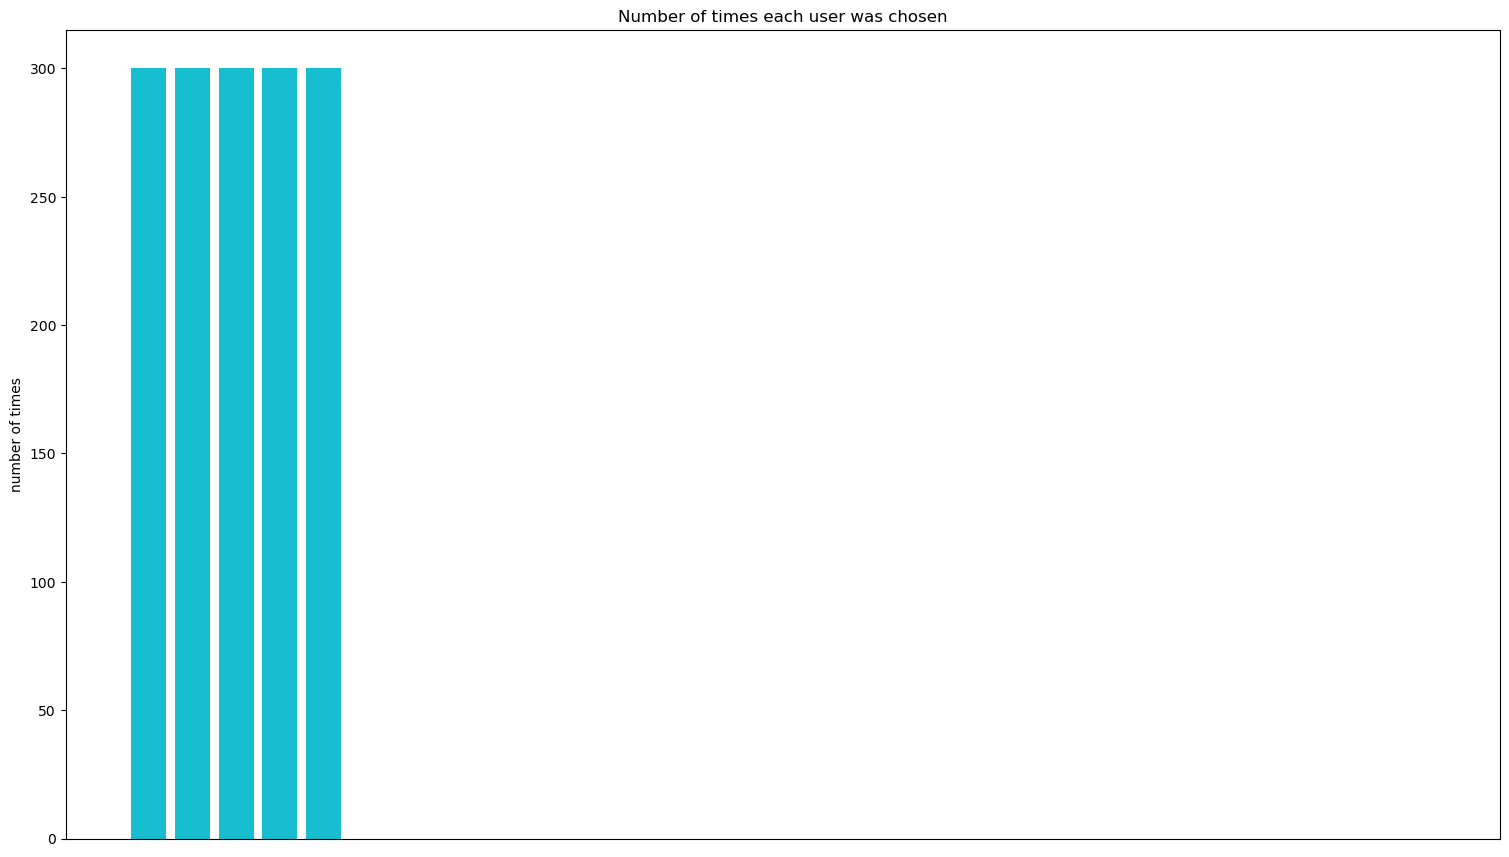

In [15]:


choices_table = np.zeros((args.global_epochs, args.num_users))
num_of_obs_arr = np.zeros((1,args.num_users))
train_loss_list = []
val_acc_list = []
val_losses_list = []
l1_norm_avg_deltha_theta_list = []
global_epochs_time_list = []
privacy_violations_list = []
max_privacy_violation = 0


time_counter = 0
for global_epoch in tqdm(range(1, args.global_epochs+1)):
    """Part 1: Choosing Users"""
    for usr_idx in range(args.num_users):
        local_models[usr_idx].update_g(global_epoch)
        local_models[usr_idx].update_ucb(global_epoch)
    
    if args.choosing_users_verbose:
        textio.cprint(f"iteration: {global_epoch}")
    a=time.time()
    rounds_choise = utils.choose_users(local_models, args, global_epoch, textio, method=args.method_choosing_users)

    
    #choices_table[global_epoch-1, rounds_choise] = 1
    num_of_obs_arr[0,rounds_choise] += 1
    num_slow_users = 0
    num_fast_users = 0
    for usr_idx in sorted(rounds_choise):
        local_models[usr_idx].update_emp_avg()
        local_models[usr_idx].update_privacy_violation_and_reward()
        local_models[usr_idx].increase_num_of_obs()
        if local_models[usr_idx].privacy_violation > max_privacy_violation:
            max_privacy_violation = local_models[usr_idx].privacy_violation
        if args.choosing_users_verbose:
            textio.cprint(f"user {usr_idx}, emp_avg: {local_models[usr_idx].emp_avg}, h: {local_models[usr_idx].ucb_generalization}, ucb: {local_models[usr_idx].ucb}, num_of_obs(calculated after picking at this round): {local_models[usr_idx].num_of_obs}, privacy reward: {local_models[usr_idx].privacy_reward}, g: {local_models[usr_idx].g}, curr_delay = {local_models[usr_idx].last_access_time}")
        if usr_idx < args.num_users//2:
            num_fast_users += 1
        else:
            num_slow_users += 1
    if args.choosing_users_verbose:
        textio.cprint(f"num of fast users chosen: {num_fast_users}, num of slow users chosen: {num_slow_users}")
    
    max_delay = max([local_models[i].last_access_time for i in rounds_choise])
    if args.choosing_users_verbose:
        textio.cprint(f"max_delay = {max_delay:.2f} seconds")

    privacy_violations_list.append(max_privacy_violation)
    
    
    
    """Part 2: Training"""
    learning_utils.distribute_model(local_models, global_model)
    users_avg_loss_over_local_epochs = []

    for user_idx in rounds_choise:
        user_loss = []
        for local_epoch in range(args.local_epochs):
            user = local_models[user_idx]
            train_loss = learning_utils.train_one_epoch(user, train_criterion, args)
            if args.lr_scheduler:
                user.scheduler.step(train_loss)
            user_loss.append(train_loss)
        users_avg_loss_over_local_epochs.append(mean(user_loss))
    
    avg_loss_over_chosen_users_curr_global_epoch = mean(users_avg_loss_over_local_epochs)
    train_loss_list.append(avg_loss_over_chosen_users_curr_global_epoch)


    avg_deltha_theta = learning_utils.Fed_avg_models(local_models, global_model, rounds_choise, textio
                                                     ,args, snr_verbose = args.snr_verbose)
    # l1_norm_avg_deltha_theta = sum(LA.vector_norm(param.flatten(),1) for param in avg_deltha_theta.values())
    # l1_norm_avg_deltha_theta_list.append(l1_norm_avg_deltha_theta)
    # print(f"l1_norm_avg_deltha_theta is {l1_norm_avg_deltha_theta}")
    

    val_acc, val_loss = learning_utils.test(test_loader, global_model, test_criterion, args)
    val_acc_list.append(val_acc) ; val_losses_list.append(val_loss)
    

    # boardio.add_scalars("Losses over time in seconds", {"train_loss":avg_loss_over_chosen_users_curr_global_epoch,
    #                                     "val_loss": val_loss}, time.time()-start_time)
    # boardio.add_scalar('Val Accuracy', val_acc, time.time()-start_time)


    time_counter += max_delay
    textio.cprint((f"global epoch {global_epoch} has been done artifficialy in {max_delay:.2f} secs, the total time by now is {time_counter:.2f} \n with avg train loss {avg_loss_over_chosen_users_curr_global_epoch:.3f}, val loss {val_loss:.3f}, avg val acc {val_acc:.2f}%"))
    global_epochs_time_list.append(time_counter)
    gc.collect()


    if val_acc > best_val_acc and args.save_best_model:
        best_val_acc = val_acc
        torch.save({"model's state dict":global_model.state_dict(),
                    "train_loss_list": train_loss_list,
                    "val_acc_list": val_acc_list,
                    "val_losses_list": val_losses_list,
                    "global_epochs_time_list": global_epochs_time_list,
                    "num_of_users": args.num_users,
                    "num_of_users_per_round": args.num_users_per_round,
                    "privacy_violations_list": privacy_violations_list}
                    , path_best_model)
    
    
    torch.save({"model's state dict":global_model.state_dict(),
                "train_loss_list": train_loss_list,
                "val_acc_list": val_acc_list,
                "val_losses_list": val_losses_list,
                "global_epochs_time_list": global_epochs_time_list,
                "num_of_obs_arr": num_of_obs_arr.reshape(-1),
                "global_epoch": global_epoch,
                "num_of_users": args.num_users,
                "num_of_users_per_round": args.num_users_per_round,
                "privacy_violations_list": privacy_violations_list}
                , last_model_path)
    
    users_idxs = tuple([str(x) for x in range(1,args.num_users+1)])
    plt.bar(users_idxs, num_of_obs_arr.reshape(-1))
    plt.title("Number of times each user was chosen")
    plt.ylabel("number of times")
    #hide x labels 
    plt.xticks([])
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    #boardio.add_figure("Number of times each user was chosen", fig, global_epoch)
    plt.savefig(last_model_path.parent / "Number of times each user was chosen.png")

    if time_counter > args.max_seconds:
        break



#choices_table = choices_table.cumsum(axis=0)
